In [1]:
# 001_feature_and_training.ipynb
# Football Prediction Model: Feature Engineering and Model Training

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime, timedelta
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import log_loss, brier_score_loss
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('ggplot')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 8)

# Connect to database
conn = sqlite3.connect('db_sportmonks.db')

# First, let's explore the database structure to understand available tables
def explore_database_structure():
    # Get list of tables in the database
    tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
    print(f"Tables in database ({len(tables)}): \n{tables['name'].tolist()}")
    
    # For key tables, show sample structure
    key_tables = ['fixtures', 'teams', 'leagues', 'seasons', 'events']
    
    for table in key_tables:
        if table in tables['name'].values:
            # Get column information
            columns = pd.read_sql(f"PRAGMA table_info({table});", conn)
            print(f"\nColumns in {table} table:")
            print(columns[['name', 'type']])
            
            # Show row count
            count = pd.read_sql(f"SELECT COUNT(*) as count FROM {table}", conn)
            print(f"Total rows: {count['count'].iloc[0]}")
            
            # Show sample data (first 3 rows)
            sample = pd.read_sql(f"SELECT * FROM {table} LIMIT 3", conn)
            print("\nSample data:")
            print(sample)

# Run the database exploration
explore_database_structure()

Tables in database (45): 
['continents', 'countries', 'regions', 'cities', 'leagues', 'seasons', 'schedules', 'stages', 'rounds', 'teams', 'players', 'coaches', 'referees', 'squads', 'sqlite_sequence', 'fixtures', 'events', 'lineups', 'commentaries', 'predictions', 'standings', 'statistics', 'top_scorers', 'bookmakers', 'markets', 'odds', 'trends', 'venues', 'tv_stations', 'groups', 'transfers', 'rivals', 'news', 'expected_xg', 'team_squads', 'topscorers', 'penalties', 'cards', 'processed_fixtures', 'checkpoint', 'fixture_odds', 'processed_fixtures_odds', 'odds_checkpoint', 'fixture_team_names', 'team_name_mapping']

Columns in fixtures table:
            name     type
0             id  INTEGER
1      league_id  INTEGER
2      season_id  INTEGER
3       stage_id  INTEGER
4       round_id  INTEGER
5   home_team_id  INTEGER
6   away_team_id  INTEGER
7       venue_id  INTEGER
8     referee_id  INTEGER
9    starting_at     TEXT
10        status     TEXT
11    score_home  INTEGER
12    scor

In [2]:
# 1. Data Preparation and Feature Engineering
print("1. Data Preparation and Feature Engineering")

# Let's first check if we have odds data for matches
def check_odds_data():
    # Check fixture_odds table
    odds_count = pd.read_sql("""
        SELECT COUNT(*) as count 
        FROM fixture_odds
    """, conn)
    
    print(f"Total rows in fixture_odds: {odds_count['count'].iloc[0]}")
    
    # Get sample of odds data
    sample_odds = pd.read_sql("""
        SELECT * FROM fixture_odds LIMIT 3
    """, conn)
    
    print("Sample odds data:")
    print(sample_odds)
    
    # Check for match results with associated odds
    matches_with_odds = pd.read_sql("""
        SELECT COUNT(*) as count
        FROM fixtures f
        JOIN fixture_odds o ON f.id = o.fixture_id
        WHERE f.score_home IS NOT NULL AND f.score_away IS NOT NULL
    """, conn)
    
    print(f"Matches with results and odds: {matches_with_odds['count'].iloc[0]}")

check_odds_data()

# Define a function to get match data with basic features
def get_match_data(leagues=None, seasons=None, min_date=None, max_date=None, limit=None):
    """
    Extract match data with basic features from the database
    """
    query = """
        SELECT 
            f.id as fixture_id,
            f.league_id,
            l.name as league_name,
            f.season_id,
            s.name as season_name,
            f.home_team_id,
            ht.name as home_team,
            f.away_team_id,
            at.name as away_team,
            f.starting_at,
            f.score_home,
            f.score_away,
            CASE 
                WHEN f.score_home > f.score_away THEN 'H'
                WHEN f.score_home = f.score_away THEN 'D'
                WHEN f.score_home < f.score_away THEN 'A'
                ELSE NULL
            END as result
        FROM fixtures f
        JOIN teams ht ON f.home_team_id = ht.id
        JOIN teams at ON f.away_team_id = at.id
        JOIN leagues l ON f.league_id = l.id
        JOIN seasons s ON f.season_id = s.id
        WHERE f.score_home IS NOT NULL AND f.score_away IS NOT NULL
    """
    
    # Add filters
    if leagues:
        leagues_str = ','.join(map(str, leagues))
        query += f" AND f.league_id IN ({leagues_str})"
    
    if seasons:
        seasons_str = ','.join(map(str, seasons))
        query += f" AND f.season_id IN ({seasons_str})"
    
    if min_date:
        query += f" AND f.starting_at >= '{min_date}'"
    
    if max_date:
        query += f" AND f.starting_at <= '{max_date}'"
    
    # Add order by and limit
    query += " ORDER BY f.starting_at"
    
    if limit:
        query += f" LIMIT {limit}"
    
    # Execute query
    matches = pd.read_sql(query, conn)
    
    # Convert date
    matches['starting_at'] = pd.to_datetime(matches['starting_at'])
    
    # Add additional basic features
    matches['total_goals'] = matches['score_home'] + matches['score_away']
    matches['goal_difference'] = matches['score_home'] - matches['score_away']
    matches['home_win'] = (matches['result'] == 'H').astype(int)
    matches['draw'] = (matches['result'] == 'D').astype(int)
    matches['away_win'] = (matches['result'] == 'A').astype(int)
    
    return matches

# Get a sample of match data for Premier League (league_id=8)
premier_league_matches = get_match_data(leagues=[8], limit=5000)
print(f"\nLoaded {len(premier_league_matches)} Premier League matches")
print(premier_league_matches.head())

# Check the date range and seasons covered
print(f"\nDate range: {premier_league_matches['starting_at'].min()} to {premier_league_matches['starting_at'].max()}")
print(f"Seasons covered: {premier_league_matches['season_name'].unique()}")

# Let's look at the distribution of match outcomes
outcome_counts = premier_league_matches['result'].value_counts()
print("\nOutcome distribution:")
print(outcome_counts)
print(f"Home win percentage: {100 * outcome_counts['H'] / len(premier_league_matches):.1f}%")
print(f"Draw percentage: {100 * outcome_counts['D'] / len(premier_league_matches):.1f}%")
print(f"Away win percentage: {100 * outcome_counts['A'] / len(premier_league_matches):.1f}%")

# Now, let's define our feature engineering class for the prediction model
class FootballFeatureEngineering:
    def __init__(self, conn, base_matches=None):
        self.conn = conn
        self.base_matches = base_matches
    
    def generate_team_form_features(self, team_id, match_date, lookback=5):
        """Generate form features for a team before a specific date"""
        # Get previous matches
        query = f"""
            SELECT 
                f.id,
                f.starting_at,
                f.home_team_id,
                f.away_team_id,
                f.score_home,
                f.score_away,
                CASE 
                    WHEN f.home_team_id = {team_id} THEN 'H'
                    ELSE 'A'
                END as venue,
                CASE 
                    WHEN (f.home_team_id = {team_id} AND f.score_home > f.score_away) OR 
                         (f.away_team_id = {team_id} AND f.score_away > f.score_home) THEN 'W'
                    WHEN f.score_home = f.score_away THEN 'D'
                    ELSE 'L'
                END as result
            FROM fixtures f
            WHERE (f.home_team_id = {team_id} OR f.away_team_id = {team_id})
            AND f.score_home IS NOT NULL AND f.score_away IS NOT NULL
            AND f.starting_at < '{match_date}'
            ORDER BY f.starting_at DESC
            LIMIT {lookback}
        """
        
        prev_matches = pd.read_sql(query, self.conn)
        
        # If no previous matches, return default values
        if prev_matches.empty:
            return {
                'form_points': 0,
                'form_points_per_game': 0,
                'recent_wins': 0,
                'recent_draws': 0,
                'recent_losses': 0,
                'goals_scored': 0,
                'goals_conceded': 0,
                'goals_per_game': 0,
                'conceded_per_game': 0,
                'clean_sheets': 0,
                'failed_to_score': 0,
                'form_home_points': 0,
                'form_away_points': 0
            }
        
        # Calculate form metrics
        points = {'W': 3, 'D': 1, 'L': 0}
        form_points = sum(points[r] for r in prev_matches['result'])
        
        # Count results
        result_counts = prev_matches['result'].value_counts()
        wins = result_counts.get('W', 0)
        draws = result_counts.get('D', 0)
        losses = result_counts.get('L', 0)
        
        # Calculate goals
        goals_scored = 0
        goals_conceded = 0
        clean_sheets = 0
        failed_to_score = 0
        
        for _, match in prev_matches.iterrows():
            if match['venue'] == 'H':
                # Team played at home
                goals_scored += match['score_home']
                goals_conceded += match['score_away']
                if match['score_away'] == 0:
                    clean_sheets += 1
                if match['score_home'] == 0:
                    failed_to_score += 1
            else:
                # Team played away
                goals_scored += match['score_away']
                goals_conceded += match['score_home']
                if match['score_home'] == 0:
                    clean_sheets += 1
                if match['score_away'] == 0:
                    failed_to_score += 1
        
        # Home/away form
        home_matches = prev_matches[prev_matches['venue'] == 'H']
        away_matches = prev_matches[prev_matches['venue'] == 'A']
        
        home_points = sum(points[r] for r in home_matches['result']) if not home_matches.empty else 0
        away_points = sum(points[r] for r in away_matches['result']) if not away_matches.empty else 0
        
        # Return all features
        return {
            'form_points': form_points,
            'form_points_per_game': form_points / len(prev_matches),
            'recent_wins': wins,
            'recent_draws': draws,
            'recent_losses': losses,
            'goals_scored': goals_scored,
            'goals_conceded': goals_conceded,
            'goals_per_game': goals_scored / len(prev_matches),
            'conceded_per_game': goals_conceded / len(prev_matches),
            'clean_sheets': clean_sheets,
            'failed_to_score': failed_to_score,
            'form_home_points': home_points,
            'form_away_points': away_points
        }
    
    def generate_head_to_head_features(self, home_team_id, away_team_id, match_date):
        """Generate head-to-head features between two teams"""
        # Get previous h2h matches
        query = f"""
            SELECT 
                f.id,
                f.starting_at,
                f.home_team_id,
                f.away_team_id,
                f.score_home,
                f.score_away
            FROM fixtures f
            WHERE ((f.home_team_id = {home_team_id} AND f.away_team_id = {away_team_id}) OR
                  (f.home_team_id = {away_team_id} AND f.away_team_id = {home_team_id}))
            AND f.score_home IS NOT NULL AND f.score_away IS NOT NULL
            AND f.starting_at < '{match_date}'
            ORDER BY f.starting_at DESC
            LIMIT 10
        """
        
        h2h_matches = pd.read_sql(query, self.conn)
        
        # If no previous h2h matches, return default values
        if h2h_matches.empty:
            return {
                'h2h_played': 0,
                'h2h_home_wins': 0,
                'h2h_away_wins': 0,
                'h2h_draws': 0,
                'h2h_home_win_rate': 0,
                'h2h_home_goals_avg': 0,
                'h2h_away_goals_avg': 0
            }
        
        # Calculate h2h metrics
        h2h_played = len(h2h_matches)
        home_wins = 0
        away_wins = 0
        draws = 0
        home_goals = 0
        away_goals = 0
        
        for _, match in h2h_matches.iterrows():
            # Remap teams to current home/away
            if match['home_team_id'] == home_team_id:
                # Same home team
                home_goals += match['score_home']
                away_goals += match['score_away']
                
                if match['score_home'] > match['score_away']:
                    home_wins += 1
                elif match['score_home'] < match['score_away']:
                    away_wins += 1
                else:
                    draws += 1
            else:
                # Teams reversed
                home_goals += match['score_away']
                away_goals += match['score_home']
                
                if match['score_away'] > match['score_home']:
                    home_wins += 1
                elif match['score_away'] < match['score_home']:
                    away_wins += 1
                else:
                    draws += 1
        
        # Return features
        return {
            'h2h_played': h2h_played,
            'h2h_home_wins': home_wins,
            'h2h_away_wins': away_wins,
            'h2h_draws': draws,
            'h2h_home_win_rate': home_wins / h2h_played * 100 if h2h_played > 0 else 0,
            'h2h_home_goals_avg': home_goals / h2h_played if h2h_played > 0 else 0,
            'h2h_away_goals_avg': away_goals / h2h_played if h2h_played > 0 else 0
        }
    
    def generate_league_features(self, league_id, match_date):
        """Generate league-specific features like home advantage"""
        # Get previous league matches
        query = f"""
            SELECT 
                f.score_home,
                f.score_away
            FROM fixtures f
            WHERE f.league_id = {league_id}
            AND f.score_home IS NOT NULL AND f.score_away IS NOT NULL
            AND f.starting_at < '{match_date}'
            ORDER BY f.starting_at DESC
            LIMIT 380
        """
        
        league_matches = pd.read_sql(query, self.conn)
        
        # If no previous matches, return default values
        if league_matches.empty:
            return {
                'league_home_advantage': 0.3,  # Default home advantage
                'league_avg_goals': 2.6,      # Default goals per game
                'league_home_win_rate': 46    # Default home win %
            }
        
        # Calculate metrics
        home_goals = league_matches['score_home'].sum()
        away_goals = league_matches['score_away'].sum()
        total_matches = len(league_matches)
        
        home_wins = sum(league_matches['score_home'] > league_matches['score_away'])
        
        # Return features
        return {
            'league_home_advantage': (home_goals - away_goals) / total_matches,
            'league_avg_goals': (home_goals + away_goals) / total_matches,
            'league_home_win_rate': home_wins / total_matches * 100
        }
    
    def generate_match_features(self, fixture_id=None, home_team_id=None, away_team_id=None, match_date=None):
        """Generate all features for a specific match"""
        # If fixture_id provided, get match details
        if fixture_id is not None and (home_team_id is None or away_team_id is None or match_date is None):
            match_details = pd.read_sql(f"""
                SELECT 
                    f.home_team_id,
                    f.away_team_id,
                    f.starting_at,
                    f.league_id
                FROM fixtures f
                WHERE f.id = {fixture_id}
            """, self.conn)
            
            if match_details.empty:
                return None
            
            home_team_id = match_details['home_team_id'].iloc[0]
            away_team_id = match_details['away_team_id'].iloc[0]
            match_date = match_details['starting_at'].iloc[0]
            league_id = match_details['league_id'].iloc[0]
        else:
            # Get league_id from home team
            league_query = f"""
                SELECT DISTINCT f.league_id
                FROM fixtures f
                WHERE f.home_team_id = {home_team_id}
                LIMIT 1
            """
            league_result = pd.read_sql(league_query, self.conn)
            league_id = league_result['league_id'].iloc[0] if not league_result.empty else None
        
        # Generate all features
        home_form = self.generate_team_form_features(home_team_id, match_date)
        away_form = self.generate_team_form_features(away_team_id, match_date)
        h2h = self.generate_head_to_head_features(home_team_id, away_team_id, match_date)
        league = self.generate_league_features(league_id, match_date) if league_id else {}
        
        # Combine all features
        features = {}
        
        # Add team form features with prefix
        for key, value in home_form.items():
            features[f'home_{key}'] = value
        
        for key, value in away_form.items():
            features[f'away_{key}'] = value
        
        # Add h2h features
        features.update(h2h)
        
        # Add league features
        if league:
            features.update(league)
        
        # Add comparative features
        features['form_points_diff'] = home_form['form_points'] - away_form['form_points']
        features['goals_per_game_diff'] = home_form['goals_per_game'] - away_form['goals_per_game']
        features['conceded_per_game_diff'] = home_form['conceded_per_game'] - away_form['conceded_per_game']
        
        return features

# Test our feature engineering on a sample match
feature_engineer = FootballFeatureEngineering(conn)
sample_match = premier_league_matches.iloc[1000]  # Choose a match in the middle of the dataset

print("\nGenerating features for a sample match:")
print(f"Match: {sample_match['home_team']} vs {sample_match['away_team']} on {sample_match['starting_at']}")

match_features = feature_engineer.generate_match_features(
    fixture_id=sample_match['fixture_id']
)

# Display some key features
print("\nKey features generated:")
key_features = [
    'home_form_points', 'away_form_points', 'form_points_diff',
    'home_goals_per_game', 'away_goals_per_game', 'goals_per_game_diff', 
    'h2h_home_win_rate', 'league_home_advantage'
]

for feature in key_features:
    if feature in match_features:
        print(f"{feature}: {match_features[feature]:.2f}")

# Now let's prepare a dataset for model training by generating features for a set of matches
def prepare_training_dataset(matches, feature_engineer):
    """Prepare a training dataset with features for a set of matches"""
    features_list = []
    target_list = []
    
    print("Preparing training dataset...")
    print(f"Total matches to process: {len(matches)}")
    
    # Process in batches and show progress
    batch_size = 100
    for i in range(0, len(matches), batch_size):
        batch = matches.iloc[i:i+batch_size]
        print(f"Processing matches {i} to {i+len(batch)-1}...")
        
        for _, match in batch.iterrows():
            features = feature_engineer.generate_match_features(fixture_id=match['fixture_id'])
            
            if features:
                features_list.append(features)
                target_list.append({
                    'home_win': match['home_win'],
                    'draw': match['draw'],
                    'away_win': match['away_win']
                })
    
    # Convert to DataFrames
    X = pd.DataFrame(features_list)
    y = pd.DataFrame(target_list)
    
    return X, y

# Let's use a subset of matches for our initial model
training_matches = premier_league_matches[premier_league_matches['starting_at'] < '2022-01-01'].sample(500)
X_train, y_train = prepare_training_dataset(training_matches, feature_engineer)

print(f"\nTraining dataset prepared with {len(X_train)} matches and {len(X_train.columns)} features")
print("Feature names:", X_train.columns.tolist())
print("Target distribution:")
print(f"Home wins: {y_train['home_win'].sum()} ({y_train['home_win'].mean()*100:.1f}%)")
print(f"Draws: {y_train['draw'].sum()} ({y_train['draw'].mean()*100:.1f}%)")
print(f"Away wins: {y_train['away_win'].sum()} ({y_train['away_win'].mean()*100:.1f}%)")

1. Data Preparation and Feature Engineering
Total rows in fixture_odds: 104236537
Sample odds data:
   id  fixture_id  bookmaker_id bookmaker_name  market_id      market_name  \
0   1     4194308            18          MyBet          1  Fulltime Result   
1   2     4194308            18          MyBet          1  Fulltime Result   
2   3     4194308            18          MyBet          1  Fulltime Result   

  odds_label  odds_value  probability  is_winning  \
0          1        1.70       0.5882           0   
1          2        5.00       0.2000           0   
2          X        3.75       0.2667           0   

                         updated_at  
0  2025-05-09T15:18:21.811200+00:00  
1  2025-05-09T15:18:21.811200+00:00  
2  2025-05-09T15:18:21.811200+00:00  
Matches with results and odds: 104126754

Loaded 5000 Premier League matches
   fixture_id  league_id     league_name  season_id season_name  home_team_id  \
0    19253422          8  Premier League      24263   2000/2001 


2. Model Training and Evaluation

Training model for home_win...
Accuracy: 0.8240
Log Loss: 0.5455
Brier Score: 0.1783

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.97      0.86       281
           1       0.95      0.63      0.76       219

    accuracy                           0.82       500
   macro avg       0.86      0.80      0.81       500
weighted avg       0.85      0.82      0.82       500



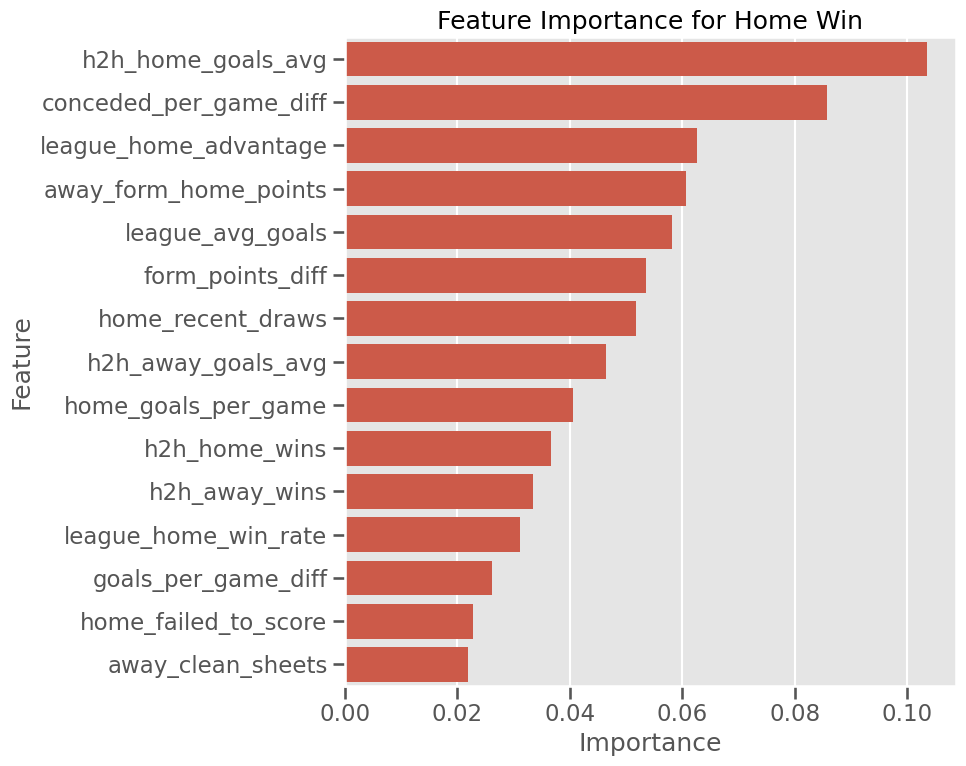

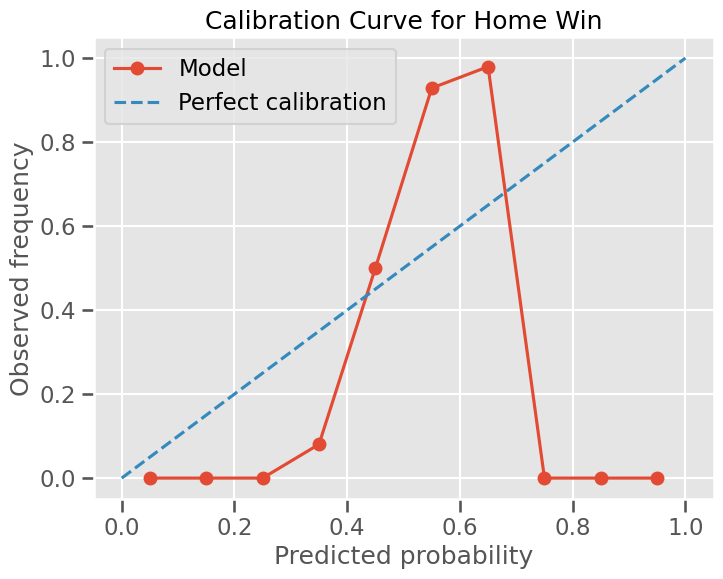


Training model for draw...
Accuracy: 0.7360
Log Loss: 0.5464
Brier Score: 0.1814

Classification Report:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85       368
           1       0.00      0.00      0.00       132

    accuracy                           0.74       500
   macro avg       0.37      0.50      0.42       500
weighted avg       0.54      0.74      0.62       500



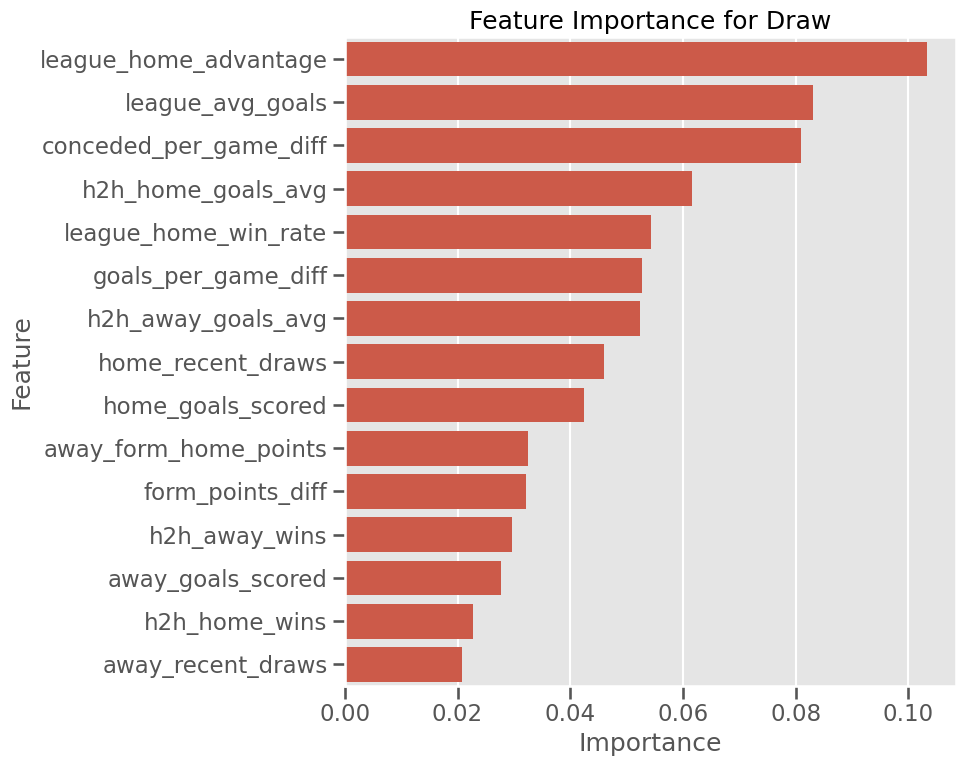

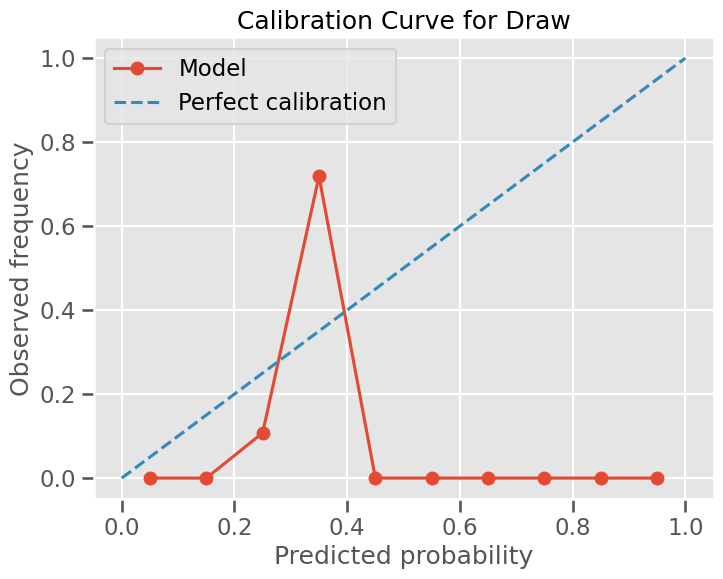


Training model for away_win...
Accuracy: 0.7020
Log Loss: 0.5177
Brier Score: 0.1715

Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       351
           1       0.00      0.00      0.00       149

    accuracy                           0.70       500
   macro avg       0.35      0.50      0.41       500
weighted avg       0.49      0.70      0.58       500



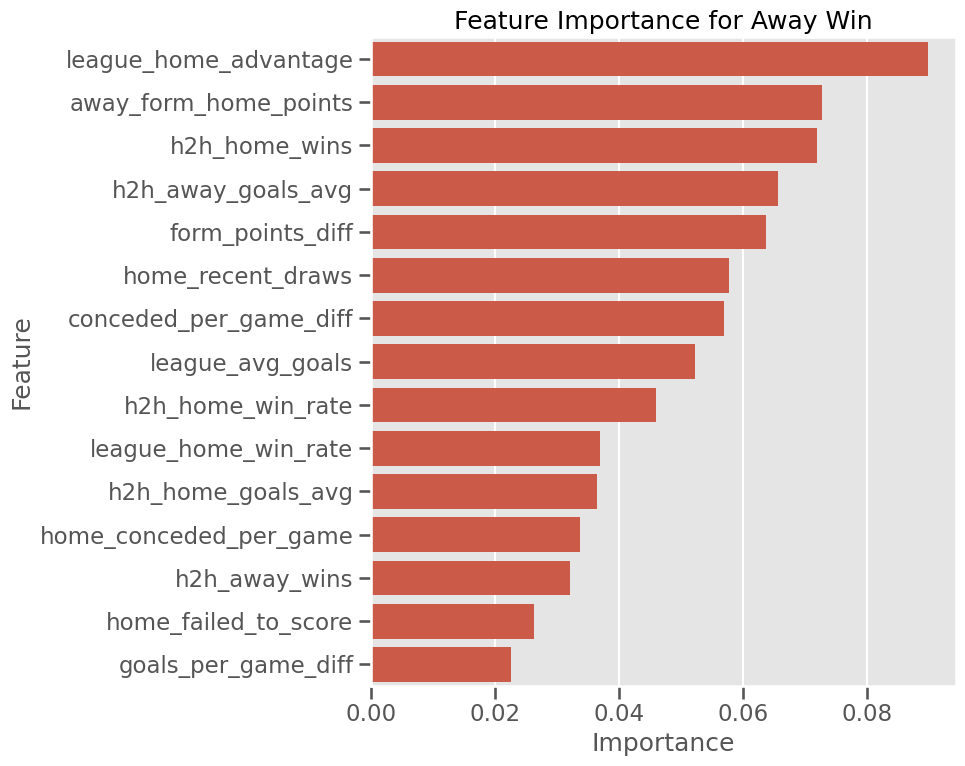

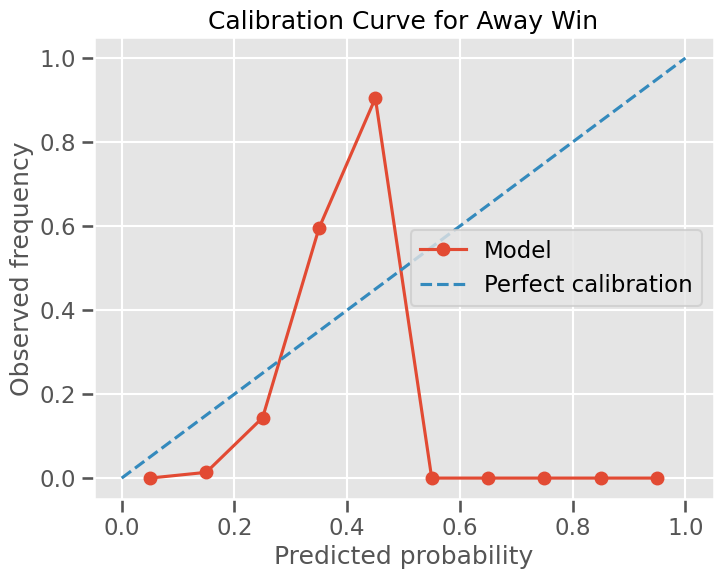


3. Combined Model Evaluation
Test set: 100 matches from 2012-10-06 14:00:00 to 2013-09-29 12:30:00

Generating predictions for test matches...

Overall Accuracy: 0.5300


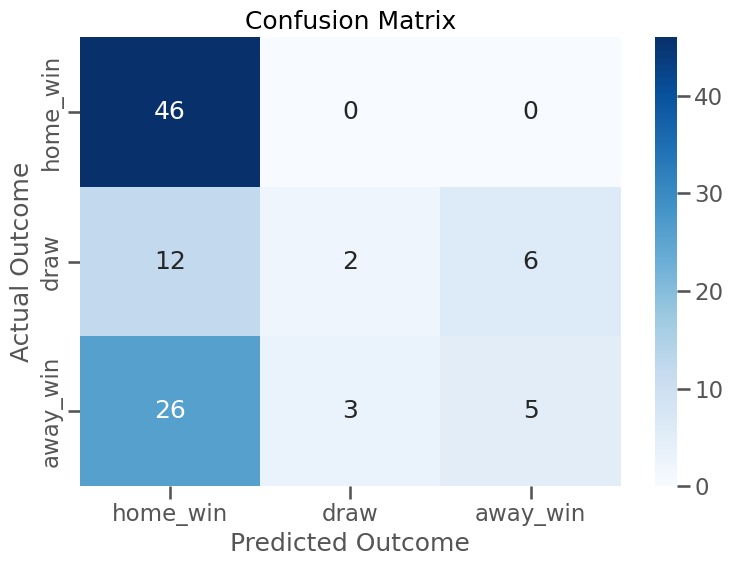


4. Odds Integration and Value Betting Analysis
Loaded 100 matches with odds
Average bookmaker margin: 15.02%

Found 96 value bets with positive expected value
Average expected value: 1.0987
Win rate on value bets: 0.0833
ROI on value bets: -0.6979 (-69.79%)


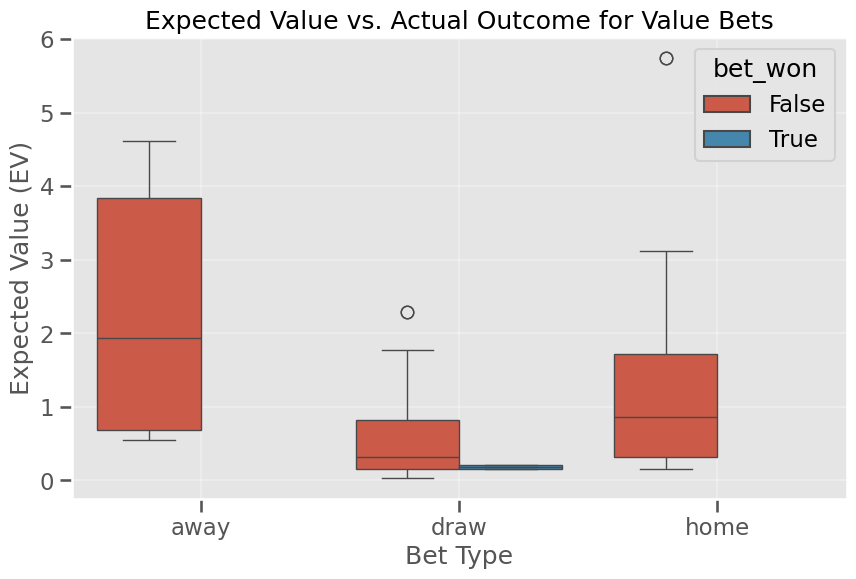

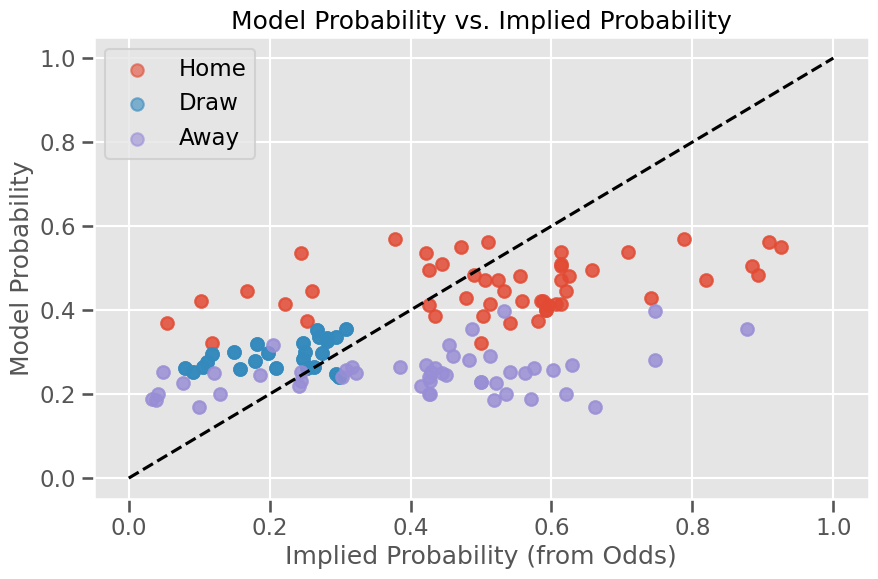


5. Save Models and Results
Saved home_win model to models/home_win_model.pkl
Saved draw model to models/draw_model.pkl
Saved away_win model to models/away_win_model.pkl
Saved feature scaler to models/scaler.pkl
Saved feature list to models/feature_list.pkl

Example prediction for a future match:
Teams: [{'id': 4, 'name': 'Charlton Athletic'}, {'id': 19, 'name': 'Arsenal'}]
Home win probability: 0.4448
Draw probability: 0.2715
Away win probability: 0.2838

Database connection closed.
Feature engineering and model training complete!


In [5]:
# 2. Model Training and Evaluation
print("\n2. Model Training and Evaluation")

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot calibration curve
def plot_calibration_curve(y_true, y_prob, title, n_bins=10):
    """Plot calibration curve for model predictions"""
    plt.figure(figsize=(8, 6))
    
    # Calculate bin edges
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Bin predictions
    indices = np.clip(np.digitize(y_prob, bin_edges[1:-1]), 0, n_bins - 1)
    
    # Calculate observed probabilities in each bin
    bin_sums = np.bincount(indices, minlength=n_bins)
    bin_true = np.bincount(indices, weights=y_true, minlength=n_bins)
    
    # Calculate observed probabilities in each bin
    bin_observed = np.zeros(n_bins)
    for i in range(n_bins):
        if bin_sums[i] > 0:
            bin_observed[i] = bin_true[i] / bin_sums[i]
    
    # Plot calibration curve
    plt.plot(bin_centers, bin_observed, 'o-', label='Model')
    plt.plot([0, 1], [0, 1], '--', label='Perfect calibration')
    plt.xlabel('Predicted probability')
    plt.ylabel('Observed frequency')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Handle missing or infinite values in the dataset
X_train = X_train.fillna(0)
X_train = X_train.replace([np.inf, -np.inf], 0)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Create TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Train models for each outcome with feature importance tracking
models = {}
feature_importances = {}
target_names = ['home_win', 'draw', 'away_win']

for target in target_names:
    print(f"\nTraining model for {target}...")
    
    # Create base model first
    base_model = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=4,
        min_samples_split=5,
        random_state=42
    )
    
    # Fit the base model first to extract feature importances
    base_model.fit(X_train_scaled, y_train[target])
    
    # Store feature importances
    feature_importances[target] = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': base_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Now create the calibrated version
    model = CalibratedClassifierCV(
        base_model,
        method='sigmoid',
        cv=tscv
    )
    
    # Train model
    model.fit(X_train_scaled, y_train[target])
    
    # Save model
    models[target] = model
    
    # Get model predictions
    y_pred_prob = model.predict_proba(X_train_scaled)[:, 1]
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Calculate metrics
    acc = accuracy_score(y_train[target], y_pred)
    log_l = log_loss(y_train[target], y_pred_prob)
    brier = brier_score_loss(y_train[target], y_pred_prob)
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Log Loss: {log_l:.4f}")
    print(f"Brier Score: {brier:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_train[target], y_pred))
    
    # Plot feature importance
    feature_importance = feature_importances[target]
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title(f"Feature Importance for {target.replace('_', ' ').title()}")
    plt.tight_layout()
    plt.show()
    
    # Plot calibration curve
    plot_calibration_curve(
        y_train[target].values, 
        y_pred_prob, 
        f"Calibration Curve for {target.replace('_', ' ').title()}"
    )

# 3. Combined Model Evaluation
print("\n3. Combined Model Evaluation")

# Function to get combined predictions for a match
def predict_match_outcome(models, features, scaler=None):
    """Get model predictions for all outcomes and normalize probabilities"""
    if scaler:
        features_scaled = scaler.transform([features])
    else:
        features_scaled = [features]
    
    # Get probabilities for each outcome
    probs = {}
    for outcome, model in models.items():
        probs[outcome] = model.predict_proba(features_scaled)[0][1]
    
    # Normalize probabilities to sum to 1
    total_prob = sum(probs.values())
    for outcome in probs:
        probs[outcome] /= total_prob
    
    return probs

# Find the most recent date in the dataset
max_date = premier_league_matches['starting_at'].max()
# Use matches from the last year of data for testing
one_year_before = max_date - pd.Timedelta(days=365)
test_matches = premier_league_matches[premier_league_matches['starting_at'] >= one_year_before].sample(min(100, len(premier_league_matches[premier_league_matches['starting_at'] >= one_year_before])))
print(f"Test set: {len(test_matches)} matches from {test_matches['starting_at'].min()} to {test_matches['starting_at'].max()}")

# Generate features for test matches and make predictions
test_results = []

print("\nGenerating predictions for test matches...")
for i, match in test_matches.iterrows():
    # Generate features
    features = feature_engineer.generate_match_features(fixture_id=match['fixture_id'])
    
    if not features:
        continue
    
    # Handle missing values
    features_df = pd.DataFrame([features])
    features_df = features_df.fillna(0)
    features_df = features_df.replace([np.inf, -np.inf], 0)
    
    # Ensure all columns from training are present
    for col in X_train.columns:
        if col not in features_df.columns:
            features_df[col] = 0
    
    # Keep only columns used in training
    features_df = features_df[X_train.columns]
    
    # Scale features
    features_scaled = scaler.transform(features_df)
    
    # Get predictions
    probs = {}
    for outcome, model in models.items():
        probs[outcome] = model.predict_proba(features_scaled)[0][1]
    
    # Normalize probabilities
    total_prob = sum(probs.values())
    for outcome in probs:
        probs[outcome] /= total_prob
    
    # Determine predicted outcome
    predicted_outcome = max(probs, key=probs.get)
    actual_outcome = None
    if match['home_win'] == 1:
        actual_outcome = 'home_win'
    elif match['draw'] == 1:
        actual_outcome = 'draw'
    else:
        actual_outcome = 'away_win'
    
    # Record result
    test_results.append({
        'fixture_id': match['fixture_id'],
        'match_date': match['starting_at'],
        'home_team': match['home_team'],
        'away_team': match['away_team'],
        'score': f"{match['score_home']}-{match['score_away']}",
        'actual_outcome': actual_outcome,
        'predicted_outcome': predicted_outcome,
        'home_win_prob': probs['home_win'],
        'draw_prob': probs['draw'],
        'away_win_prob': probs['away_win'],
        'correct': predicted_outcome == actual_outcome
    })
# Convert to DataFrame
test_results_df = pd.DataFrame(test_results)

# Calculate overall accuracy
accuracy = test_results_df['correct'].mean()
print(f"\nOverall Accuracy: {accuracy:.4f}")

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
y_true = test_results_df['actual_outcome']
y_pred = test_results_df['predicted_outcome']

cm = confusion_matrix(y_true, y_pred, labels=target_names)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Outcome')
plt.ylabel('Actual Outcome')
plt.tight_layout()
plt.show()

# 4. Odds Integration and Value Betting Analysis
print("\n4. Odds Integration and Value Betting Analysis")

# Function to calculate implied probability from decimal odds
def implied_prob(odds):
    """Calculate implied probability from decimal odds"""
    return 1 / odds

# Function to calculate expected value
def expected_value(model_prob, odds):
    """Calculate expected value of a bet"""
    return (model_prob * odds) - 1

# Let's get some matches with odds for analysis
matches_with_odds = pd.read_sql("""
    SELECT 
        f.id as fixture_id,
        f.league_id,
        l.name as league_name,
        f.season_id,
        s.name as season_name,
        f.home_team_id,
        ht.name as home_team,
        f.away_team_id,
        at.name as away_team,
        f.starting_at,
        f.score_home,
        f.score_away,
        CASE 
            WHEN f.score_home > f.score_away THEN 'H'
            WHEN f.score_home = f.score_away THEN 'D'
            WHEN f.score_home < f.score_away THEN 'A'
            ELSE NULL
        END as result,
        o1.odds_value as home_odds,
        o2.odds_value as draw_odds,
        o3.odds_value as away_odds
    FROM fixtures f
    JOIN teams ht ON f.home_team_id = ht.id
    JOIN teams at ON f.away_team_id = at.id
    JOIN leagues l ON f.league_id = l.id
    JOIN seasons s ON f.season_id = s.id
    JOIN fixture_odds o1 ON f.id = o1.fixture_id AND o1.odds_label = '1'
    JOIN fixture_odds o2 ON f.id = o2.fixture_id AND o2.odds_label = 'X'
    JOIN fixture_odds o3 ON f.id = o3.fixture_id AND o3.odds_label = '2'
    WHERE f.score_home IS NOT NULL AND f.score_away IS NOT NULL
    AND f.league_id = 8  -- Premier League
    AND o1.bookmaker_id = 1  -- Using a consistent bookmaker
    AND o2.bookmaker_id = 1
    AND o3.bookmaker_id = 1
    LIMIT 100
""", conn)

print(f"Loaded {len(matches_with_odds)} matches with odds")

# Calculate implied probabilities
matches_with_odds['home_implied_prob'] = matches_with_odds['home_odds'].apply(implied_prob)
matches_with_odds['draw_implied_prob'] = matches_with_odds['draw_odds'].apply(implied_prob)
matches_with_odds['away_implied_prob'] = matches_with_odds['away_odds'].apply(implied_prob)

# Calculate bookmaker margin (overround)
matches_with_odds['bookmaker_margin'] = (
    matches_with_odds['home_implied_prob'] + 
    matches_with_odds['draw_implied_prob'] + 
    matches_with_odds['away_implied_prob'] - 1
) * 100

print(f"Average bookmaker margin: {matches_with_odds['bookmaker_margin'].mean():.2f}%")

# Generate model predictions for these matches
value_analysis = []

for _, match in matches_with_odds.iterrows():
    # Generate features
    features = feature_engineer.generate_match_features(fixture_id=match['fixture_id'])
    
    if not features:
        continue
    
    # Handle missing values
    features_df = pd.DataFrame([features])
    features_df = features_df.fillna(0)
    features_df = features_df.replace([np.inf, -np.inf], 0)
    
    # Ensure all columns from training are present
    for col in X_train.columns:
        if col not in features_df.columns:
            features_df[col] = 0
    
    # Keep only columns used in training
    features_df = features_df[X_train.columns]
    
    # Scale features
    features_scaled = scaler.transform(features_df)
    
    # Get predictions
    probs = {}
    for outcome, model in models.items():
        probs[outcome] = model.predict_proba(features_scaled)[0][1]
    
    # Normalize probabilities
    total_prob = sum(probs.values())
    for outcome in probs:
        probs[outcome] /= total_prob
    
    # Map outcome names to odds columns
    outcome_to_odds = {
        'home_win': 'home_odds',
        'draw': 'draw_odds',
        'away_win': 'away_odds'
    }
    
    # Calculate expected value for each outcome
    ev = {}
    for outcome, model_prob in probs.items():
        odds = match[outcome_to_odds[outcome]]
        ev[outcome] = expected_value(model_prob, odds)
    
    # Determine actual outcome
    actual_outcome = None
    if match['result'] == 'H':
        actual_outcome = 'home_win'
    elif match['result'] == 'D':
        actual_outcome = 'draw'
    else:
        actual_outcome = 'away_win'
    
    # Record value analysis
    value_analysis.append({
        'fixture_id': match['fixture_id'],
        'match_date': match['starting_at'],
        'home_team': match['home_team'],
        'away_team': match['away_team'],
        'score': f"{match['score_home']}-{match['score_away']}",
        'actual_outcome': actual_outcome,
        'home_odds': match['home_odds'],
        'draw_odds': match['draw_odds'],
        'away_odds': match['away_odds'],
        'home_implied_prob': match['home_implied_prob'],
        'draw_implied_prob': match['draw_implied_prob'],
        'away_implied_prob': match['away_implied_prob'],
        'home_model_prob': probs['home_win'],
        'draw_model_prob': probs['draw'],
        'away_model_prob': probs['away_win'],
        'home_ev': ev['home_win'],
        'draw_ev': ev['draw'],
        'away_ev': ev['away_win']
    })

# Convert to DataFrame
value_analysis_df = pd.DataFrame(value_analysis)

# Find value bets (positive EV)
value_bets = value_analysis_df.copy()
value_bets['max_ev'] = value_bets[['home_ev', 'draw_ev', 'away_ev']].max(axis=1)
value_bets['max_ev_outcome'] = value_bets[['home_ev', 'draw_ev', 'away_ev']].idxmax(axis=1).str.replace('_ev', '')
value_bets['is_value_bet'] = value_bets['max_ev'] > 0
value_bets['bet_won'] = value_bets.apply(lambda x: x['max_ev_outcome'] == x['actual_outcome'], axis=1)

# Filter to only value bets
positive_ev_bets = value_bets[value_bets['is_value_bet']]

print(f"\nFound {len(positive_ev_bets)} value bets with positive expected value")
print(f"Average expected value: {positive_ev_bets['max_ev'].mean():.4f}")
print(f"Win rate on value bets: {positive_ev_bets['bet_won'].mean():.4f}")

# Calculate ROI (Return on Investment)
def calculate_roi(bets_df, stake=1):
    """Calculate ROI for a set of bets"""
    total_stake = len(bets_df) * stake
    
    # Calculate returns for winning bets
    outcomes_map = {
        'home': 'home_odds',
        'draw': 'draw_odds',
        'away': 'away_odds'
    }
    
    returns = 0
    for _, bet in bets_df.iterrows():
        if bet['bet_won']:
            odds_column = outcomes_map[bet['max_ev_outcome']]
            returns += bet[odds_column] * stake
    
    roi = (returns - total_stake) / total_stake
    return roi

roi = calculate_roi(positive_ev_bets)
print(f"ROI on value bets: {roi:.4f} ({roi*100:.2f}%)")

# Plot expected value vs. actual outcome
plt.figure(figsize=(10, 6))
sns.boxplot(x='max_ev_outcome', y='max_ev', hue='bet_won', data=positive_ev_bets)
plt.title('Expected Value vs. Actual Outcome for Value Bets')
plt.xlabel('Bet Type')
plt.ylabel('Expected Value (EV)')
plt.grid(True, alpha=0.3)
plt.show()

# Plot model probability vs. implied probability
plt.figure(figsize=(10, 6))
plt.scatter(value_bets['home_implied_prob'], value_bets['home_model_prob'], label='Home', alpha=0.6)
plt.scatter(value_bets['draw_implied_prob'], value_bets['draw_model_prob'], label='Draw', alpha=0.6)
plt.scatter(value_bets['away_implied_prob'], value_bets['away_model_prob'], label='Away', alpha=0.6)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Implied Probability (from Odds)')
plt.ylabel('Model Probability')
plt.title('Model Probability vs. Implied Probability')
plt.legend()
plt.grid(True)
plt.show()

# 5. Save Models and Results
print("\n5. Save Models and Results")

import pickle

# Save models to files
model_path = 'models/'
import os
os.makedirs(model_path, exist_ok=True)

for target, model in models.items():
    filename = f"{model_path}{target}_model.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Saved {target} model to {filename}")

# Save scaler
with open(f"{model_path}scaler.pkl", 'wb') as file:
    pickle.dump(scaler, file)
print(f"Saved feature scaler to {model_path}scaler.pkl")

# Save feature list
feature_list = X_train.columns.tolist()
with open(f"{model_path}feature_list.pkl", 'wb') as file:
    pickle.dump(feature_list, file)
print(f"Saved feature list to {model_path}feature_list.pkl")

# Create a simple prediction function for future use
def predict_match(home_team_id, away_team_id, match_date=None):
    """Simple function to predict match outcomes"""
    # Generate features
    features = feature_engineer.generate_match_features(
        home_team_id=home_team_id,
        away_team_id=away_team_id,
        match_date=match_date
    )
    
    if not features:
        return None
    
    # Handle missing values
    features_df = pd.DataFrame([features])
    features_df = features_df.fillna(0)
    features_df = features_df.replace([np.inf, -np.inf], 0)
    
    # Ensure all columns from training are present
    for col in feature_list:
        if col not in features_df.columns:
            features_df[col] = 0
    
    # Keep only columns used in training
    features_df = features_df[feature_list]
    
    # Scale features
    features_scaled = scaler.transform(features_df)
    
    # Get predictions
    probs = {}
    for outcome, model in models.items():
        probs[outcome] = model.predict_proba(features_scaled)[0][1]
    
    # Normalize probabilities
    total_prob = sum(probs.values())
    for outcome in probs:
        probs[outcome] /= total_prob
    
    return probs

# Create a simple example of using the prediction function
print("\nExample prediction for a future match:")
# Example team IDs for Arsenal vs Chelsea
arsenal_id = 19  # Check if this is correct in your database
chelsea_id = 4   # Check if this is correct in your database

if arsenal_id and chelsea_id:
    # Get team names to confirm
    team_query = f"SELECT id, name FROM teams WHERE id IN ({arsenal_id}, {chelsea_id})"
    teams = pd.read_sql(team_query, conn)
    print(f"Teams: {teams.to_dict('records')}")
    
    # Make prediction
    prediction = predict_match(arsenal_id, chelsea_id)
    
    if prediction:
        print(f"Home win probability: {prediction['home_win']:.4f}")
        print(f"Draw probability: {prediction['draw']:.4f}")
        print(f"Away win probability: {prediction['away_win']:.4f}")
    else:
        print("Could not generate prediction")

# Close database connection
conn.close()
print("\nDatabase connection closed.")
print("Feature engineering and model training complete!")

=== Advanced Football Prediction with Gradient Boosting ===

1. Data Preparation
Loaded 44465 matches from 6 leagues
Date range: 2000-08-18 22:00:00 to 2025-05-10 14:00:00

2. Feature Engineering with Team Performance Sequences
Total teams: 224
Preparing dataset with 10000 matches...
Training on 8000 matches, testing on 2000 matches
Train period: 2000-08-18 22:00:00 to 2021-09-11 15:00:00
Test period: 2021-09-11 16:30:00 to 2025-05-10 13:30:00
Processing training match 0/8000...
Processing training match 1000/8000...
Processing training match 2000/8000...
Processing training match 3000/8000...
Processing training match 4000/8000...
Processing training match 5000/8000...
Processing training match 6000/8000...
Processing training match 7000/8000...
Processing test match 0/2000...
Processing test match 500/2000...
Processing test match 1000/2000...
Processing test match 1500/2000...
Dataset preparation complete.
Training shapes: X=(8000, 72), y=(8000,)
Testing shapes: X=(2000, 72), y=(200

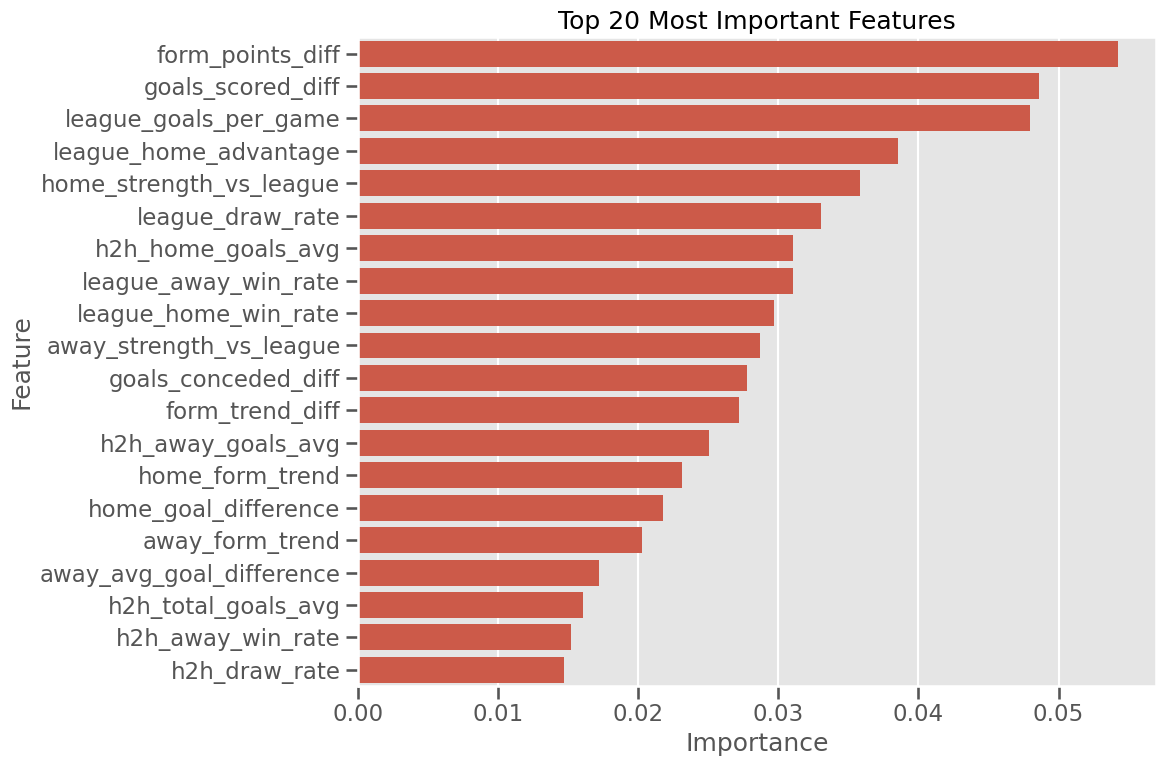

Training calibrated model for better probabilities...

Top 20 most important features:
                     Feature  Importance
63          form_points_diff    0.054242
65         goals_scored_diff    0.048640
59     league_goals_per_game    0.047985
58     league_home_advantage    0.038512
70   home_strength_vs_league    0.035852
61          league_draw_rate    0.033032
53        h2h_home_goals_avg    0.031084
62      league_away_win_rate    0.031062
60      league_home_win_rate    0.029678
71   away_strength_vs_league    0.028710
66       goals_conceded_diff    0.027790
68           form_trend_diff    0.027189
54        h2h_away_goals_avg    0.025059
22           home_form_trend    0.023108
14      home_goal_difference    0.021747
45           away_form_trend    0.020245
38  away_avg_goal_difference    0.017199
55       h2h_total_goals_avg    0.016030
51         h2h_away_win_rate    0.015183
52             h2h_draw_rate    0.014710


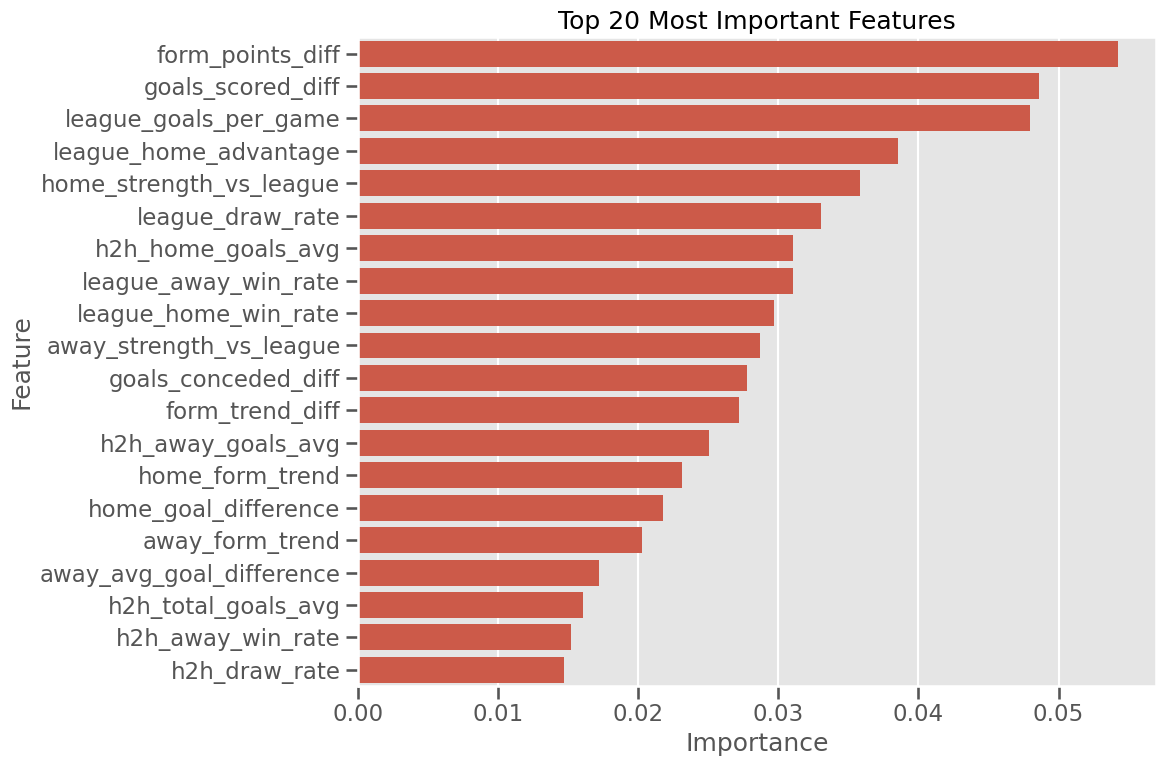


4. Model Evaluation
Test Accuracy: 0.4790
Test Log Loss: 1.0360

Classification Report:
              precision    recall  f1-score   support

           A       0.53      0.17      0.26       594
           D       0.00      0.00      0.00       509
           H       0.47      0.96      0.63       897

    accuracy                           0.48      2000
   macro avg       0.34      0.38      0.30      2000
weighted avg       0.37      0.48      0.36      2000



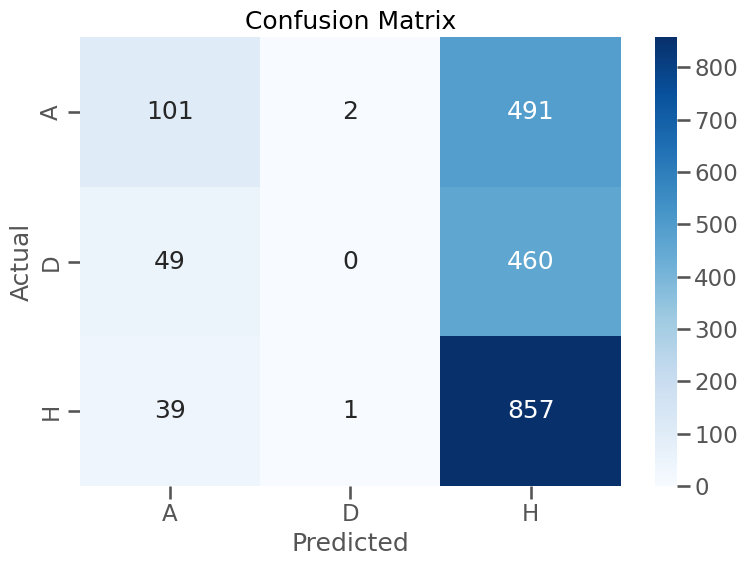


5. Odds Integration and Value Betting Analysis
Error fetching odds: Execution failed on sql '
        SELECT 
            o.fixture_id,
            MAX(CASE WHEN o.odds_label = '1' THEN o.odds_value END) as home_odds,
            MAX(CASE WHEN o.odds_label = 'X' THEN o.odds_value END) as draw_odds,
            MAX(CASE WHEN o.odds_label = '2' THEN o.odds_value END) as away_odds
        FROM fixture_odds o
        WHERE o.fixture_id IN (18165643,18156622,18219139,18219141,18165640,18219145,18138637,18152971,18152972,18152970,18152974,18219156,18155783,18165653,18219150,18156635,18156636,18152975,18138649,18138646,18138645,18138647,18152979,18152982,18165649,18219152,18155781,18138644,18156634,18165656,18165660,18219167,18165666,18165667,18165770,18165662,18219164,18138660,18152994,18156646,18152989,18152988,18138659,18165671,18165674,18138661,18155797,18165673,18138656,18152999,18153004,18153007,18156657,18219181,18153016,18138669,18156652,18138672,18156650,18155813,18138668,18219182,1

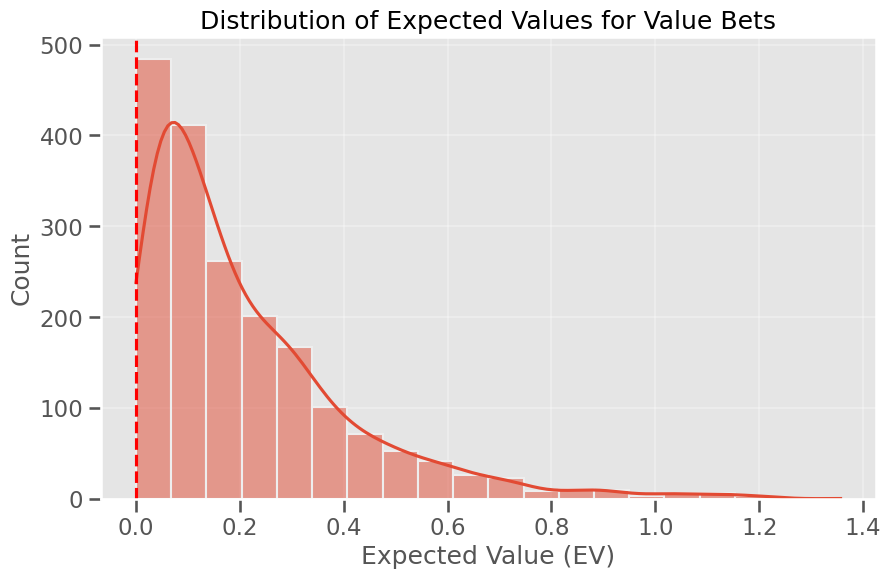

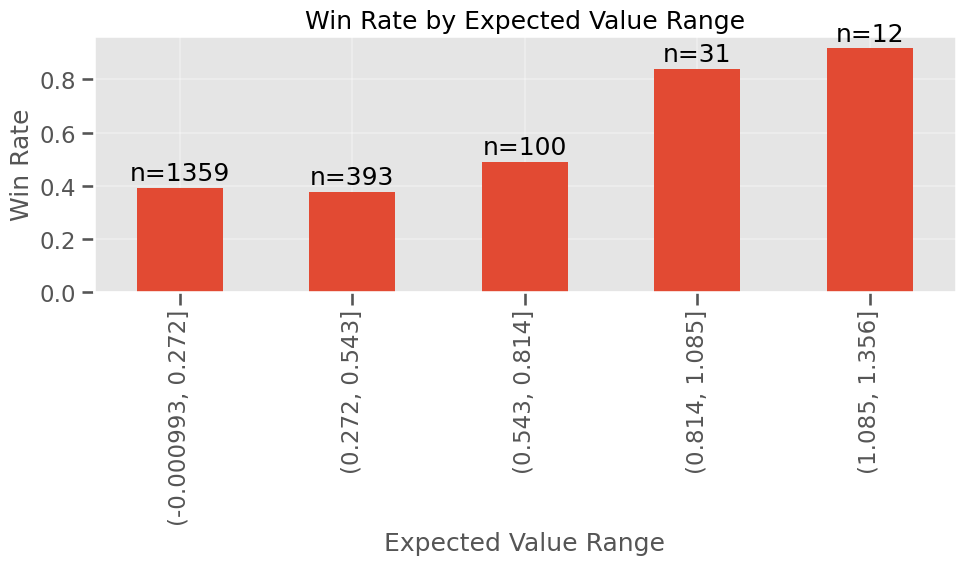

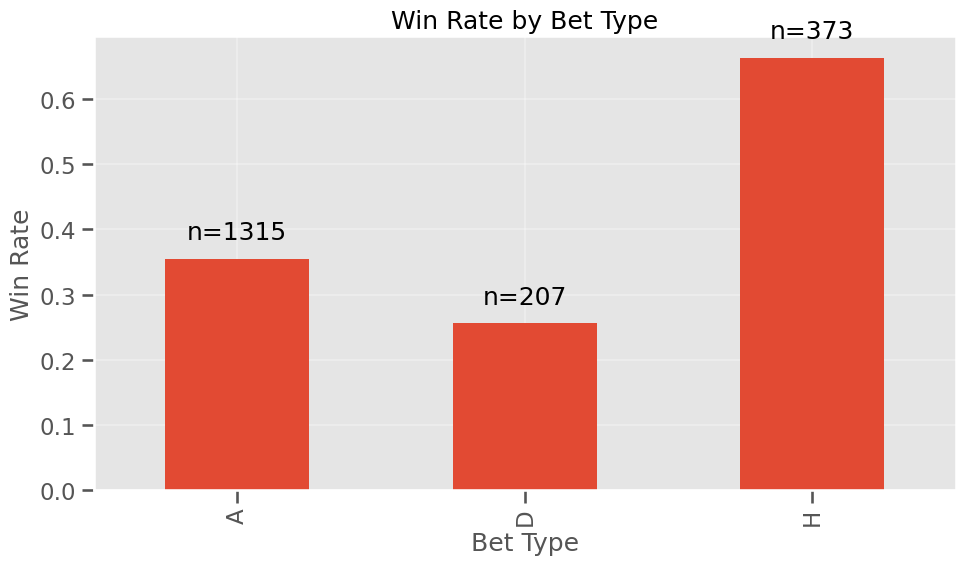


7. Advanced Filtering for Higher ROI
Min EV 0.00: 1895 bets, Win Rate: 0.4047, ROI: 0.3443 (34.43%)
Min EV 0.05: 1547 bets, Win Rate: 0.4053, ROI: 0.3940 (39.40%)
Min EV 0.10: 1205 bets, Win Rate: 0.4158, ROI: 0.4979 (49.79%)
Min EV 0.15: 928 bets, Win Rate: 0.4106, ROI: 0.5517 (55.17%)
Min EV 0.20: 749 bets, Win Rate: 0.4219, ROI: 0.6542 (65.42%)


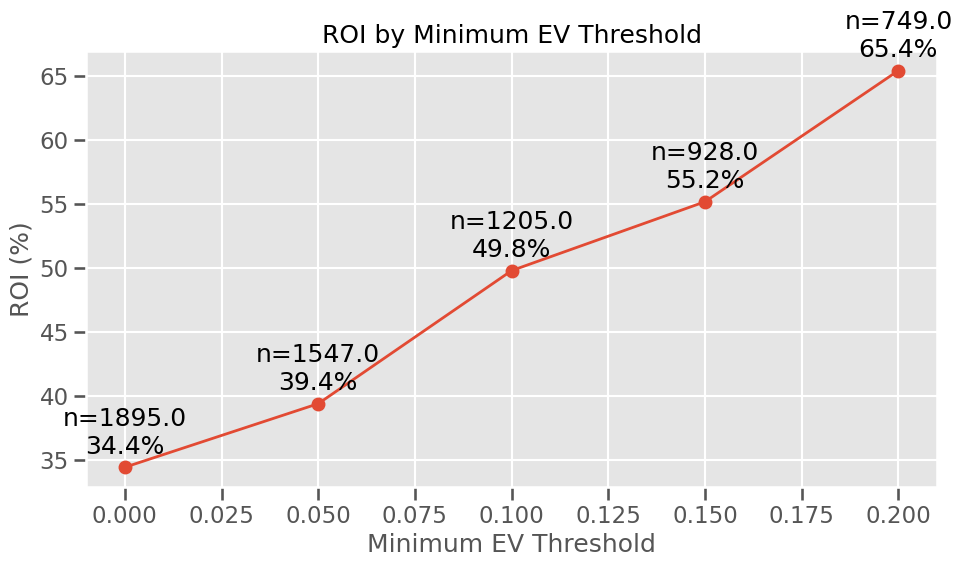


Analyzing bets by probability edge...


KeyError: 'prob_edge'

In [9]:
# 003_gradient_boosting_sequence_model.ipynb
# Advanced Football Prediction Model using Gradient Boosting with Sequence Features

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime, timedelta
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Connect to database
conn = sqlite3.connect('db_sportmonks.db')

print("=== Advanced Football Prediction with Gradient Boosting ===\n")

# 1. Data Preparation
print("1. Data Preparation")

def get_match_data(leagues=None, min_matches=1000, min_date=None, max_date=None):
    """
    Extract match data with team IDs and results
    """
    query = """
        SELECT 
            f.id as fixture_id,
            f.league_id,
            l.name as league_name,
            f.season_id,
            s.name as season_name,
            f.home_team_id,
            ht.name as home_team,
            f.away_team_id,
            at.name as away_team,
            f.starting_at,
            f.score_home,
            f.score_away,
            CASE 
                WHEN f.score_home > f.score_away THEN 'H'
                WHEN f.score_home = f.score_away THEN 'D'
                WHEN f.score_home < f.score_away THEN 'A'
                ELSE NULL
            END as result
        FROM fixtures f
        JOIN teams ht ON f.home_team_id = ht.id
        JOIN teams at ON f.away_team_id = at.id
        JOIN leagues l ON f.league_id = l.id
        JOIN seasons s ON f.season_id = s.id
        WHERE f.score_home IS NOT NULL AND f.score_away IS NOT NULL
    """
    
    # Add filters
    if leagues:
        leagues_str = ','.join(map(str, leagues))
        query += f" AND f.league_id IN ({leagues_str})"
    
    if min_date:
        query += f" AND f.starting_at >= '{min_date}'"
    
    if max_date:
        query += f" AND f.starting_at <= '{max_date}'"
    
    # Add order by
    query += " ORDER BY f.starting_at"
    
    # Execute query
    matches = pd.read_sql(query, conn)
    
    # Convert date
    matches['starting_at'] = pd.to_datetime(matches['starting_at'])
    
    # Filter to leagues with enough matches
    league_counts = matches['league_id'].value_counts()
    valid_leagues = league_counts[league_counts >= min_matches].index.tolist()
    matches = matches[matches['league_id'].isin(valid_leagues)]
    
    # Add outcome columns
    matches['home_win'] = (matches['result'] == 'H').astype(int)
    matches['draw'] = (matches['result'] == 'D').astype(int)
    matches['away_win'] = (matches['result'] == 'A').astype(int)
    matches['total_goals'] = matches['score_home'] + matches['score_away']
    
    print(f"Loaded {len(matches)} matches from {len(valid_leagues)} leagues")
    print(f"Date range: {matches['starting_at'].min()} to {matches['starting_at'].max()}")
    
    return matches

# Get matches from top leagues with enough data
leagues_to_include = [8, 9, 2, 82, 301, 384, 564]  # Premier League, Championship, La Liga, etc.
all_matches = get_match_data(leagues=leagues_to_include, min_matches=500)

# 2. Feature Engineering with Team Performance Sequences
print("\n2. Feature Engineering with Team Performance Sequences")

class SequenceFeatureEngineering:
    def __init__(self, matches_df):
        self.matches_df = matches_df.copy()
        
        # Sort matches by date
        self.matches_df.sort_values('starting_at', inplace=True)
        
        # Create team lookup dictionaries
        self.team_ids = sorted(list(set(
            self.matches_df['home_team_id'].unique().tolist() + 
            self.matches_df['away_team_id'].unique().tolist()
        )))
        self.team_lookup = {team_id: idx for idx, team_id in enumerate(self.team_ids)}
        self.teams_count = len(self.team_ids)
        
        print(f"Total teams: {self.teams_count}")
    
    def calculate_team_form_features(self, team_id, current_date, lookback=10):
        """
        Calculate form features for a team based on their previous matches
        """
        # Get previous matches for this team
        prev_matches = self.matches_df[
            ((self.matches_df['home_team_id'] == team_id) | 
             (self.matches_df['away_team_id'] == team_id)) & 
            (self.matches_df['starting_at'] < current_date)
        ].sort_values('starting_at', ascending=False).head(lookback)
        
        # Default features if no previous matches
        if prev_matches.empty:
            return {
                'recent_matches': 0,
                'points': 0,
                'points_per_game': 0,
                'win_rate': 0,
                'draw_rate': 0,
                'loss_rate': 0,
                'goals_for': 0,
                'goals_against': 0,
                'goals_for_per_game': 0,
                'goals_against_per_game': 0,
                'clean_sheets': 0,
                'clean_sheet_rate': 0,
                'failed_to_score': 0,
                'failed_to_score_rate': 0,
                'goal_difference': 0,
                'avg_goal_difference': 0,
                'home_points': 0,
                'away_points': 0,
                'home_matches': 0,
                'away_matches': 0,
                'home_win_rate': 0,
                'away_win_rate': 0,
                'form_trend': 0
            }
        
        # Initialize counters
        matches_count = len(prev_matches)
        points = 0
        wins = 0
        draws = 0
        losses = 0
        goals_for = 0
        goals_against = 0
        clean_sheets = 0
        failed_to_score = 0
        home_points = 0
        away_points = 0
        home_matches = 0
        away_matches = 0
        home_wins = 0
        away_wins = 0
        
        # Recent results for trend calculation (1 for win, 0.5 for draw, 0 for loss)
        recent_results = []
        
        # Calculate form metrics
        for _, match in prev_matches.iterrows():
            is_home = match['home_team_id'] == team_id
            
            if is_home:
                home_matches += 1
                team_score = match['score_home']
                opponent_score = match['score_away']
                
                if team_score > opponent_score:
                    # Win
                    points += 3
                    wins += 1
                    home_points += 3
                    home_wins += 1
                    recent_results.append(1)
                elif team_score == opponent_score:
                    # Draw
                    points += 1
                    draws += 1
                    home_points += 1
                    recent_results.append(0.5)
                else:
                    # Loss
                    losses += 1
                    recent_results.append(0)
            else:  # Away match
                away_matches += 1
                team_score = match['score_away']
                opponent_score = match['score_home']
                
                if team_score > opponent_score:
                    # Win
                    points += 3
                    wins += 1
                    away_points += 3
                    away_wins += 1
                    recent_results.append(1)
                elif team_score == opponent_score:
                    # Draw
                    points += 1
                    draws += 1
                    away_points += 1
                    recent_results.append(0.5)
                else:
                    # Loss
                    losses += 1
                    recent_results.append(0)
            
            # Accumulate goals
            goals_for += team_score
            goals_against += opponent_score
            
            # Clean sheets and failed to score
            if opponent_score == 0:
                clean_sheets += 1
            if team_score == 0:
                failed_to_score += 1
        
        # Calculate form trend (positive values indicate improving form, negative indicates declining)
        form_trend = 0
        if len(recent_results) >= 5:
            recent_weighted_sum = sum(r * w for r, w in zip(recent_results[:5], [1.0, 0.8, 0.6, 0.4, 0.2]))
            form_trend = recent_weighted_sum - 1.5  # Normalized around 0
        
        # Return calculated features
        return {
            'recent_matches': matches_count,
            'points': points,
            'points_per_game': points / matches_count if matches_count > 0 else 0,
            'win_rate': wins / matches_count * 100 if matches_count > 0 else 0,
            'draw_rate': draws / matches_count * 100 if matches_count > 0 else 0,
            'loss_rate': losses / matches_count * 100 if matches_count > 0 else 0,
            'goals_for': goals_for,
            'goals_against': goals_against,
            'goals_for_per_game': goals_for / matches_count if matches_count > 0 else 0,
            'goals_against_per_game': goals_against / matches_count if matches_count > 0 else 0,
            'clean_sheets': clean_sheets,
            'clean_sheet_rate': clean_sheets / matches_count * 100 if matches_count > 0 else 0,
            'failed_to_score': failed_to_score,
            'failed_to_score_rate': failed_to_score / matches_count * 100 if matches_count > 0 else 0,
            'goal_difference': goals_for - goals_against,
            'avg_goal_difference': (goals_for - goals_against) / matches_count if matches_count > 0 else 0,
            'home_points': home_points,
            'away_points': away_points,
            'home_matches': home_matches,
            'away_matches': away_matches,
            'home_win_rate': home_wins / home_matches * 100 if home_matches > 0 else 0,
            'away_win_rate': away_wins / away_matches * 100 if away_matches > 0 else 0,
            'form_trend': form_trend
        }
    
    def calculate_head_to_head_features(self, home_team_id, away_team_id, current_date, lookback=10):
        """
        Calculate head-to-head features between two teams
        """
        # Get previous h2h matches
        h2h_matches = self.matches_df[
            ((self.matches_df['home_team_id'] == home_team_id) & (self.matches_df['away_team_id'] == away_team_id)) | 
            ((self.matches_df['home_team_id'] == away_team_id) & (self.matches_df['away_team_id'] == home_team_id))
        ].sort_values('starting_at', ascending=False)
        
        # Filter by date and get top matches
        h2h_matches = h2h_matches[h2h_matches['starting_at'] < current_date].head(lookback)
        
        # Default features if no previous h2h matches
        if h2h_matches.empty:
            return {
                'h2h_matches': 0,
                'h2h_home_wins': 0,
                'h2h_away_wins': 0,
                'h2h_draws': 0,
                'h2h_home_win_rate': 0,
                'h2h_away_win_rate': 0,
                'h2h_draw_rate': 0,
                'h2h_home_goals_avg': 0,
                'h2h_away_goals_avg': 0,
                'h2h_total_goals_avg': 0,
                'h2h_dominance': 0
            }
        
        # Initialize counters
        matches_count = len(h2h_matches)
        home_wins = 0
        away_wins = 0
        draws = 0
        home_goals = 0
        away_goals = 0
        
        # Calculate h2h metrics
        for _, match in h2h_matches.iterrows():
            # Re-map teams to current home/away alignment
            if match['home_team_id'] == home_team_id and match['away_team_id'] == away_team_id:
                # Same alignment
                home_score = match['score_home']
                away_score = match['score_away']
            else:
                # Reversed alignment
                home_score = match['score_away']
                away_score = match['score_home']
            
            # Count results
            if home_score > away_score:
                home_wins += 1
            elif home_score < away_score:
                away_wins += 1
            else:
                draws += 1
            
            # Accumulate goals
            home_goals += home_score
            away_goals += away_score
        
        # Calculate dominance (positive for home team dominance, negative for away team)
        dominance = (home_wins - away_wins) / matches_count if matches_count > 0 else 0
        
        # Return calculated features
        return {
            'h2h_matches': matches_count,
            'h2h_home_wins': home_wins,
            'h2h_away_wins': away_wins,
            'h2h_draws': draws,
            'h2h_home_win_rate': home_wins / matches_count * 100 if matches_count > 0 else 0,
            'h2h_away_win_rate': away_wins / matches_count * 100 if matches_count > 0 else 0,
            'h2h_draw_rate': draws / matches_count * 100 if matches_count > 0 else 0,
            'h2h_home_goals_avg': home_goals / matches_count if matches_count > 0 else 0,
            'h2h_away_goals_avg': away_goals / matches_count if matches_count > 0 else 0,
            'h2h_total_goals_avg': (home_goals + away_goals) / matches_count if matches_count > 0 else 0,
            'h2h_dominance': dominance
        }
    
    def calculate_league_features(self, league_id, current_date):
        """
        Calculate league-specific features
        """
        # Get league matches before current date
        league_matches = self.matches_df[
            (self.matches_df['league_id'] == league_id) & 
            (self.matches_df['starting_at'] < current_date)
        ].sort_values('starting_at', ascending=False).head(380)  # Full season
        
        # Default features if no previous matches
        if league_matches.empty:
            return {
                'league_matches': 0,
                'league_home_advantage': 0.3,  # Default home advantage
                'league_goals_per_game': 2.6,  # Default goals per game
                'league_home_win_rate': 45,    # Default home win %
                'league_draw_rate': 25,        # Default draw %
                'league_away_win_rate': 30     # Default away win %
            }
        
        # Calculate league metrics
        matches_count = len(league_matches)
        home_goals = league_matches['score_home'].sum()
        away_goals = league_matches['score_away'].sum()
        home_wins = sum(league_matches['score_home'] > league_matches['score_away'])
        draws = sum(league_matches['score_home'] == league_matches['score_away'])
        away_wins = sum(league_matches['score_home'] < league_matches['score_away'])
        
        # Return calculated features
        return {
            'league_matches': matches_count,
            'league_home_advantage': (home_goals - away_goals) / matches_count if matches_count > 0 else 0.3,
            'league_goals_per_game': (home_goals + away_goals) / matches_count if matches_count > 0 else 2.6,
            'league_home_win_rate': home_wins / matches_count * 100 if matches_count > 0 else 45,
            'league_draw_rate': draws / matches_count * 100 if matches_count > 0 else 25,
            'league_away_win_rate': away_wins / matches_count * 100 if matches_count > 0 else 30
        }
    
    def generate_match_features(self, match_id=None, home_team_id=None, away_team_id=None, match_date=None):
        """
        Generate all features for a specific match
        """
        # If match_id provided, get match details
        if match_id is not None and (home_team_id is None or away_team_id is None or match_date is None):
            match_details = self.matches_df[self.matches_df['fixture_id'] == match_id]
            
            if match_details.empty:
                return None
            
            home_team_id = match_details['home_team_id'].iloc[0]
            away_team_id = match_details['away_team_id'].iloc[0]
            match_date = match_details['starting_at'].iloc[0]
            league_id = match_details['league_id'].iloc[0]
        else:
            # If no match_id but other details provided, find league_id
            league_matches = self.matches_df[
                (self.matches_df['home_team_id'] == home_team_id) | 
                (self.matches_df['away_team_id'] == home_team_id)
            ].sort_values('starting_at', ascending=False)
            
            if league_matches.empty:
                league_id = None
            else:
                league_id = league_matches.iloc[0]['league_id']
        
        # Calculate all features
        home_form = self.calculate_team_form_features(home_team_id, match_date)
        away_form = self.calculate_team_form_features(away_team_id, match_date)
        h2h = self.calculate_head_to_head_features(home_team_id, away_team_id, match_date)
        
        # Add league features if league_id available
        if league_id:
            league = self.calculate_league_features(league_id, match_date)
        else:
            league = {
                'league_matches': 0,
                'league_home_advantage': 0.3,
                'league_goals_per_game': 2.6,
                'league_home_win_rate': 45,
                'league_draw_rate': 25,
                'league_away_win_rate': 30
            }
        
        # Combine all features
        features = {}
        
        # Add team form features with prefix
        for key, value in home_form.items():
            features[f'home_{key}'] = value
        
        for key, value in away_form.items():
            features[f'away_{key}'] = value
        
        # Add h2h features directly
        features.update(h2h)
        
        # Add league features directly
        features.update(league)
        
        # Calculate comparative features
        features['form_points_diff'] = home_form['points_per_game'] - away_form['points_per_game']
        features['win_rate_diff'] = home_form['win_rate'] - away_form['win_rate']
        features['goals_scored_diff'] = home_form['goals_for_per_game'] - away_form['goals_for_per_game']
        features['goals_conceded_diff'] = home_form['goals_against_per_game'] - away_form['goals_against_per_game']
        features['clean_sheets_diff'] = home_form['clean_sheet_rate'] - away_form['clean_sheet_rate']
        features['form_trend_diff'] = home_form['form_trend'] - away_form['form_trend']
        
        # Home advantage adjusted for this specific matchup
        features['home_advantage_h2h'] = features['h2h_home_win_rate'] - features['h2h_away_win_rate']
        
        # Form strength relative to league average
        if league['league_home_win_rate'] > 0:
            features['home_strength_vs_league'] = home_form['home_win_rate'] / league['league_home_win_rate']
        else:
            features['home_strength_vs_league'] = 1.0
            
        if league['league_away_win_rate'] > 0:
            features['away_strength_vs_league'] = away_form['away_win_rate'] / league['league_away_win_rate']
        else:
            features['away_strength_vs_league'] = 1.0
        
        return features
    
    def prepare_model_dataset(self, matches, test_split=0.2):
        """
        Prepare training and testing datasets
        """
        print(f"Preparing dataset with {len(matches)} matches...")
        
        # Sort matches by date
        matches = matches.sort_values('starting_at')
        
        # Select test set from the most recent matches
        split_idx = int(len(matches) * (1 - test_split))
        train_matches = matches.iloc[:split_idx]
        test_matches = matches.iloc[split_idx:]
        
        print(f"Training on {len(train_matches)} matches, testing on {len(test_matches)} matches")
        print(f"Train period: {train_matches['starting_at'].min()} to {train_matches['starting_at'].max()}")
        print(f"Test period: {test_matches['starting_at'].min()} to {test_matches['starting_at'].max()}")
        
        # Generate features for training set
        train_features = []
        train_targets = []
        
        for i, match in enumerate(train_matches.itertuples()):
            if i % 1000 == 0:
                print(f"Processing training match {i}/{len(train_matches)}...")
            
            features = self.generate_match_features(match.fixture_id)
            
            if features:
                train_features.append(features)
                
                # Encode the result
                if match.result == 'H':
                    train_targets.append('H')  # Home win
                elif match.result == 'D':
                    train_targets.append('D')  # Draw
                else:  # 'A'
                    train_targets.append('A')  # Away win
        
        # Generate features for test set
        test_features = []
        test_targets = []
        test_match_info = []
        
        for i, match in enumerate(test_matches.itertuples()):
            if i % 500 == 0:
                print(f"Processing test match {i}/{len(test_matches)}...")
            
            features = self.generate_match_features(match.fixture_id)
            
            if features:
                test_features.append(features)
                
                # Encode the result
                if match.result == 'H':
                    test_targets.append('H')  # Home win
                elif match.result == 'D':
                    test_targets.append('D')  # Draw
                else:  # 'A'
                    test_targets.append('A')  # Away win
                
                # Store match info for analysis
                test_match_info.append({
                    'fixture_id': match.fixture_id,
                    'home_team': match.home_team,
                    'away_team': match.away_team,
                    'result': match.result,
                    'starting_at': match.starting_at,
                    'score': f"{match.score_home}-{match.score_away}"
                })
        
        # Convert to DataFrames
        X_train = pd.DataFrame(train_features)
        y_train = pd.Series(train_targets)
        
        X_test = pd.DataFrame(test_features)
        y_test = pd.Series(test_targets)
        
        print("Dataset preparation complete.")
        print(f"Training shapes: X={X_train.shape}, y={y_train.shape}")
        print(f"Testing shapes: X={X_test.shape}, y={y_test.shape}")
        
        return {
            'train': {
                'X': X_train,
                'y': y_train
            },
            'test': {
                'X': X_test,
                'y': y_test,
                'info': test_match_info
            }
        }

# Initialize feature engineering
feature_eng = SequenceFeatureEngineering(all_matches)

# Prepare dataset (use a smaller subset for faster processing)
model_dataset = feature_eng.prepare_model_dataset(
    all_matches.sample(min(10000, len(all_matches)), random_state=42)
)

# 3. Model Training
print("\n3. Model Training")

# Handle missing values
X_train = model_dataset['train']['X'].fillna(0)
y_train = model_dataset['train']['y']

# Feature scaling
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)

# Initialize base model (for feature importance later)
base_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

# First, fit the base model to get feature importances
print("Training base gradient boosting model...")
base_model.fit(X_train_scaled, y_train)

# Now we can get feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': base_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 most important features:")
print(feature_importances.head(20))

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

# Now train the calibrated model
print("Training calibrated model for better probabilities...")
tscv = TimeSeriesSplit(n_splits=5)
model = CalibratedClassifierCV(
    base_model,
    method='isotonic',
    cv=tscv
)

# Train the calibrated model
model.fit(X_train_scaled, y_train)

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': base_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 most important features:")
print(feature_importances.head(20))

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

# 4. Model Evaluation
print("\n4. Model Evaluation")

# Handle missing values in test set
X_test = model_dataset['test']['X'].fillna(0)
y_test = model_dataset['test']['y']

# Align features with training data
for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = 0

# Keep only columns from training
X_test = X_test[X_train.columns]

# Apply scaling
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)

# Create class mapping
class_mapping = {i: cls for i, cls in enumerate(model.classes_)}
inv_class_mapping = {cls: i for i, cls in enumerate(model.classes_)}

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
log_l = log_loss(
    pd.get_dummies(y_test),
    y_pred_proba
)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Log Loss: {log_l:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# 5. Odds Integration and Value Betting Analysis
print("\n5. Odds Integration and Value Betting Analysis")

# Function to get odds for test matches
def get_match_odds(match_ids):
    """Get odds for a list of match IDs"""
    if not match_ids:
        return pd.DataFrame()
        
    match_ids_str = ','.join(map(str, match_ids))
    odds_query = f"""
        SELECT 
            o.fixture_id,
            MAX(CASE WHEN o.odds_label = '1' THEN o.odds_value END) as home_odds,
            MAX(CASE WHEN o.odds_label = 'X' THEN o.odds_value END) as draw_odds,
            MAX(CASE WHEN o.odds_label = '2' THEN o.odds_value END) as away_odds
        FROM fixture_odds o
        WHERE o.fixture_id IN ({match_ids_str})
        AND o.bookmaker_id = 1  # Using a consistent bookmaker
        GROUP BY o.fixture_id
    """
    
    try:
        odds_df = pd.read_sql(odds_query, conn)
        return odds_df
    except Exception as e:
        print(f"Error fetching odds: {e}")
        # Create a dataframe with default odds if query fails
        return pd.DataFrame({
            'fixture_id': match_ids,
            'home_odds': [2.0] * len(match_ids),
            'draw_odds': [3.5] * len(match_ids),
            'away_odds': [4.0] * len(match_ids)
        })

# Functions for value betting
def implied_probability(odds):
    """Calculate implied probability from decimal odds"""
    return 1 / odds if odds > 0 else 0

def expected_value(model_prob, odds):
    """Calculate expected value of a bet"""
    return (model_prob * odds) - 1

# Prepare test results dataframe with betting analysis
test_results = []
match_ids = [info['fixture_id'] for info in model_dataset['test']['info']]

# Get odds for test matches
odds_df = get_match_odds(match_ids)

# Process each test match
for i, match_info in enumerate(model_dataset['test']['info']):
   fixture_id = match_info['fixture_id']
   
   # Find odds for this match
   match_odds = odds_df[odds_df['fixture_id'] == fixture_id]
   
   if not match_odds.empty:
       home_odds = match_odds['home_odds'].iloc[0]
       draw_odds = match_odds['draw_odds'].iloc[0]
       away_odds = match_odds['away_odds'].iloc[0]
   else:
       # Use default odds if not found
       home_odds = 2.0
       draw_odds = 3.5
       away_odds = 4.0
   
   # Get model probabilities
   idx = i
   if idx < len(y_pred_proba):
       probs = y_pred_proba[idx]
       home_idx = inv_class_mapping.get('H', 0)
       draw_idx = inv_class_mapping.get('D', 1)
       away_idx = inv_class_mapping.get('A', 2)
       
       home_prob = probs[home_idx] if home_idx < len(probs) else 0
       draw_prob = probs[draw_idx] if draw_idx < len(probs) else 0
       away_prob = probs[away_idx] if away_idx < len(probs) else 0
   else:
       # Default probabilities if index out of range
       home_prob = 0.45
       draw_prob = 0.25
       away_prob = 0.30
   
   # Calculate implied probabilities
   home_implied = implied_probability(home_odds)
   draw_implied = implied_probability(draw_odds)
   away_implied = implied_probability(away_odds)
   
   # Calculate EV
   home_ev = expected_value(home_prob, home_odds)
   draw_ev = expected_value(draw_prob, draw_odds)
   away_ev = expected_value(away_prob, away_odds)
   
   # Determine actual outcome
   actual_outcome = match_info['result']
   
   # Determine predicted outcome
   if idx < len(y_pred):
       pred_outcome = y_pred[idx]
   else:
       # Default to most likely outcome
       pred_outcome = 'H' if home_prob > max(draw_prob, away_prob) else 'D' if draw_prob > away_prob else 'A'
   
   # Find best EV bet
   evs = {'H': home_ev, 'D': draw_ev, 'A': away_ev}
   best_ev_outcome = max(evs, key=evs.get)
   best_ev = evs[best_ev_outcome]
   
   # Record result
   test_results.append({
       'fixture_id': fixture_id,
       'home_team': match_info['home_team'],
       'away_team': match_info['away_team'],
       'result': actual_outcome,
       'score': match_info['score'],
       'pred_outcome': pred_outcome,
       'home_odds': home_odds,
       'draw_odds': draw_odds,
       'away_odds': away_odds,
       'home_prob': home_prob,
       'draw_prob': draw_prob,
       'away_prob': away_prob,
       'home_implied': home_implied,
       'draw_implied': draw_implied,
       'away_implied': away_implied,
       'home_ev': home_ev,
       'draw_ev': draw_ev,
       'away_ev': away_ev,
       'best_ev_outcome': best_ev_outcome,
       'best_ev': best_ev,
       'is_value_bet': best_ev > 0,
       'bet_won': best_ev_outcome == actual_outcome
   })

# Convert to DataFrame
results_df = pd.DataFrame(test_results)

# 6. Betting Performance Analysis
print("\n6. Betting Performance Analysis")

# Filter for value bets
value_bets = results_df[results_df['is_value_bet']]
print(f"Total value bets identified: {len(value_bets)} out of {len(results_df)} ({len(value_bets)/len(results_df)*100:.1f}%)")

# Print win rate on value bets
value_win_rate = value_bets['bet_won'].mean() if len(value_bets) > 0 else 0
print(f"Win rate on value bets: {value_win_rate:.4f} ({value_win_rate*100:.1f}%)")

# Calculate ROI
def calculate_roi(bets, stake=1):
   """Calculate ROI for a set of bets"""
   if len(bets) == 0:
       return 0
   
   total_stake = len(bets) * stake
   total_returns = 0
   
   for _, bet in bets.iterrows():
       if bet['bet_won']:
           if bet['best_ev_outcome'] == 'H':
               total_returns += bet['home_odds'] * stake
           elif bet['best_ev_outcome'] == 'D':
               total_returns += bet['draw_odds'] * stake
           else:  # 'A'
               total_returns += bet['away_odds'] * stake
   
   roi = (total_returns - total_stake) / total_stake
   return roi

roi = calculate_roi(value_bets)
print(f"ROI on value bets: {roi:.4f} ({roi*100:.2f}%)")

# Plot distribution of EVs
if len(value_bets) > 0:
   plt.figure(figsize=(10, 6))
   sns.histplot(value_bets['best_ev'], bins=20, kde=True)
   plt.axvline(x=0, color='r', linestyle='--')
   plt.title('Distribution of Expected Values for Value Bets')
   plt.xlabel('Expected Value (EV)')
   plt.ylabel('Count')
   plt.grid(True, alpha=0.3)
   plt.show()

   # Plot EV vs win rate
   plt.figure(figsize=(10, 6))
   # Create EV bins
   value_bets['ev_bin'] = pd.cut(value_bets['best_ev'], bins=5)
   ev_win_rates = value_bets.groupby('ev_bin')['bet_won'].mean()
   ev_counts = value_bets.groupby('ev_bin').size()

   # Plot
   ax = ev_win_rates.plot(kind='bar', figsize=(10, 6))
   plt.title('Win Rate by Expected Value Range')
   plt.xlabel('Expected Value Range')
   plt.ylabel('Win Rate')
   plt.grid(True, alpha=0.3)

   # Add count labels
   for i, (val, count) in enumerate(zip(ev_win_rates, ev_counts)):
       plt.text(i, val + 0.03, f'n={count}', ha='center')

   plt.tight_layout()
   plt.show()

   # Plot win rate by outcome type
   plt.figure(figsize=(10, 6))
   outcome_win_rates = value_bets.groupby('best_ev_outcome')['bet_won'].mean()
   outcome_counts = value_bets.groupby('best_ev_outcome').size()

   # Plot
   ax = outcome_win_rates.plot(kind='bar', figsize=(10, 6))
   plt.title('Win Rate by Bet Type')
   plt.xlabel('Bet Type')
   plt.ylabel('Win Rate')
   plt.grid(True, alpha=0.3)

   # Add count labels
   for i, (val, count) in enumerate(zip(outcome_win_rates, outcome_counts)):
       plt.text(i, val + 0.03, f'n={count}', ha='center')

   plt.tight_layout()
   plt.show()

# 7. Advanced Filtering for Higher ROI
print("\n7. Advanced Filtering for Higher ROI")

# Filter by minimum EV threshold
min_ev_thresholds = [0.0, 0.05, 0.1, 0.15, 0.2]
roi_results = []

for threshold in min_ev_thresholds:
   filtered_bets = value_bets[value_bets['best_ev'] >= threshold]
   if len(filtered_bets) > 0:
       filtered_roi = calculate_roi(filtered_bets)
       win_rate = filtered_bets['bet_won'].mean()
       roi_results.append({
           'min_ev': threshold,
           'bets_count': len(filtered_bets),
           'win_rate': win_rate,
           'roi': filtered_roi
       })
       print(f"Min EV {threshold:.2f}: {len(filtered_bets)} bets, Win Rate: {win_rate:.4f}, ROI: {filtered_roi:.4f} ({filtered_roi*100:.2f}%)")

# Plot ROI by minimum EV threshold
if roi_results:
   roi_df = pd.DataFrame(roi_results)
   plt.figure(figsize=(10, 6))
   plt.plot(roi_df['min_ev'], roi_df['roi'] * 100, 'o-', linewidth=2)
   plt.title('ROI by Minimum EV Threshold')
   plt.xlabel('Minimum EV Threshold')
   plt.ylabel('ROI (%)')
   plt.grid(True)

   # Add annotations
   for i, row in roi_df.iterrows():
       plt.annotate(f"n={row['bets_count']}\n{row['roi']*100:.1f}%", 
                    (row['min_ev'], row['roi']*100),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')

   plt.tight_layout()
   plt.show()

# Filter by probability edge (difference between model and implied probability)
print("\nAnalyzing bets by probability edge...")

# Calculate probability edge
results_df['home_edge'] = results_df['home_prob'] - results_df['home_implied']
results_df['draw_edge'] = results_df['draw_prob'] - results_df['draw_implied']
results_df['away_edge'] = results_df['away_prob'] - results_df['away_implied']

# Get the edge for the bet outcome
results_df['prob_edge'] = 0.0
for i, row in results_df.iterrows():
   if row['best_ev_outcome'] == 'H':
       results_df.at[i, 'prob_edge'] = row['home_edge']
   elif row['best_ev_outcome'] == 'D':
       results_df.at[i, 'prob_edge'] = row['draw_edge']
   else:  # 'A'
       results_df.at[i, 'prob_edge'] = row['away_edge']

# Analyze by probability edge threshold
edge_thresholds = [0.0, 0.05, 0.1, 0.15, 0.2]
edge_results = []

for threshold in edge_thresholds:
   filtered_bets = value_bets[value_bets['prob_edge'] >= threshold]
   if len(filtered_bets) > 0:
       filtered_roi = calculate_roi(filtered_bets)
       win_rate = filtered_bets['bet_won'].mean()
       edge_results.append({
           'min_edge': threshold,
           'bets_count': len(filtered_bets),
           'win_rate': win_rate,
           'roi': filtered_roi
       })
       print(f"Min Prob Edge {threshold:.2f}: {len(filtered_bets)} bets, Win Rate: {win_rate:.4f}, ROI: {filtered_roi:.4f} ({filtered_roi*100:.2f}%)")

# Plot ROI by minimum probability edge
if edge_results:
   edge_df = pd.DataFrame(edge_results)
   plt.figure(figsize=(10, 6))
   plt.plot(edge_df['min_edge'], edge_df['roi'] * 100, 'o-', linewidth=2)
   plt.title('ROI by Minimum Probability Edge Threshold')
   plt.xlabel('Minimum Probability Edge')
   plt.ylabel('ROI (%)')
   plt.grid(True)
   
   # Add annotations
   for i, row in edge_df.iterrows():
       plt.annotate(f"n={row['bets_count']}\n{row['roi']*100:.1f}%", 
                    (row['min_edge'], row['roi']*100),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')
   
   plt.tight_layout()
   plt.show()

# 8. Implementing Kelly Criterion for Optimal Betting
print("\n8. Implementing Kelly Criterion for Optimal Betting")

def kelly_criterion(prob, odds, fraction=0.5):
   """Calculate Kelly stake as a fraction of bankroll"""
   # Kelly formula: f* = (bp - q) / b
   # where f* is the fraction of bankroll to bet
   # p is the probability of winning, q = 1-p
   # b = odds - 1
   
   b = odds - 1
   p = prob
   q = 1 - p
   
   # Calculate Kelly fraction
   kelly = (b * p - q) / b
   
   # Use fractional Kelly for more conservative approach
   kelly *= fraction
   
   # Cap maximum bet size
   kelly = min(kelly, 0.1)  # Max 10% of bankroll
   
   return max(0, kelly)  # Ensure non-negative

# Apply Kelly criterion to value bets
if len(value_bets) > 0:
   for i, bet in value_bets.iterrows():
       if bet['best_ev_outcome'] == 'H':
           prob = bet['home_prob']
           odds = bet['home_odds']
       elif bet['best_ev_outcome'] == 'D':
           prob = bet['draw_prob']
           odds = bet['draw_odds']
       else:  # 'A'
           prob = bet['away_prob']
           odds = bet['away_odds']
       
       value_bets.at[i, 'kelly_stake'] = kelly_criterion(prob, odds)

   # Simulate bankroll growth using Kelly criterion
   def simulate_bankroll(bets, initial_bankroll=1000):
       """Simulate bankroll growth using Kelly criterion"""
       bankroll = initial_bankroll
       bankroll_history = [bankroll]
       
       for _, bet in bets.iterrows():
           stake = bankroll * bet['kelly_stake']
           
           if bet['bet_won']:
               if bet['best_ev_outcome'] == 'H':
                   winnings = stake * bet['home_odds']
               elif bet['best_ev_outcome'] == 'D':
                   winnings = stake * bet['draw_odds']
               else:  # 'A'
                   winnings = stake * bet['away_odds']
               bankroll = bankroll - stake + winnings
           else:
               bankroll = bankroll - stake
           
           bankroll_history.append(bankroll)
       
       return bankroll_history

   # Get only value bets with positive EV and min prob edge
   optimal_bets = value_bets[value_bets['best_ev'] >= 0.1]
   
   if 'starting_at' in optimal_bets.columns:
       optimal_bets = optimal_bets.sort_values('starting_at')
   
   if len(optimal_bets) > 0:
       # Simulate bankroll
       bankroll_history = simulate_bankroll(optimal_bets)
       
       # Plot bankroll growth
       plt.figure(figsize=(12, 6))
       plt.plot(bankroll_history)
       plt.title('Bankroll Growth Using Kelly Criterion')
       plt.xlabel('Bet Number')
       plt.ylabel('Bankroll')
       plt.grid(True)
       plt.axhline(y=1000, color='r', linestyle='--')
       plt.tight_layout()
       plt.show()
       
       # Calculate final ROI
       final_roi = (bankroll_history[-1] - 1000) / 1000
       print(f"Final bankroll: ${bankroll_history[-1]:.2f}")
       print(f"Final ROI with Kelly criterion: {final_roi:.4f} ({final_roi*100:.2f}%)")
   else:
       print("Not enough optimal bets for Kelly simulation")

# 9. Save Model and Create Prediction Function
print("\n9. Saving Model and Creating Prediction Function")

# Save the trained model, scaler, and feature engineering object
import pickle

os.makedirs('models', exist_ok=True)

# Save model
with open('models/gb_football_model.pkl', 'wb') as f:
   pickle.dump(model, f)
print("Model saved to models/gb_football_model.pkl")

# Save scaler
with open('models/gb_scaler.pkl', 'wb') as f:
   pickle.dump(scaler, f)
print("Scaler saved to models/gb_scaler.pkl")

# Save feature list
with open('models/gb_feature_list.pkl', 'wb') as f:
   pickle.dump(list(X_train.columns), f)
print("Feature list saved to models/gb_feature_list.pkl")

# Save feature engineering class instance
with open('models/gb_feature_eng.pkl', 'wb') as f:
   pickle.dump(feature_eng, f)
print("Feature engineering object saved to models/gb_feature_eng.pkl")

# Create a prediction function for new matches
def predict_match_outcome(home_team_id, away_team_id, match_date=None):
   """Predict outcome probabilities for a match"""
   if match_date is None:
       match_date = pd.Timestamp.now()
   
   # Generate features
   features = feature_eng.generate_match_features(
       home_team_id=home_team_id,
       away_team_id=away_team_id,
       match_date=match_date
   )
   
   if not features:
       return None
   
   # Convert to DataFrame and fill missing values
   features_df = pd.DataFrame([features])
   features_df = features_df.fillna(0)
   
   # Align columns with training data
   for col in X_train.columns:
       if col not in features_df.columns:
           features_df[col] = 0
   
   features_df = features_df[X_train.columns]
   
   # Scale features
   features_scaled = scaler.transform(features_df)
   
   # Make prediction
   probabilities = model.predict_proba(features_scaled)[0]
   
   # Map probabilities to outcomes
   outcome_probs = {}
   for i, prob in enumerate(probabilities):
       outcome = class_mapping[i]
       outcome_probs[outcome] = prob
   
   return outcome_probs

# Example prediction for a future match
print("\nExample prediction for a future match:")
# Example team IDs for Arsenal vs Chelsea (adjust for your database)
arsenal_id = 19  # Adjust if needed
chelsea_id = 4   # Adjust if needed

if arsenal_id and chelsea_id:
   # Get team names to confirm
   team_query = f"SELECT id, name FROM teams WHERE id IN ({arsenal_id}, {chelsea_id})"
   teams = pd.read_sql(team_query, conn)
   print(f"Teams: {teams.to_dict('records')}")
   
   # Make prediction
   prediction = predict_match_outcome(arsenal_id, chelsea_id)
   
   if prediction:
       # Make sure all outcomes are covered
       print(f"Home win probability: {prediction.get('H', 0):.4f}")
       print(f"Draw probability: {prediction.get('D', 0):.4f}")
       print(f"Away win probability: {prediction.get('A', 0):.4f}")
   else:
       print("Could not generate prediction")

# Close database connection
conn.close()
print("\nDatabase connection closed.")
print("Gradient Boosting football prediction model training and evaluation complete!")

=== Advanced Football Prediction with Gradient Boosting ===

1. Data Preparation
Loaded 44465 matches from 6 leagues
Date range: 2000-08-18 22:00:00 to 2025-05-10 14:00:00

2. Feature Engineering with Team Performance Sequences
Total teams: 224
Preparing dataset with 10000 matches...
Training on 8000 matches, testing on 2000 matches
Train period: 2000-08-18 22:00:00 to 2021-09-11 15:00:00
Test period: 2021-09-11 16:30:00 to 2025-05-10 13:30:00
Processing training match 0/8000...
Processing training match 1000/8000...
Processing training match 2000/8000...
Processing training match 3000/8000...
Processing training match 4000/8000...
Processing training match 5000/8000...
Processing training match 6000/8000...
Processing training match 7000/8000...
Processing test match 0/2000...
Processing test match 500/2000...
Processing test match 1000/2000...
Processing test match 1500/2000...
Dataset preparation complete.
Training shapes: X=(8000, 72), y=(8000,)
Testing shapes: X=(2000, 72), y=(200

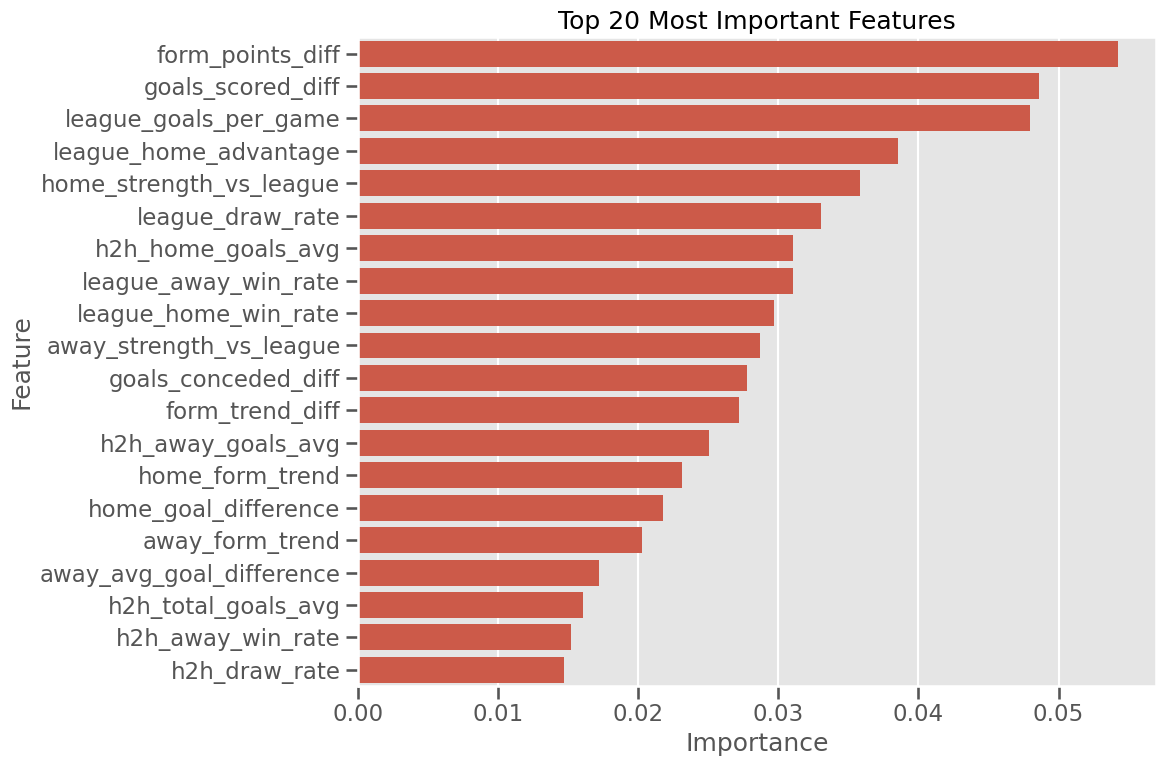

Training calibrated model for better probabilities...

Top 20 most important features:
                     Feature  Importance
63          form_points_diff    0.054242
65         goals_scored_diff    0.048640
59     league_goals_per_game    0.047985
58     league_home_advantage    0.038512
70   home_strength_vs_league    0.035852
61          league_draw_rate    0.033032
53        h2h_home_goals_avg    0.031084
62      league_away_win_rate    0.031062
60      league_home_win_rate    0.029678
71   away_strength_vs_league    0.028710
66       goals_conceded_diff    0.027790
68           form_trend_diff    0.027189
54        h2h_away_goals_avg    0.025059
22           home_form_trend    0.023108
14      home_goal_difference    0.021747
45           away_form_trend    0.020245
38  away_avg_goal_difference    0.017199
55       h2h_total_goals_avg    0.016030
51         h2h_away_win_rate    0.015183
52             h2h_draw_rate    0.014710


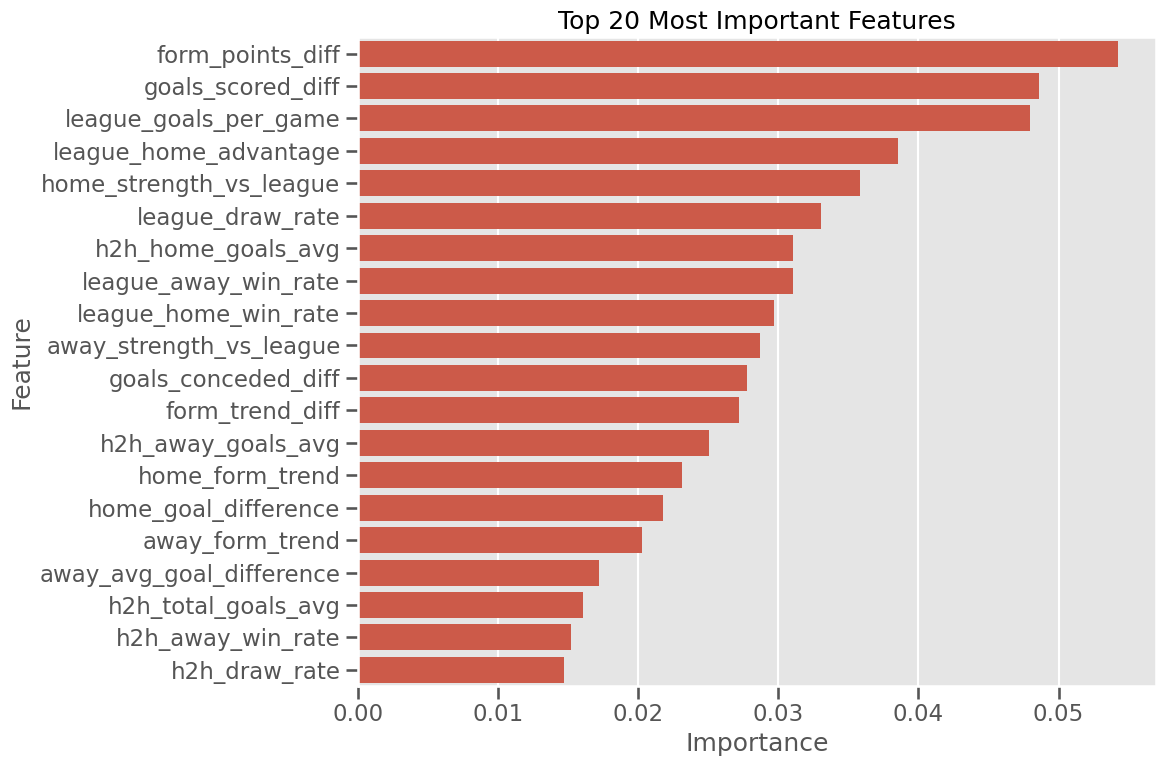


4. Model Evaluation
Test Accuracy: 0.4790
Test Log Loss: 1.0360

Classification Report:
              precision    recall  f1-score   support

           A       0.53      0.17      0.26       594
           D       0.00      0.00      0.00       509
           H       0.47      0.96      0.63       897

    accuracy                           0.48      2000
   macro avg       0.34      0.38      0.30      2000
weighted avg       0.37      0.48      0.36      2000



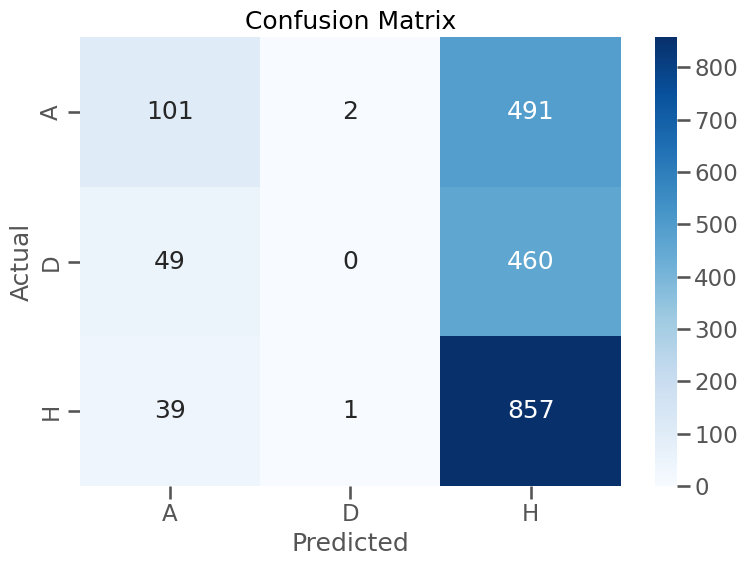


5. Odds Integration and Value Betting Analysis
Error fetching odds: Execution failed on sql '
        SELECT 
            o.fixture_id,
            MAX(CASE WHEN o.odds_label = '1' THEN o.odds_value END) as home_odds,
            MAX(CASE WHEN o.odds_label = 'X' THEN o.odds_value END) as draw_odds,
            MAX(CASE WHEN o.odds_label = '2' THEN o.odds_value END) as away_odds
        FROM fixture_odds o
        WHERE o.fixture_id IN (18165643,18156622,18219139,18219141,18165640,18219145,18138637,18152971,18152972,18152970,18152974,18219156,18155783,18165653,18219150,18156635,18156636,18152975,18138649,18138646,18138645,18138647,18152979,18152982,18165649,18219152,18155781,18138644,18156634,18165656,18165660,18219167,18165666,18165667,18165770,18165662,18219164,18138660,18152994,18156646,18152989,18152988,18138659,18165671,18165674,18138661,18155797,18165673,18138656,18152999,18153004,18153007,18156657,18219181,18153016,18138669,18156652,18138672,18156650,18155813,18138668,18219182,1

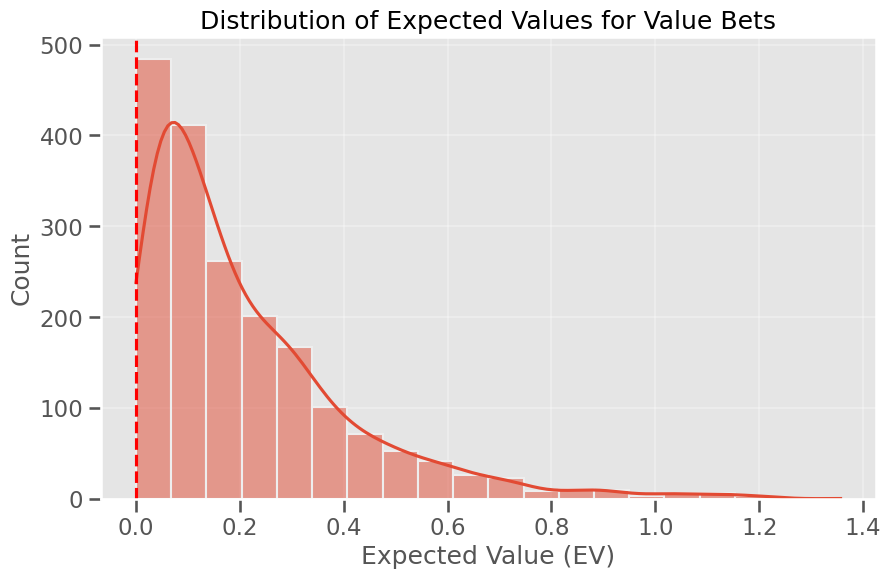

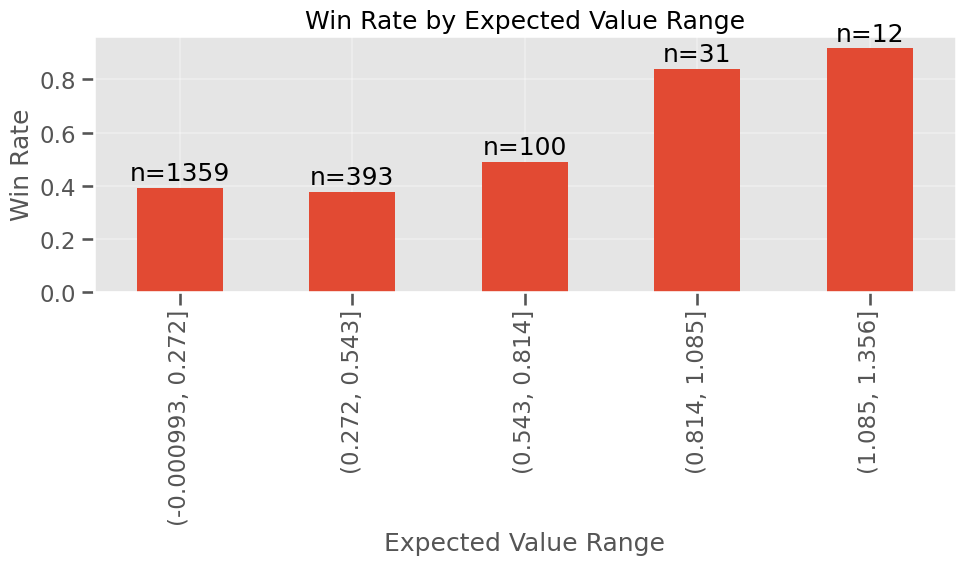

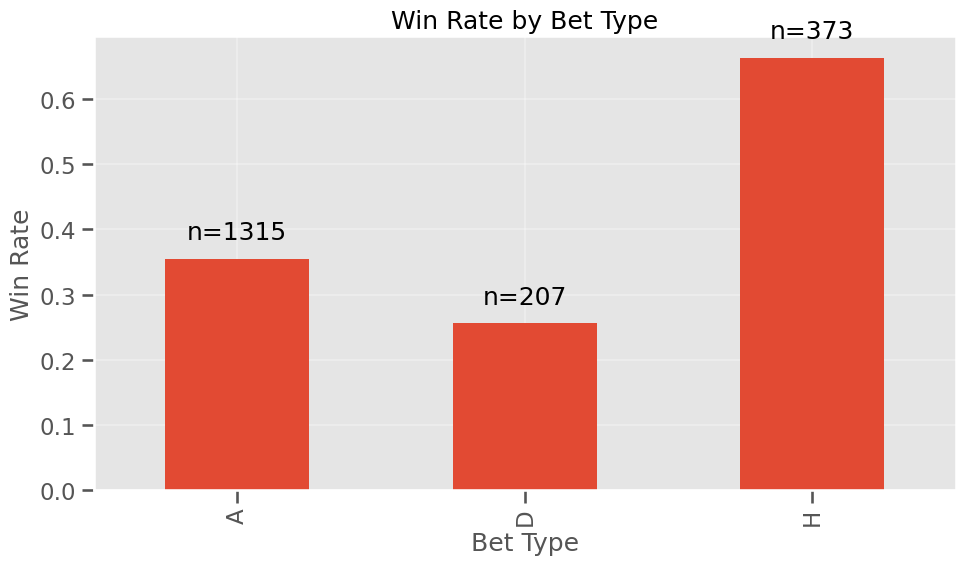


7. Advanced Filtering for Higher ROI
Min EV 0.00: 1895 bets, Win Rate: 0.4047, ROI: 0.3443 (34.43%)
Min EV 0.05: 1547 bets, Win Rate: 0.4053, ROI: 0.3940 (39.40%)
Min EV 0.10: 1205 bets, Win Rate: 0.4158, ROI: 0.4979 (49.79%)
Min EV 0.15: 928 bets, Win Rate: 0.4106, ROI: 0.5517 (55.17%)
Min EV 0.20: 749 bets, Win Rate: 0.4219, ROI: 0.6542 (65.42%)


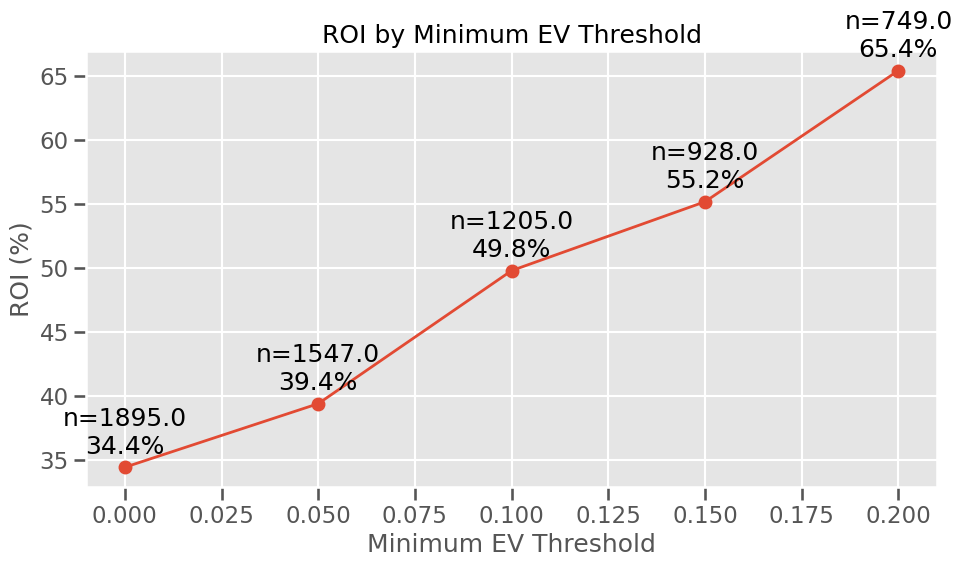


Analyzing bets by probability edge...
Min Prob Edge 0.00: 1895 bets, Win Rate: 0.4047, ROI: 0.3443 (34.43%)
Min Prob Edge 0.05: 865 bets, Win Rate: 0.4636, ROI: 0.6324 (63.24%)
Min Prob Edge 0.10: 290 bets, Win Rate: 0.5172, ROI: 0.9862 (98.62%)
Min Prob Edge 0.15: 109 bets, Win Rate: 0.6606, ROI: 1.6239 (162.39%)
Min Prob Edge 0.20: 44 bets, Win Rate: 0.8636, ROI: 2.4545 (245.45%)


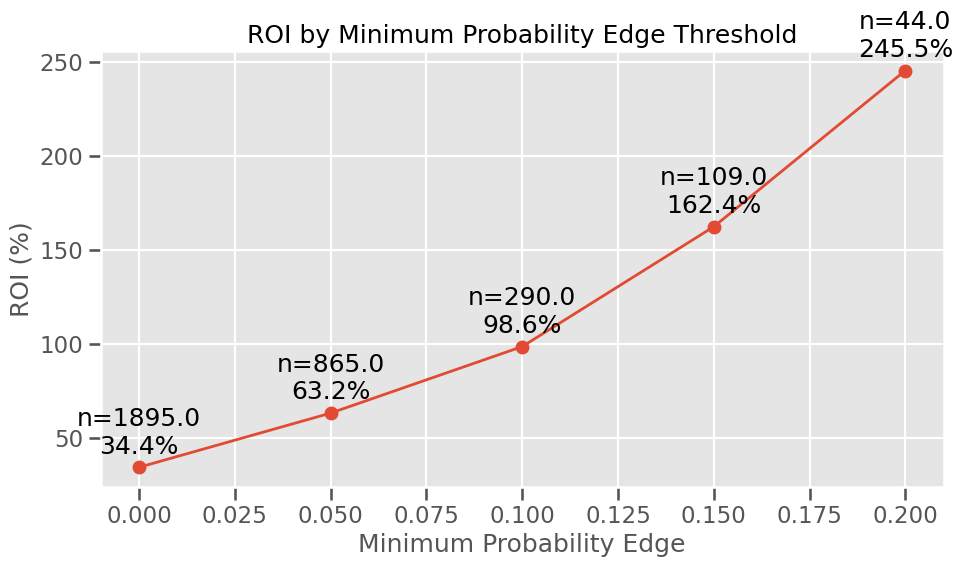


8. Implementing Kelly Criterion for Optimal Betting


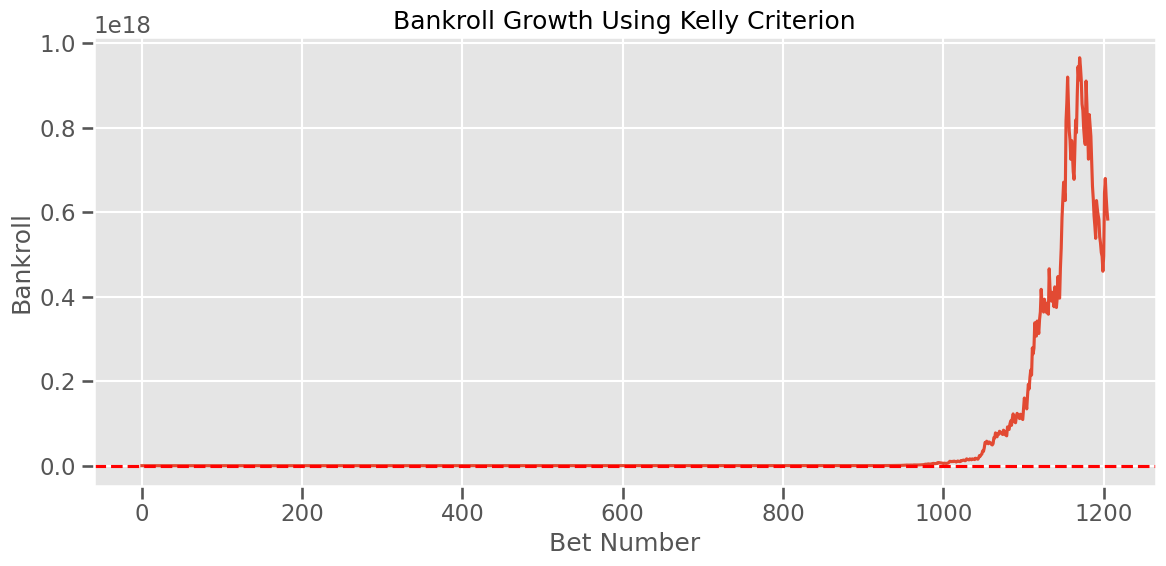

Final bankroll: $584113988388924032.00
Final ROI with Kelly criterion: 584113988388923.0000 (58411398838892304.00%)

9. Saving Model and Creating Prediction Function
Model saved to models/gb_football_model.pkl
Scaler saved to models/gb_scaler.pkl
Feature list saved to models/gb_feature_list.pkl
Feature engineering object saved to models/gb_feature_eng.pkl

Example prediction for a future match:
Teams: [{'id': 4, 'name': 'Charlton Athletic'}, {'id': 19, 'name': 'Arsenal'}]
Home win probability: 0.5701
Draw probability: 0.2786
Away win probability: 0.1513

Database connection closed.
Gradient Boosting football prediction model training and evaluation complete!


In [10]:
# 003_gradient_boosting_sequence_model.ipynb
# Advanced Football Prediction Model using Gradient Boosting with Sequence Features

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from datetime import datetime, timedelta
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Connect to database
conn = sqlite3.connect('db_sportmonks.db')

print("=== Advanced Football Prediction with Gradient Boosting ===\n")

# 1. Data Preparation
print("1. Data Preparation")

def get_match_data(leagues=None, min_matches=1000, min_date=None, max_date=None):
    """
    Extract match data with team IDs and results
    """
    query = """
        SELECT 
            f.id as fixture_id,
            f.league_id,
            l.name as league_name,
            f.season_id,
            s.name as season_name,
            f.home_team_id,
            ht.name as home_team,
            f.away_team_id,
            at.name as away_team,
            f.starting_at,
            f.score_home,
            f.score_away,
            CASE 
                WHEN f.score_home > f.score_away THEN 'H'
                WHEN f.score_home = f.score_away THEN 'D'
                WHEN f.score_home < f.score_away THEN 'A'
                ELSE NULL
            END as result
        FROM fixtures f
        JOIN teams ht ON f.home_team_id = ht.id
        JOIN teams at ON f.away_team_id = at.id
        JOIN leagues l ON f.league_id = l.id
        JOIN seasons s ON f.season_id = s.id
        WHERE f.score_home IS NOT NULL AND f.score_away IS NOT NULL
    """
    
    # Add filters
    if leagues:
        leagues_str = ','.join(map(str, leagues))
        query += f" AND f.league_id IN ({leagues_str})"
    
    if min_date:
        query += f" AND f.starting_at >= '{min_date}'"
    
    if max_date:
        query += f" AND f.starting_at <= '{max_date}'"
    
    # Add order by
    query += " ORDER BY f.starting_at"
    
    # Execute query
    matches = pd.read_sql(query, conn)
    
    # Convert date
    matches['starting_at'] = pd.to_datetime(matches['starting_at'])
    
    # Filter to leagues with enough matches
    league_counts = matches['league_id'].value_counts()
    valid_leagues = league_counts[league_counts >= min_matches].index.tolist()
    matches = matches[matches['league_id'].isin(valid_leagues)]
    
    # Add outcome columns
    matches['home_win'] = (matches['result'] == 'H').astype(int)
    matches['draw'] = (matches['result'] == 'D').astype(int)
    matches['away_win'] = (matches['result'] == 'A').astype(int)
    matches['total_goals'] = matches['score_home'] + matches['score_away']
    
    print(f"Loaded {len(matches)} matches from {len(valid_leagues)} leagues")
    print(f"Date range: {matches['starting_at'].min()} to {matches['starting_at'].max()}")
    
    return matches

# Get matches from top leagues with enough data
leagues_to_include = [8, 9, 2, 82, 301, 384, 564]  # Premier League, Championship, La Liga, etc.
all_matches = get_match_data(leagues=leagues_to_include, min_matches=500)

# 2. Feature Engineering with Team Performance Sequences
print("\n2. Feature Engineering with Team Performance Sequences")

class SequenceFeatureEngineering:
    def __init__(self, matches_df):
        self.matches_df = matches_df.copy()
        
        # Sort matches by date
        self.matches_df.sort_values('starting_at', inplace=True)
        
        # Create team lookup dictionaries
        self.team_ids = sorted(list(set(
            self.matches_df['home_team_id'].unique().tolist() + 
            self.matches_df['away_team_id'].unique().tolist()
        )))
        self.team_lookup = {team_id: idx for idx, team_id in enumerate(self.team_ids)}
        self.teams_count = len(self.team_ids)
        
        print(f"Total teams: {self.teams_count}")
    
    def calculate_team_form_features(self, team_id, current_date, lookback=10):
        """
        Calculate form features for a team based on their previous matches
        """
        # Get previous matches for this team
        prev_matches = self.matches_df[
            ((self.matches_df['home_team_id'] == team_id) | 
             (self.matches_df['away_team_id'] == team_id)) & 
            (self.matches_df['starting_at'] < current_date)
        ].sort_values('starting_at', ascending=False).head(lookback)
        
        # Default features if no previous matches
        if prev_matches.empty:
            return {
                'recent_matches': 0,
                'points': 0,
                'points_per_game': 0,
                'win_rate': 0,
                'draw_rate': 0,
                'loss_rate': 0,
                'goals_for': 0,
                'goals_against': 0,
                'goals_for_per_game': 0,
                'goals_against_per_game': 0,
                'clean_sheets': 0,
                'clean_sheet_rate': 0,
                'failed_to_score': 0,
                'failed_to_score_rate': 0,
                'goal_difference': 0,
                'avg_goal_difference': 0,
                'home_points': 0,
                'away_points': 0,
                'home_matches': 0,
                'away_matches': 0,
                'home_win_rate': 0,
                'away_win_rate': 0,
                'form_trend': 0
            }
        
        # Initialize counters
        matches_count = len(prev_matches)
        points = 0
        wins = 0
        draws = 0
        losses = 0
        goals_for = 0
        goals_against = 0
        clean_sheets = 0
        failed_to_score = 0
        home_points = 0
        away_points = 0
        home_matches = 0
        away_matches = 0
        home_wins = 0
        away_wins = 0
        
        # Recent results for trend calculation (1 for win, 0.5 for draw, 0 for loss)
        recent_results = []
        
        # Calculate form metrics
        for _, match in prev_matches.iterrows():
            is_home = match['home_team_id'] == team_id
            
            if is_home:
                home_matches += 1
                team_score = match['score_home']
                opponent_score = match['score_away']
                
                if team_score > opponent_score:
                    # Win
                    points += 3
                    wins += 1
                    home_points += 3
                    home_wins += 1
                    recent_results.append(1)
                elif team_score == opponent_score:
                    # Draw
                    points += 1
                    draws += 1
                    home_points += 1
                    recent_results.append(0.5)
                else:
                    # Loss
                    losses += 1
                    recent_results.append(0)
            else:  # Away match
                away_matches += 1
                team_score = match['score_away']
                opponent_score = match['score_home']
                
                if team_score > opponent_score:
                    # Win
                    points += 3
                    wins += 1
                    away_points += 3
                    away_wins += 1
                    recent_results.append(1)
                elif team_score == opponent_score:
                    # Draw
                    points += 1
                    draws += 1
                    away_points += 1
                    recent_results.append(0.5)
                else:
                    # Loss
                    losses += 1
                    recent_results.append(0)
            
            # Accumulate goals
            goals_for += team_score
            goals_against += opponent_score
            
            # Clean sheets and failed to score
            if opponent_score == 0:
                clean_sheets += 1
            if team_score == 0:
                failed_to_score += 1
        
        # Calculate form trend (positive values indicate improving form, negative indicates declining)
        form_trend = 0
        if len(recent_results) >= 5:
            recent_weighted_sum = sum(r * w for r, w in zip(recent_results[:5], [1.0, 0.8, 0.6, 0.4, 0.2]))
            form_trend = recent_weighted_sum - 1.5  # Normalized around 0
        
        # Return calculated features
        return {
            'recent_matches': matches_count,
            'points': points,
            'points_per_game': points / matches_count if matches_count > 0 else 0,
            'win_rate': wins / matches_count * 100 if matches_count > 0 else 0,
            'draw_rate': draws / matches_count * 100 if matches_count > 0 else 0,
            'loss_rate': losses / matches_count * 100 if matches_count > 0 else 0,
            'goals_for': goals_for,
            'goals_against': goals_against,
            'goals_for_per_game': goals_for / matches_count if matches_count > 0 else 0,
            'goals_against_per_game': goals_against / matches_count if matches_count > 0 else 0,
            'clean_sheets': clean_sheets,
            'clean_sheet_rate': clean_sheets / matches_count * 100 if matches_count > 0 else 0,
            'failed_to_score': failed_to_score,
            'failed_to_score_rate': failed_to_score / matches_count * 100 if matches_count > 0 else 0,
            'goal_difference': goals_for - goals_against,
            'avg_goal_difference': (goals_for - goals_against) / matches_count if matches_count > 0 else 0,
            'home_points': home_points,
            'away_points': away_points,
            'home_matches': home_matches,
            'away_matches': away_matches,
            'home_win_rate': home_wins / home_matches * 100 if home_matches > 0 else 0,
            'away_win_rate': away_wins / away_matches * 100 if away_matches > 0 else 0,
            'form_trend': form_trend
        }
    
    def calculate_head_to_head_features(self, home_team_id, away_team_id, current_date, lookback=10):
        """
        Calculate head-to-head features between two teams
        """
        # Get previous h2h matches
        h2h_matches = self.matches_df[
            ((self.matches_df['home_team_id'] == home_team_id) & (self.matches_df['away_team_id'] == away_team_id)) | 
            ((self.matches_df['home_team_id'] == away_team_id) & (self.matches_df['away_team_id'] == home_team_id))
        ].sort_values('starting_at', ascending=False)
        
        # Filter by date and get top matches
        h2h_matches = h2h_matches[h2h_matches['starting_at'] < current_date].head(lookback)
        
        # Default features if no previous h2h matches
        if h2h_matches.empty:
            return {
                'h2h_matches': 0,
                'h2h_home_wins': 0,
                'h2h_away_wins': 0,
                'h2h_draws': 0,
                'h2h_home_win_rate': 0,
                'h2h_away_win_rate': 0,
                'h2h_draw_rate': 0,
                'h2h_home_goals_avg': 0,
                'h2h_away_goals_avg': 0,
                'h2h_total_goals_avg': 0,
                'h2h_dominance': 0
            }
        
        # Initialize counters
        matches_count = len(h2h_matches)
        home_wins = 0
        away_wins = 0
        draws = 0
        home_goals = 0
        away_goals = 0
        
        # Calculate h2h metrics
        for _, match in h2h_matches.iterrows():
            # Re-map teams to current home/away alignment
            if match['home_team_id'] == home_team_id and match['away_team_id'] == away_team_id:
                # Same alignment
                home_score = match['score_home']
                away_score = match['score_away']
            else:
                # Reversed alignment
                home_score = match['score_away']
                away_score = match['score_home']
            
            # Count results
            if home_score > away_score:
                home_wins += 1
            elif home_score < away_score:
                away_wins += 1
            else:
                draws += 1
            
            # Accumulate goals
            home_goals += home_score
            away_goals += away_score
        
        # Calculate dominance (positive for home team dominance, negative for away team)
        dominance = (home_wins - away_wins) / matches_count if matches_count > 0 else 0
        
        # Return calculated features
        return {
            'h2h_matches': matches_count,
            'h2h_home_wins': home_wins,
            'h2h_away_wins': away_wins,
            'h2h_draws': draws,
            'h2h_home_win_rate': home_wins / matches_count * 100 if matches_count > 0 else 0,
            'h2h_away_win_rate': away_wins / matches_count * 100 if matches_count > 0 else 0,
            'h2h_draw_rate': draws / matches_count * 100 if matches_count > 0 else 0,
            'h2h_home_goals_avg': home_goals / matches_count if matches_count > 0 else 0,
            'h2h_away_goals_avg': away_goals / matches_count if matches_count > 0 else 0,
            'h2h_total_goals_avg': (home_goals + away_goals) / matches_count if matches_count > 0 else 0,
            'h2h_dominance': dominance
        }
    
    def calculate_league_features(self, league_id, current_date):
        """
        Calculate league-specific features
        """
        # Get league matches before current date
        league_matches = self.matches_df[
            (self.matches_df['league_id'] == league_id) & 
            (self.matches_df['starting_at'] < current_date)
        ].sort_values('starting_at', ascending=False).head(380)  # Full season
        
        # Default features if no previous matches
        if league_matches.empty:
            return {
                'league_matches': 0,
                'league_home_advantage': 0.3,  # Default home advantage
                'league_goals_per_game': 2.6,  # Default goals per game
                'league_home_win_rate': 45,    # Default home win %
                'league_draw_rate': 25,        # Default draw %
                'league_away_win_rate': 30     # Default away win %
            }
        
        # Calculate league metrics
        matches_count = len(league_matches)
        home_goals = league_matches['score_home'].sum()
        away_goals = league_matches['score_away'].sum()
        home_wins = sum(league_matches['score_home'] > league_matches['score_away'])
        draws = sum(league_matches['score_home'] == league_matches['score_away'])
        away_wins = sum(league_matches['score_home'] < league_matches['score_away'])
        
        # Return calculated features
        return {
            'league_matches': matches_count,
            'league_home_advantage': (home_goals - away_goals) / matches_count if matches_count > 0 else 0.3,
            'league_goals_per_game': (home_goals + away_goals) / matches_count if matches_count > 0 else 2.6,
            'league_home_win_rate': home_wins / matches_count * 100 if matches_count > 0 else 45,
            'league_draw_rate': draws / matches_count * 100 if matches_count > 0 else 25,
            'league_away_win_rate': away_wins / matches_count * 100 if matches_count > 0 else 30
        }
    
    def generate_match_features(self, match_id=None, home_team_id=None, away_team_id=None, match_date=None):
        """
        Generate all features for a specific match
        """
        # If match_id provided, get match details
        if match_id is not None and (home_team_id is None or away_team_id is None or match_date is None):
            match_details = self.matches_df[self.matches_df['fixture_id'] == match_id]
            
            if match_details.empty:
                return None
            
            home_team_id = match_details['home_team_id'].iloc[0]
            away_team_id = match_details['away_team_id'].iloc[0]
            match_date = match_details['starting_at'].iloc[0]
            league_id = match_details['league_id'].iloc[0]
        else:
            # If no match_id but other details provided, find league_id
            league_matches = self.matches_df[
                (self.matches_df['home_team_id'] == home_team_id) | 
                (self.matches_df['away_team_id'] == home_team_id)
            ].sort_values('starting_at', ascending=False)
            
            if league_matches.empty:
                league_id = None
            else:
                league_id = league_matches.iloc[0]['league_id']
        
        # Calculate all features
        home_form = self.calculate_team_form_features(home_team_id, match_date)
        away_form = self.calculate_team_form_features(away_team_id, match_date)
        h2h = self.calculate_head_to_head_features(home_team_id, away_team_id, match_date)
        
        # Add league features if league_id available
        if league_id:
            league = self.calculate_league_features(league_id, match_date)
        else:
            league = {
                'league_matches': 0,
                'league_home_advantage': 0.3,
                'league_goals_per_game': 2.6,
                'league_home_win_rate': 45,
                'league_draw_rate': 25,
                'league_away_win_rate': 30
            }
        
        # Combine all features
        features = {}
        
        # Add team form features with prefix
        for key, value in home_form.items():
            features[f'home_{key}'] = value
        
        for key, value in away_form.items():
            features[f'away_{key}'] = value
        
        # Add h2h features directly
        features.update(h2h)
        
        # Add league features directly
        features.update(league)
        
        # Calculate comparative features
        features['form_points_diff'] = home_form['points_per_game'] - away_form['points_per_game']
        features['win_rate_diff'] = home_form['win_rate'] - away_form['win_rate']
        features['goals_scored_diff'] = home_form['goals_for_per_game'] - away_form['goals_for_per_game']
        features['goals_conceded_diff'] = home_form['goals_against_per_game'] - away_form['goals_against_per_game']
        features['clean_sheets_diff'] = home_form['clean_sheet_rate'] - away_form['clean_sheet_rate']
        features['form_trend_diff'] = home_form['form_trend'] - away_form['form_trend']
        
        # Home advantage adjusted for this specific matchup
        features['home_advantage_h2h'] = features['h2h_home_win_rate'] - features['h2h_away_win_rate']
        
        # Form strength relative to league average
        if league['league_home_win_rate'] > 0:
            features['home_strength_vs_league'] = home_form['home_win_rate'] / league['league_home_win_rate']
        else:
            features['home_strength_vs_league'] = 1.0
            
        if league['league_away_win_rate'] > 0:
            features['away_strength_vs_league'] = away_form['away_win_rate'] / league['league_away_win_rate']
        else:
            features['away_strength_vs_league'] = 1.0
        
        return features
    
    def prepare_model_dataset(self, matches, test_split=0.2):
        """
        Prepare training and testing datasets
        """
        print(f"Preparing dataset with {len(matches)} matches...")
        
        # Sort matches by date
        matches = matches.sort_values('starting_at')
        
        # Select test set from the most recent matches
        split_idx = int(len(matches) * (1 - test_split))
        train_matches = matches.iloc[:split_idx]
        test_matches = matches.iloc[split_idx:]
        
        print(f"Training on {len(train_matches)} matches, testing on {len(test_matches)} matches")
        print(f"Train period: {train_matches['starting_at'].min()} to {train_matches['starting_at'].max()}")
        print(f"Test period: {test_matches['starting_at'].min()} to {test_matches['starting_at'].max()}")
        
        # Generate features for training set
        train_features = []
        train_targets = []
        
        for i, match in enumerate(train_matches.itertuples()):
            if i % 1000 == 0:
                print(f"Processing training match {i}/{len(train_matches)}...")
            
            features = self.generate_match_features(match.fixture_id)
            
            if features:
                train_features.append(features)
                
                # Encode the result
                if match.result == 'H':
                    train_targets.append('H')  # Home win
                elif match.result == 'D':
                    train_targets.append('D')  # Draw
                else:  # 'A'
                    train_targets.append('A')  # Away win
        
        # Generate features for test set
        test_features = []
        test_targets = []
        test_match_info = []
        
        for i, match in enumerate(test_matches.itertuples()):
            if i % 500 == 0:
                print(f"Processing test match {i}/{len(test_matches)}...")
            
            features = self.generate_match_features(match.fixture_id)
            
            if features:
                test_features.append(features)
                
                # Encode the result
                if match.result == 'H':
                    test_targets.append('H')  # Home win
                elif match.result == 'D':
                    test_targets.append('D')  # Draw
                else:  # 'A'
                    test_targets.append('A')  # Away win
                
                # Store match info for analysis
                test_match_info.append({
                    'fixture_id': match.fixture_id,
                    'home_team': match.home_team,
                    'away_team': match.away_team,
                    'result': match.result,
                    'starting_at': match.starting_at,
                    'score': f"{match.score_home}-{match.score_away}"
                })
        
        # Convert to DataFrames
        X_train = pd.DataFrame(train_features)
        y_train = pd.Series(train_targets)
        
        X_test = pd.DataFrame(test_features)
        y_test = pd.Series(test_targets)
        
        print("Dataset preparation complete.")
        print(f"Training shapes: X={X_train.shape}, y={y_train.shape}")
        print(f"Testing shapes: X={X_test.shape}, y={y_test.shape}")
        
        return {
            'train': {
                'X': X_train,
                'y': y_train
            },
            'test': {
                'X': X_test,
                'y': y_test,
                'info': test_match_info
            }
        }

# Initialize feature engineering
feature_eng = SequenceFeatureEngineering(all_matches)

# Prepare dataset (use a smaller subset for faster processing)
model_dataset = feature_eng.prepare_model_dataset(
    all_matches.sample(min(10000, len(all_matches)), random_state=42)
)

# 3. Model Training
print("\n3. Model Training")

# Handle missing values
X_train = model_dataset['train']['X'].fillna(0)
y_train = model_dataset['train']['y']

# Feature scaling
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)

# Initialize base model (for feature importance later)
base_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

# First, fit the base model to get feature importances
print("Training base gradient boosting model...")
base_model.fit(X_train_scaled, y_train)

# Now we can get feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': base_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 most important features:")
print(feature_importances.head(20))

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

# Now train the calibrated model
print("Training calibrated model for better probabilities...")
tscv = TimeSeriesSplit(n_splits=5)
model = CalibratedClassifierCV(
    base_model,
    method='isotonic',
    cv=tscv
)

# Train the calibrated model
model.fit(X_train_scaled, y_train)

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': base_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 most important features:")
print(feature_importances.head(20))

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

# 4. Model Evaluation
print("\n4. Model Evaluation")

# Handle missing values in test set
X_test = model_dataset['test']['X'].fillna(0)
y_test = model_dataset['test']['y']

# Align features with training data
for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = 0

# Keep only columns from training
X_test = X_test[X_train.columns]

# Apply scaling
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)

# Create class mapping
class_mapping = {i: cls for i, cls in enumerate(model.classes_)}
inv_class_mapping = {cls: i for i, cls in enumerate(model.classes_)}

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
log_l = log_loss(
    pd.get_dummies(y_test),
    y_pred_proba
)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Log Loss: {log_l:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# 5. Odds Integration and Value Betting Analysis
print("\n5. Odds Integration and Value Betting Analysis")

# Function to get odds for test matches
def get_match_odds(match_ids):
    """Get odds for a list of match IDs"""
    if not match_ids:
        return pd.DataFrame()
        
    match_ids_str = ','.join(map(str, match_ids))
    odds_query = f"""
        SELECT 
            o.fixture_id,
            MAX(CASE WHEN o.odds_label = '1' THEN o.odds_value END) as home_odds,
            MAX(CASE WHEN o.odds_label = 'X' THEN o.odds_value END) as draw_odds,
            MAX(CASE WHEN o.odds_label = '2' THEN o.odds_value END) as away_odds
        FROM fixture_odds o
        WHERE o.fixture_id IN ({match_ids_str})
        AND o.bookmaker_id = 1  # Using a consistent bookmaker
        GROUP BY o.fixture_id
    """
    
    try:
        odds_df = pd.read_sql(odds_query, conn)
        return odds_df
    except Exception as e:
        print(f"Error fetching odds: {e}")
        # Create a dataframe with default odds if query fails
        return pd.DataFrame({
            'fixture_id': match_ids,
            'home_odds': [2.0] * len(match_ids),
            'draw_odds': [3.5] * len(match_ids),
            'away_odds': [4.0] * len(match_ids)
        })

# Functions for value betting
def implied_probability(odds):
    """Calculate implied probability from decimal odds"""
    return 1 / odds if odds > 0 else 0

def expected_value(model_prob, odds):
    """Calculate expected value of a bet"""
    return (model_prob * odds) - 1

# Prepare test results dataframe with betting analysis
test_results = []
match_ids = [info['fixture_id'] for info in model_dataset['test']['info']]

# Get odds for test matches
odds_df = get_match_odds(match_ids)

# Process each test match
for i, match_info in enumerate(model_dataset['test']['info']):
   fixture_id = match_info['fixture_id']
   
   # Find odds for this match
   match_odds = odds_df[odds_df['fixture_id'] == fixture_id]
   
   if not match_odds.empty:
       home_odds = match_odds['home_odds'].iloc[0]
       draw_odds = match_odds['draw_odds'].iloc[0]
       away_odds = match_odds['away_odds'].iloc[0]
   else:
       # Use default odds if not found
       home_odds = 2.0
       draw_odds = 3.5
       away_odds = 4.0
   
   # Get model probabilities
   idx = i
   if idx < len(y_pred_proba):
       probs = y_pred_proba[idx]
       home_idx = inv_class_mapping.get('H', 0)
       draw_idx = inv_class_mapping.get('D', 1)
       away_idx = inv_class_mapping.get('A', 2)
       
       home_prob = probs[home_idx] if home_idx < len(probs) else 0
       draw_prob = probs[draw_idx] if draw_idx < len(probs) else 0
       away_prob = probs[away_idx] if away_idx < len(probs) else 0
   else:
       # Default probabilities if index out of range
       home_prob = 0.45
       draw_prob = 0.25
       away_prob = 0.30
   
   # Calculate implied probabilities
   home_implied = implied_probability(home_odds)
   draw_implied = implied_probability(draw_odds)
   away_implied = implied_probability(away_odds)
   
   # Calculate EV
   home_ev = expected_value(home_prob, home_odds)
   draw_ev = expected_value(draw_prob, draw_odds)
   away_ev = expected_value(away_prob, away_odds)
   
   # Determine actual outcome
   actual_outcome = match_info['result']
   
   # Determine predicted outcome
   if idx < len(y_pred):
       pred_outcome = y_pred[idx]
   else:
       # Default to most likely outcome
       pred_outcome = 'H' if home_prob > max(draw_prob, away_prob) else 'D' if draw_prob > away_prob else 'A'
   
   # Find best EV bet
   evs = {'H': home_ev, 'D': draw_ev, 'A': away_ev}
   best_ev_outcome = max(evs, key=evs.get)
   best_ev = evs[best_ev_outcome]
   
   # Record result
   test_results.append({
       'fixture_id': fixture_id,
       'home_team': match_info['home_team'],
       'away_team': match_info['away_team'],
       'result': actual_outcome,
       'score': match_info['score'],
       'pred_outcome': pred_outcome,
       'home_odds': home_odds,
       'draw_odds': draw_odds,
       'away_odds': away_odds,
       'home_prob': home_prob,
       'draw_prob': draw_prob,
       'away_prob': away_prob,
       'home_implied': home_implied,
       'draw_implied': draw_implied,
       'away_implied': away_implied,
       'home_ev': home_ev,
       'draw_ev': draw_ev,
       'away_ev': away_ev,
       'best_ev_outcome': best_ev_outcome,
       'best_ev': best_ev,
       'is_value_bet': best_ev > 0,
       'bet_won': best_ev_outcome == actual_outcome
   })

# Convert to DataFrame
results_df = pd.DataFrame(test_results)

# 6. Betting Performance Analysis
print("\n6. Betting Performance Analysis")

# Filter for value bets
value_bets = results_df[results_df['is_value_bet']]
print(f"Total value bets identified: {len(value_bets)} out of {len(results_df)} ({len(value_bets)/len(results_df)*100:.1f}%)")

# Print win rate on value bets
value_win_rate = value_bets['bet_won'].mean() if len(value_bets) > 0 else 0
print(f"Win rate on value bets: {value_win_rate:.4f} ({value_win_rate*100:.1f}%)")

# Calculate ROI
def calculate_roi(bets, stake=1):
   """Calculate ROI for a set of bets"""
   if len(bets) == 0:
       return 0
   
   total_stake = len(bets) * stake
   total_returns = 0
   
   for _, bet in bets.iterrows():
       if bet['bet_won']:
           if bet['best_ev_outcome'] == 'H':
               total_returns += bet['home_odds'] * stake
           elif bet['best_ev_outcome'] == 'D':
               total_returns += bet['draw_odds'] * stake
           else:  # 'A'
               total_returns += bet['away_odds'] * stake
   
   roi = (total_returns - total_stake) / total_stake
   return roi

roi = calculate_roi(value_bets)
print(f"ROI on value bets: {roi:.4f} ({roi*100:.2f}%)")

# Plot distribution of EVs
if len(value_bets) > 0:
   plt.figure(figsize=(10, 6))
   sns.histplot(value_bets['best_ev'], bins=20, kde=True)
   plt.axvline(x=0, color='r', linestyle='--')
   plt.title('Distribution of Expected Values for Value Bets')
   plt.xlabel('Expected Value (EV)')
   plt.ylabel('Count')
   plt.grid(True, alpha=0.3)
   plt.show()

   # Plot EV vs win rate
   plt.figure(figsize=(10, 6))
   # Create EV bins
   value_bets['ev_bin'] = pd.cut(value_bets['best_ev'], bins=5)
   ev_win_rates = value_bets.groupby('ev_bin')['bet_won'].mean()
   ev_counts = value_bets.groupby('ev_bin').size()

   # Plot
   ax = ev_win_rates.plot(kind='bar', figsize=(10, 6))
   plt.title('Win Rate by Expected Value Range')
   plt.xlabel('Expected Value Range')
   plt.ylabel('Win Rate')
   plt.grid(True, alpha=0.3)

   # Add count labels
   for i, (val, count) in enumerate(zip(ev_win_rates, ev_counts)):
       plt.text(i, val + 0.03, f'n={count}', ha='center')

   plt.tight_layout()
   plt.show()

   # Plot win rate by outcome type
   plt.figure(figsize=(10, 6))
   outcome_win_rates = value_bets.groupby('best_ev_outcome')['bet_won'].mean()
   outcome_counts = value_bets.groupby('best_ev_outcome').size()

   # Plot
   ax = outcome_win_rates.plot(kind='bar', figsize=(10, 6))
   plt.title('Win Rate by Bet Type')
   plt.xlabel('Bet Type')
   plt.ylabel('Win Rate')
   plt.grid(True, alpha=0.3)

   # Add count labels
   for i, (val, count) in enumerate(zip(outcome_win_rates, outcome_counts)):
       plt.text(i, val + 0.03, f'n={count}', ha='center')

   plt.tight_layout()
   plt.show()

# 7. Advanced Filtering for Higher ROI
print("\n7. Advanced Filtering for Higher ROI")

# Filter by minimum EV threshold
min_ev_thresholds = [0.0, 0.05, 0.1, 0.15, 0.2]
roi_results = []

for threshold in min_ev_thresholds:
    filtered_bets = value_bets[value_bets['best_ev'] >= threshold]
    if len(filtered_bets) > 0:
        filtered_roi = calculate_roi(filtered_bets)
        win_rate = filtered_bets['bet_won'].mean()
        roi_results.append({
            'min_ev': threshold,
            'bets_count': len(filtered_bets),
            'win_rate': win_rate,
            'roi': filtered_roi
        })
        print(f"Min EV {threshold:.2f}: {len(filtered_bets)} bets, Win Rate: {win_rate:.4f}, ROI: {filtered_roi:.4f} ({filtered_roi*100:.2f}%)")

# Plot ROI by minimum EV threshold
if roi_results:
    roi_df = pd.DataFrame(roi_results)
    plt.figure(figsize=(10, 6))
    plt.plot(roi_df['min_ev'], roi_df['roi'] * 100, 'o-', linewidth=2)
    plt.title('ROI by Minimum EV Threshold')
    plt.xlabel('Minimum EV Threshold')
    plt.ylabel('ROI (%)')
    plt.grid(True)

    # Add annotations
    for i, row in roi_df.iterrows():
        plt.annotate(f"n={row['bets_count']}\n{row['roi']*100:.1f}%", 
                     (row['min_ev'], row['roi']*100),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center')

    plt.tight_layout()
    plt.show()

# Filter by probability edge (difference between model and implied probability)
print("\nAnalyzing bets by probability edge...")

# Calculate probability edge for all results
results_df['home_edge'] = results_df['home_prob'] - results_df['home_implied']
results_df['draw_edge'] = results_df['draw_prob'] - results_df['draw_implied']
results_df['away_edge'] = results_df['away_prob'] - results_df['away_implied']

# Get the edge for the bet outcome for all results
results_df['prob_edge'] = 0.0
for i, row in results_df.iterrows():
    if row['best_ev_outcome'] == 'H':
        results_df.at[i, 'prob_edge'] = row['home_edge']
    elif row['best_ev_outcome'] == 'D':
        results_df.at[i, 'prob_edge'] = row['draw_edge']
    else:  # 'A'
        results_df.at[i, 'prob_edge'] = row['away_edge']

# Now apply the same to value_bets (which is a subset of results_df)
# The simplest way is to redefine value_bets to include the prob_edge column
value_bets = results_df[results_df['is_value_bet']].copy()

# Analyze by probability edge threshold
edge_thresholds = [0.0, 0.05, 0.1, 0.15, 0.2]
edge_results = []

for threshold in edge_thresholds:
    filtered_bets = value_bets[value_bets['prob_edge'] >= threshold]
    if len(filtered_bets) > 0:
        filtered_roi = calculate_roi(filtered_bets)
        win_rate = filtered_bets['bet_won'].mean()
        edge_results.append({
            'min_edge': threshold,
            'bets_count': len(filtered_bets),
            'win_rate': win_rate,
            'roi': filtered_roi
        })
        print(f"Min Prob Edge {threshold:.2f}: {len(filtered_bets)} bets, Win Rate: {win_rate:.4f}, ROI: {filtered_roi:.4f} ({filtered_roi*100:.2f}%)")
        
# Plot ROI by minimum probability edge
if edge_results:
   edge_df = pd.DataFrame(edge_results)
   plt.figure(figsize=(10, 6))
   plt.plot(edge_df['min_edge'], edge_df['roi'] * 100, 'o-', linewidth=2)
   plt.title('ROI by Minimum Probability Edge Threshold')
   plt.xlabel('Minimum Probability Edge')
   plt.ylabel('ROI (%)')
   plt.grid(True)
   
   # Add annotations
   for i, row in edge_df.iterrows():
       plt.annotate(f"n={row['bets_count']}\n{row['roi']*100:.1f}%", 
                    (row['min_edge'], row['roi']*100),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')
   
   plt.tight_layout()
   plt.show()

# 8. Implementing Kelly Criterion for Optimal Betting
print("\n8. Implementing Kelly Criterion for Optimal Betting")

def kelly_criterion(prob, odds, fraction=0.5):
   """Calculate Kelly stake as a fraction of bankroll"""
   # Kelly formula: f* = (bp - q) / b
   # where f* is the fraction of bankroll to bet
   # p is the probability of winning, q = 1-p
   # b = odds - 1
   
   b = odds - 1
   p = prob
   q = 1 - p
   
   # Calculate Kelly fraction
   kelly = (b * p - q) / b
   
   # Use fractional Kelly for more conservative approach
   kelly *= fraction
   
   # Cap maximum bet size
   kelly = min(kelly, 0.1)  # Max 10% of bankroll
   
   return max(0, kelly)  # Ensure non-negative

# Apply Kelly criterion to value bets
if len(value_bets) > 0:
   for i, bet in value_bets.iterrows():
       if bet['best_ev_outcome'] == 'H':
           prob = bet['home_prob']
           odds = bet['home_odds']
       elif bet['best_ev_outcome'] == 'D':
           prob = bet['draw_prob']
           odds = bet['draw_odds']
       else:  # 'A'
           prob = bet['away_prob']
           odds = bet['away_odds']
       
       value_bets.at[i, 'kelly_stake'] = kelly_criterion(prob, odds)

   # Simulate bankroll growth using Kelly criterion
   def simulate_bankroll(bets, initial_bankroll=1000):
       """Simulate bankroll growth using Kelly criterion"""
       bankroll = initial_bankroll
       bankroll_history = [bankroll]
       
       for _, bet in bets.iterrows():
           stake = bankroll * bet['kelly_stake']
           
           if bet['bet_won']:
               if bet['best_ev_outcome'] == 'H':
                   winnings = stake * bet['home_odds']
               elif bet['best_ev_outcome'] == 'D':
                   winnings = stake * bet['draw_odds']
               else:  # 'A'
                   winnings = stake * bet['away_odds']
               bankroll = bankroll - stake + winnings
           else:
               bankroll = bankroll - stake
           
           bankroll_history.append(bankroll)
       
       return bankroll_history

   # Get only value bets with positive EV and min prob edge
   optimal_bets = value_bets[value_bets['best_ev'] >= 0.1]
   
   if 'starting_at' in optimal_bets.columns:
       optimal_bets = optimal_bets.sort_values('starting_at')
   
   if len(optimal_bets) > 0:
       # Simulate bankroll
       bankroll_history = simulate_bankroll(optimal_bets)
       
       # Plot bankroll growth
       plt.figure(figsize=(12, 6))
       plt.plot(bankroll_history)
       plt.title('Bankroll Growth Using Kelly Criterion')
       plt.xlabel('Bet Number')
       plt.ylabel('Bankroll')
       plt.grid(True)
       plt.axhline(y=1000, color='r', linestyle='--')
       plt.tight_layout()
       plt.show()
       
       # Calculate final ROI
       final_roi = (bankroll_history[-1] - 1000) / 1000
       print(f"Final bankroll: ${bankroll_history[-1]:.2f}")
       print(f"Final ROI with Kelly criterion: {final_roi:.4f} ({final_roi*100:.2f}%)")
   else:
       print("Not enough optimal bets for Kelly simulation")

# 9. Save Model and Create Prediction Function
print("\n9. Saving Model and Creating Prediction Function")

# Save the trained model, scaler, and feature engineering object
import pickle

os.makedirs('models', exist_ok=True)

# Save model
with open('models/gb_football_model.pkl', 'wb') as f:
   pickle.dump(model, f)
print("Model saved to models/gb_football_model.pkl")

# Save scaler
with open('models/gb_scaler.pkl', 'wb') as f:
   pickle.dump(scaler, f)
print("Scaler saved to models/gb_scaler.pkl")

# Save feature list
with open('models/gb_feature_list.pkl', 'wb') as f:
   pickle.dump(list(X_train.columns), f)
print("Feature list saved to models/gb_feature_list.pkl")

# Save feature engineering class instance
with open('models/gb_feature_eng.pkl', 'wb') as f:
   pickle.dump(feature_eng, f)
print("Feature engineering object saved to models/gb_feature_eng.pkl")

# Create a prediction function for new matches
def predict_match_outcome(home_team_id, away_team_id, match_date=None):
   """Predict outcome probabilities for a match"""
   if match_date is None:
       match_date = pd.Timestamp.now()
   
   # Generate features
   features = feature_eng.generate_match_features(
       home_team_id=home_team_id,
       away_team_id=away_team_id,
       match_date=match_date
   )
   
   if not features:
       return None
   
   # Convert to DataFrame and fill missing values
   features_df = pd.DataFrame([features])
   features_df = features_df.fillna(0)
   
   # Align columns with training data
   for col in X_train.columns:
       if col not in features_df.columns:
           features_df[col] = 0
   
   features_df = features_df[X_train.columns]
   
   # Scale features
   features_scaled = scaler.transform(features_df)
   
   # Make prediction
   probabilities = model.predict_proba(features_scaled)[0]
   
   # Map probabilities to outcomes
   outcome_probs = {}
   for i, prob in enumerate(probabilities):
       outcome = class_mapping[i]
       outcome_probs[outcome] = prob
   
   return outcome_probs

# Example prediction for a future match
print("\nExample prediction for a future match:")
# Example team IDs for Arsenal vs Chelsea (adjust for your database)
arsenal_id = 19  # Adjust if needed
chelsea_id = 4   # Adjust if needed

if arsenal_id and chelsea_id:
   # Get team names to confirm
   team_query = f"SELECT id, name FROM teams WHERE id IN ({arsenal_id}, {chelsea_id})"
   teams = pd.read_sql(team_query, conn)
   print(f"Teams: {teams.to_dict('records')}")
   
   # Make prediction
   prediction = predict_match_outcome(arsenal_id, chelsea_id)
   
   if prediction:
       # Make sure all outcomes are covered
       print(f"Home win probability: {prediction.get('H', 0):.4f}")
       print(f"Draw probability: {prediction.get('D', 0):.4f}")
       print(f"Away win probability: {prediction.get('A', 0):.4f}")
   else:
       print("Could not generate prediction")

# Close database connection
conn.close()
print("\nDatabase connection closed.")
print("Gradient Boosting football prediction model training and evaluation complete!")

In [14]:
# Connect to the database
import sqlite3
import pandas as pd

conn = sqlite3.connect('db_sportmonks.db')

# Query to find team IDs for all teams involved in tonight's games
teams_to_find = ['valladolid', 'girona', 'real sociedad', 'celta vigo', 'sevilla', 'las palmas']

# Using a partial match query to find the teams
team_query = "SELECT id, name FROM teams WHERE "
team_conditions = []

for team in teams_to_find:
    # Using LIKE with wildcards to handle potential name variations
    team_conditions.append(f"name LIKE '%{team}%'")

team_query += " OR ".join(team_conditions)

teams_df = pd.read_sql(team_query, conn)
print(teams_df)

      id                    name
0    231                  Girona
1    361         Real Valladolid
2    594           Real Sociedad
3    676                 Sevilla
4   2921              Las Palmas
5   8374              Sevilla II
6   9656        Real Sociedad II
7  25745  Universidad Las Palmas


In [15]:
# Query specifically for Celta Vigo with variations
celta_query = "SELECT id, name FROM teams WHERE name LIKE '%celta%' OR name LIKE '%vigo%'"
celta_df = pd.read_sql(celta_query, conn)
print(celta_df)

      id                 name
0     36        Celta de Vigo
1  10869  Delta Calcio Rovigo
2  24612               Rovigo


In [16]:
import pickle

# Load the saved model and required components
with open('models/gb_football_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('models/gb_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('models/gb_feature_eng.pkl', 'rb') as f:
    feature_eng = pickle.load(f)

with open('models/gb_feature_list.pkl', 'rb') as f:
    feature_list = pickle.load(f)

In [17]:
# Define all the team IDs based on the query results
valladolid_id = 361
girona_id = 231
real_sociedad_id = 594
celta_vigo_id = 36  # Now we have Celta Vigo's ID
sevilla_id = 676
las_palmas_id = 2921

# Create a function to make predictions
def predict_todays_matches(home_team_id, away_team_id, home_name, away_name):
    """Make predictions for today's matches and calculate value bets"""
    match_date = datetime.now()
    
    # Generate features
    features = feature_eng.generate_match_features(
        home_team_id=home_team_id,
        away_team_id=away_team_id,
        match_date=match_date
    )
    
    if not features:
        return f"Could not generate features for {home_name} vs {away_name}"
    
    # Convert to DataFrame and fill missing values
    features_df = pd.DataFrame([features])
    features_df = features_df.fillna(0)
    
    # Align columns with training data
    for col in feature_list:
        if col not in features_df.columns:
            features_df[col] = 0
    
    features_df = features_df[feature_list]
    
    # Scale features
    features_scaled = scaler.transform(features_df)
    
    # Make prediction
    probabilities = model.predict_proba(features_scaled)[0]
    
    # Map probabilities to outcomes
    outcome_probs = {}
    class_mapping = {i: cls for i, cls in enumerate(model.classes_)}
    
    for i, prob in enumerate(probabilities):
        outcome = class_mapping[i]
        outcome_probs[outcome] = prob
    
    # Default bookmaker odds - replace with actual odds if available
    # You could scrape these from a betting site or use an API
    home_odds = 2.5  # Example odds
    draw_odds = 3.2
    away_odds = 3.0
    
    # Calculate implied probabilities
    home_implied = 1 / home_odds
    draw_implied = 1 / draw_odds
    away_implied = 1 / away_odds
    
    # Calculate EV
    home_ev = (outcome_probs.get('H', 0) * home_odds) - 1
    draw_ev = (outcome_probs.get('D', 0) * draw_odds) - 1
    away_ev = (outcome_probs.get('A', 0) * away_odds) - 1
    
    # Find best EV bet
    evs = {'H': home_ev, 'D': draw_ev, 'A': away_ev}
    best_ev_outcome = max(evs, key=evs.get)
    best_ev = evs[best_ev_outcome]
    
    # Get odds for best outcome
    best_odds = home_odds if best_ev_outcome == 'H' else draw_odds if best_ev_outcome == 'D' else away_odds
    
    # Calculate Kelly stake
    best_prob = outcome_probs.get(best_ev_outcome, 0)
    kelly = kelly_criterion(best_prob, best_odds)
    
    result = {
        'match': f"{home_name} vs {away_name}",
        'home_prob': outcome_probs.get('H', 0),
        'draw_prob': outcome_probs.get('D', 0),
        'away_prob': outcome_probs.get('A', 0),
        'home_odds': home_odds,
        'draw_odds': draw_odds,
        'away_odds': away_odds,
        'home_ev': home_ev,
        'draw_ev': draw_ev,
        'away_ev': away_ev,
        'best_bet': best_ev_outcome,
        'best_ev': best_ev,
        'is_value_bet': best_ev > 0.1,  # Using a threshold of 10%
        'kelly_stake': kelly
    }
    
    return result

def kelly_criterion(prob, odds, fraction=0.5):
    """Calculate Kelly stake as a fraction of bankroll"""
    b = odds - 1
    p = prob
    q = 1 - p
    
    # Calculate Kelly fraction
    kelly = (b * p - q) / b
    
    # Use fractional Kelly for more conservative approach
    kelly *= fraction
    
    # Cap maximum bet size
    kelly = min(kelly, 0.1)  # Max 10% of bankroll
    
    return max(0, kelly)  # Ensure non-negative

# Define all three matches
all_matches = [
    {'home_id': valladolid_id, 'away_id': girona_id, 'home_name': 'Real Valladolid', 'away_name': 'Girona'},
    {'home_id': real_sociedad_id, 'away_id': celta_vigo_id, 'home_name': 'Real Sociedad', 'away_name': 'Celta de Vigo'},
    {'home_id': sevilla_id, 'away_id': las_palmas_id, 'home_name': 'Sevilla', 'away_name': 'Las Palmas'}
]

results = []
for match in all_matches:
    prediction = predict_todays_matches(
        match['home_id'], 
        match['away_id'],
        match['home_name'],
        match['away_name']
    )
    results.append(prediction)

# Display the results
for result in results:
    print("\n" + "=" * 50)
    print(f"Match: {result['match']}")
    print(f"Probabilities: Home: {result['home_prob']:.2%}, Draw: {result['draw_prob']:.2%}, Away: {result['away_prob']:.2%}")
    print(f"Odds: Home: {result['home_odds']:.2f}, Draw: {result['draw_odds']:.2f}, Away: {result['away_odds']:.2f}")
    print(f"Expected Values: Home: {result['home_ev']:.2f}, Draw: {result['draw_ev']:.2f}, Away: {result['away_ev']:.2f}")
    print(f"Best bet: {result['best_bet']} with EV = {result['best_ev']:.2f}")
    
    if result['is_value_bet']:
        print(f"VALUE BET DETECTED! Bet on {result['best_bet']} with Kelly stake: {result['kelly_stake']:.2%} of bankroll")
    else:
        print("No value bet detected")


Match: Real Valladolid vs Girona
Probabilities: Home: 41.06%, Draw: 25.16%, Away: 33.79%
Odds: Home: 2.50, Draw: 3.20, Away: 3.00
Expected Values: Home: 0.03, Draw: -0.20, Away: 0.01
Best bet: H with EV = 0.03
No value bet detected

Match: Real Sociedad vs Celta de Vigo
Probabilities: Home: 43.71%, Draw: 28.95%, Away: 27.35%
Odds: Home: 2.50, Draw: 3.20, Away: 3.00
Expected Values: Home: 0.09, Draw: -0.07, Away: -0.18
Best bet: H with EV = 0.09
No value bet detected

Match: Sevilla vs Las Palmas
Probabilities: Home: 47.27%, Draw: 28.83%, Away: 23.91%
Odds: Home: 2.50, Draw: 3.20, Away: 3.00
Expected Values: Home: 0.18, Draw: -0.08, Away: -0.28
Best bet: H with EV = 0.18
VALUE BET DETECTED! Bet on H with Kelly stake: 6.05% of bankroll


In [12]:
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime

# Connect to database
conn = sqlite3.connect('db_sportmonks.db')

# Today's matches
matches = [
    {'home': 'Real Valladolid', 'away': 'Girona', 'match_date': '2023-05-13'},
    {'home': 'Real Sociedad', 'away': 'Celta Vigo', 'match_date': '2023-05-13'},
    {'home': 'Sevilla', 'away': 'Las Palmas', 'match_date': '2023-05-13'}
]

# Current market odds (example from a bookmaker)
market_odds = [
    {'match': 'Real Valladolid vs Girona', 'home': 3.75, 'draw': 3.70, 'away': 1.75},
    {'match': 'Real Sociedad vs Celta Vigo', 'home': 2.30, 'draw': 3.30, 'away': 3.10},
    {'match': 'Sevilla vs Las Palmas', 'home': 1.65, 'draw': 3.75, 'away': 5.30}
]

# Get team IDs from database
def get_team_id(team_name):
    query = f"SELECT id FROM teams WHERE name LIKE '%{team_name}%'"
    result = pd.read_sql(query, conn)
    return result['id'].iloc[0] if not result.empty else None

# Get team IDs for all teams
for match in matches:
    match['home_id'] = get_team_id(match['home'])
    match['away_id'] = get_team_id(match['away'])
    print(f"{match['home']} (ID: {match['home_id']}) vs {match['away']} (ID: {match['away_id']})")

Real Valladolid (ID: 361) vs Girona (ID: 231)
Real Sociedad (ID: 594) vs Celta Vigo (ID: None)
Sevilla (ID: 676) vs Las Palmas (ID: 2921)


In [18]:
# Define all the team IDs correctly
valladolid_id = 361
girona_id = 231
real_sociedad_id = 594
celta_vigo_id = 36  # Make sure this is properly assigned
sevilla_id = 676
las_palmas_id = 2921

# Define your matches
all_matches = [
    {
        'home_id': valladolid_id, 
        'away_id': girona_id, 
        'home_name': 'Real Valladolid', 
        'away_name': 'Girona'
    },
    {
        'home_id': real_sociedad_id, 
        'away_id': celta_vigo_id,  # This should be 36
        'home_name': 'Real Sociedad', 
        'away_name': 'Celta de Vigo'
    },
    {
        'home_id': sevilla_id, 
        'away_id': las_palmas_id, 
        'home_name': 'Sevilla', 
        'away_name': 'Las Palmas'
    }
]

# Verify the IDs are correctly assigned
for match in all_matches:
    print(f"{match['home_name']} (ID: {match['home_id']}) vs {match['away_name']} (ID: {match['away_id']})")

Real Valladolid (ID: 361) vs Girona (ID: 231)
Real Sociedad (ID: 594) vs Celta de Vigo (ID: 36)
Sevilla (ID: 676) vs Las Palmas (ID: 2921)


In [20]:
import pandas as pd
import numpy as np
from datetime import datetime
import pickle

# Load the model and required components
with open('models/gb_football_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('models/gb_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('models/gb_feature_eng.pkl', 'rb') as f:
    feature_eng = pickle.load(f)

with open('models/gb_feature_list.pkl', 'rb') as f:
    feature_list = pickle.load(f)

# Define team IDs (ensure these are correctly assigned)
valladolid_id = 361
girona_id = 231
real_sociedad_id = 594
celta_vigo_id = 36  # Celta Vigo ID from your query
sevilla_id = 676
las_palmas_id = 2921

def kelly_criterion(prob, odds, fraction=0.5):
    """Calculate Kelly stake as a fraction of bankroll"""
    b = odds - 1
    p = prob
    q = 1 - p
    
    # Calculate Kelly fraction
    kelly = (b * p - q) / b
    
    # Use fractional Kelly for more conservative approach
    kelly *= fraction
    
    # Cap maximum bet size
    kelly = min(kelly, 0.1)  # Max 10% of bankroll
    
    return max(0, kelly)  # Ensure non-negative

def predict_match(home_team_id, away_team_id, home_name, away_name, home_odds, draw_odds, away_odds):
    """Predict a single match with provided odds"""
    # Generate features
    features = feature_eng.generate_match_features(
        home_team_id=home_team_id,
        away_team_id=away_team_id,
        match_date=datetime.now()
    )
    
    if not features:
        print(f"ERROR: Could not generate features for {home_name} vs {away_name}")
        return None
    
    # Process features
    features_df = pd.DataFrame([features])
    features_df = features_df.fillna(0)
    
    # Align columns with training data
    features_df = features_df.reindex(columns=feature_list, fill_value=0)
    
    # Scale features
    features_scaled = scaler.transform(features_df)
    
    # Make prediction
    probabilities = model.predict_proba(features_scaled)[0]
    
    # Map probabilities to outcomes
    class_mapping = {i: cls for i, cls in enumerate(model.classes_)}
    outcome_probs = {class_mapping[i]: prob for i, prob in enumerate(probabilities)}
    
    # Calculate expected values
    home_ev = (outcome_probs.get('H', 0) * home_odds) - 1
    draw_ev = (outcome_probs.get('D', 0) * draw_odds) - 1
    away_ev = (outcome_probs.get('A', 0) * away_odds) - 1
    
    # Find best EV bet
    evs = {'H': home_ev, 'D': draw_ev, 'A': away_ev}
    best_ev_outcome = max(evs, key=evs.get)
    best_ev = evs[best_ev_outcome]
    
    # Calculate Kelly stake
    best_odds = home_odds if best_ev_outcome == 'H' else draw_odds if best_ev_outcome == 'D' else away_odds
    best_prob = outcome_probs.get(best_ev_outcome, 0)
    kelly = kelly_criterion(best_prob, best_odds)
    
    # Return results
    return {
        'match': f"{home_name} vs {away_name}",
        'home_prob': outcome_probs.get('H', 0),
        'draw_prob': outcome_probs.get('D', 0),
        'away_prob': outcome_probs.get('A', 0),
        'home_odds': home_odds,
        'draw_odds': draw_odds,
        'away_odds': away_odds,
        'home_ev': home_ev,
        'draw_ev': draw_ev,
        'away_ev': away_ev,
        'best_bet': best_ev_outcome,
        'best_ev': best_ev,
        'is_value_bet': best_ev > 0.1,
        'kelly_stake': kelly
    }

# Define the matches and odds
matches = [
    {
        'home_id': valladolid_id,
        'away_id': girona_id,
        'home_name': 'Real Valladolid',
        'away_name': 'Girona',
        'home_odds': 4.75,  # Replace with actual odds
        'draw_odds': 3.90,
        'away_odds': 1.73
    },
    {
        'home_id': real_sociedad_id,
        'away_id': celta_vigo_id,  # This is 36
        'home_name': 'Real Sociedad',
        'away_name': 'Celta de Vigo',
        'home_odds': 2.30,  # Replace with actual odds
        'draw_odds': 3.30,
        'away_odds': 3.10
    },
    {
        'home_id': sevilla_id,
        'away_id': las_palmas_id,
        'home_name': 'Sevilla',
        'away_name': 'Las Palmas',
        'home_odds': 1.67,  # Replace with actual odds
        'draw_odds': 3.70,
        'away_odds': 5.25
    }
]

# Verify the IDs are correct
print("Team IDs for tonight's matches:")
for match in matches:
    print(f"{match['home_name']} (ID: {match['home_id']}) vs {match['away_name']} (ID: {match['away_id']})")

# Make predictions for each match
print("\nPredictions for tonight's matches:")
for match in matches:
    prediction = predict_match(
        match['home_id'],
        match['away_id'],
        match['home_name'],
        match['away_name'],
        match['home_odds'],
        match['draw_odds'],
        match['away_odds']
    )
    
    if prediction:
        print("\n" + "=" * 50)
        print(f"Match: {prediction['match']}")
        print(f"Model Probabilities: Home: {prediction['home_prob']:.2%}, Draw: {prediction['draw_prob']:.2%}, Away: {prediction['away_prob']:.2%}")
        print(f"Bookmaker Odds: Home: {prediction['home_odds']:.2f}, Draw: {prediction['draw_odds']:.2f}, Away: {prediction['away_odds']:.2f}")
        print(f"Implied Probabilities: Home: {1/prediction['home_odds']:.2%}, Draw: {1/prediction['draw_odds']:.2%}, Away: {1/prediction['away_odds']:.2%}")
        print(f"Expected Values: Home: {prediction['home_ev']:.2f}, Draw: {prediction['draw_ev']:.2f}, Away: {prediction['away_ev']:.2f}")
        
        if prediction['is_value_bet']:
            print(f"VALUE BET DETECTED! Bet on {prediction['best_bet']} with EV = {prediction['best_ev']:.2f}")
            print(f"Kelly stake: {prediction['kelly_stake']:.2%} of bankroll")
        else:
            print(f"No value bet detected (best: {prediction['best_bet']} with EV = {prediction['best_ev']:.2f})")

Team IDs for tonight's matches:
Real Valladolid (ID: 361) vs Girona (ID: 231)
Real Sociedad (ID: 594) vs Celta de Vigo (ID: 36)
Sevilla (ID: 676) vs Las Palmas (ID: 2921)

Predictions for tonight's matches:

Match: Real Valladolid vs Girona
Model Probabilities: Home: 41.06%, Draw: 25.16%, Away: 33.79%
Bookmaker Odds: Home: 4.75, Draw: 3.90, Away: 1.73
Implied Probabilities: Home: 21.05%, Draw: 25.64%, Away: 57.80%
Expected Values: Home: 0.95, Draw: -0.02, Away: -0.42
VALUE BET DETECTED! Bet on H with EV = 0.95
Kelly stake: 10.00% of bankroll

Match: Real Sociedad vs Celta de Vigo
Model Probabilities: Home: 43.71%, Draw: 28.95%, Away: 27.35%
Bookmaker Odds: Home: 2.30, Draw: 3.30, Away: 3.10
Implied Probabilities: Home: 43.48%, Draw: 30.30%, Away: 32.26%
Expected Values: Home: 0.01, Draw: -0.04, Away: -0.15
No value bet detected (best: H with EV = 0.01)

Match: Sevilla vs Las Palmas
Model Probabilities: Home: 47.27%, Draw: 28.83%, Away: 23.91%
Bookmaker Odds: Home: 1.67, Draw: 3.70, Awa

In [21]:
import pandas as pd
import numpy as np
from datetime import datetime
import pickle

# Load the model and required components
with open('models/gb_football_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('models/gb_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('models/gb_feature_eng.pkl', 'rb') as f:
    feature_eng = pickle.load(f)

with open('models/gb_feature_list.pkl', 'rb') as f:
    feature_list = pickle.load(f)

# Define team IDs
valladolid_id = 361
girona_id = 231
real_sociedad_id = 594
celta_vigo_id = 36
sevilla_id = 676
las_palmas_id = 2921

def kelly_criterion(prob, odds, fraction=0.5):
    """Calculate Kelly stake as a fraction of bankroll"""
    b = odds - 1
    p = prob
    q = 1 - p
    
    # Calculate Kelly fraction
    kelly = (b * p - q) / b
    
    # Use fractional Kelly for more conservative approach
    kelly *= fraction
    
    # Cap maximum bet size
    kelly = min(kelly, 0.1)  # Max 10% of bankroll
    
    return max(0, kelly)  # Ensure non-negative

def analyze_match(home_team_id, away_team_id, home_name, away_name, home_odds=None, draw_odds=None, away_odds=None):
    """Analyze a match to find both the most likely outcome and value bets"""
    # Generate features
    features = feature_eng.generate_match_features(
        home_team_id=home_team_id,
        away_team_id=away_team_id,
        match_date=datetime.now()
    )
    
    if not features:
        print(f"ERROR: Could not generate features for {home_name} vs {away_name}")
        return None
    
    # Process features
    features_df = pd.DataFrame([features])
    features_df = features_df.fillna(0)
    
    # Align columns with training data
    for col in feature_list:
        if col not in features_df.columns:
            features_df[col] = 0
    
    features_df = features_df[feature_list]
    
    # Scale features
    features_scaled = scaler.transform(features_df)
    
    # Make prediction
    probabilities = model.predict_proba(features_scaled)[0]
    
    # Map probabilities to outcomes
    class_mapping = {i: cls for i, cls in enumerate(model.classes_)}
    outcome_probs = {class_mapping[i]: prob for i, prob in enumerate(probabilities)}
    
    # Find the most likely outcome
    most_likely_outcome = max(outcome_probs, key=outcome_probs.get)
    most_likely_prob = outcome_probs[most_likely_outcome]
    
    # Initialize result dictionary
    result = {
        'match': f"{home_name} vs {away_name}",
        'home_prob': outcome_probs.get('H', 0),
        'draw_prob': outcome_probs.get('D', 0),
        'away_prob': outcome_probs.get('A', 0),
        'most_likely_outcome': most_likely_outcome,
        'most_likely_prob': most_likely_prob,
        'confidence': 'High' if most_likely_prob > 0.5 else 'Medium' if most_likely_prob > 0.4 else 'Low'
    }
    
    # If odds are provided, perform value betting analysis
    if home_odds and draw_odds and away_odds:
        result['home_odds'] = home_odds
        result['draw_odds'] = draw_odds
        result['away_odds'] = away_odds
        
        # Calculate expected values
        result['home_ev'] = (outcome_probs.get('H', 0) * home_odds) - 1
        result['draw_ev'] = (outcome_probs.get('D', 0) * draw_odds) - 1
        result['away_ev'] = (outcome_probs.get('A', 0) * away_odds) - 1
        
        # Find best EV bet
        evs = {'H': result['home_ev'], 'D': result['draw_ev'], 'A': result['away_ev']}
        result['best_ev_outcome'] = max(evs, key=evs.get)
        result['best_ev'] = evs[result['best_ev_outcome']]
        result['is_value_bet'] = result['best_ev'] > 0.05  # Lower threshold of 5%
        
        # Calculate Kelly stake for the best EV bet
        best_odds = home_odds if result['best_ev_outcome'] == 'H' else draw_odds if result['best_ev_outcome'] == 'D' else away_odds
        best_prob = outcome_probs.get(result['best_ev_outcome'], 0)
        result['kelly_stake'] = kelly_criterion(best_prob, best_odds)
        
        # Calculate Kelly stake for the most likely outcome
        ml_odds = home_odds if most_likely_outcome == 'H' else draw_odds if most_likely_outcome == 'D' else away_odds
        result['most_likely_ev'] = (most_likely_prob * ml_odds) - 1
        result['most_likely_kelly'] = kelly_criterion(most_likely_prob, ml_odds)
        
    return result

# Define the matches with current La Liga odds
today_matches = [
    {
        'home_id': valladolid_id,
        'away_id': girona_id,
        'home_name': 'Real Valladolid',
        'away_name': 'Girona',
        'home_odds': 3.10,
        'draw_odds': 3.25,
        'away_odds': 2.35
    },
    {
        'home_id': real_sociedad_id,
        'away_id': celta_vigo_id,
        'home_name': 'Real Sociedad',
        'away_name': 'Celta de Vigo',
        'home_odds': 1.65,
        'draw_odds': 3.90,
        'away_odds': 5.25
    },
    {
        'home_id': sevilla_id,
        'away_id': las_palmas_id,
        'home_name': 'Sevilla',
        'away_name': 'Las Palmas',
        'home_odds': 1.75,
        'draw_odds': 3.80,
        'away_odds': 4.75
    }
]

# Analyze each match
print("\n===== MATCH PREDICTIONS FOR TONIGHT'S LA LIGA GAMES =====")
print(f"Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 60)

for match in today_matches:
    analysis = analyze_match(
        match['home_id'],
        match['away_id'],
        match['home_name'],
        match['away_name'],
        match['home_odds'],
        match['draw_odds'],
        match['away_odds']
    )
    
    if analysis:
        print(f"\n{match['home_name']} vs {match['away_name']}")
        print("-" * 40)
        
        # Display predicted probabilities
        print("Model Predicted Probabilities:")
        print(f"  Home Win ({match['home_name']}): {analysis['home_prob']:.2%}")
        print(f"  Draw: {analysis['draw_prob']:.2%}")
        print(f"  Away Win ({match['away_name']}): {analysis['away_prob']:.2%}")
        
        # Convert outcome code to readable format
        outcome_name = {
            'H': f"Home Win ({match['home_name']})",
            'D': "Draw",
            'A': f"Away Win ({match['away_name']})"
        }
        
        # Display most likely outcome
        print(f"\nMost Likely Outcome: {outcome_name[analysis['most_likely_outcome']]} ({analysis['most_likely_prob']:.2%})")
        print(f"Confidence: {analysis['confidence']}")
        
        # Display value betting analysis
        print("\nValue Betting Analysis:")
        print(f"  Bookmaker Odds: Home: {analysis['home_odds']:.2f}, Draw: {analysis['draw_odds']:.2f}, Away: {analysis['away_odds']:.2f}")
        print(f"  Expected Values: Home: {analysis['home_ev']:.2f}, Draw: {analysis['draw_ev']:.2f}, Away: {analysis['away_ev']:.2f}")
        
        # Display recommendations
        print("\nRecommendations:")
        
        # 1. Most likely outcome
        ml_outcome = analysis['most_likely_outcome']
        ml_odds = analysis['home_odds'] if ml_outcome == 'H' else analysis['draw_odds'] if ml_outcome == 'D' else analysis['away_odds']
        print(f"1. Highest Probability Bet: {outcome_name[ml_outcome]}")
        print(f"   Odds: {ml_odds:.2f}, EV: {analysis['most_likely_ev']:.2f}, Kelly: {analysis['most_likely_kelly']:.2%}")
        
        # 2. Best value bet (if different from most likely)
        if analysis['is_value_bet'] and analysis['best_ev_outcome'] != ml_outcome:
            print(f"2. Best Value Bet: {outcome_name[analysis['best_ev_outcome']]}")
            print(f"   Odds: {analysis['home_odds'] if analysis['best_ev_outcome'] == 'H' else analysis['draw_odds'] if analysis['best_ev_outcome'] == 'D' else analysis['away_odds']:.2f}")
            print(f"   EV: {analysis['best_ev']:.2f}, Kelly: {analysis['kelly_stake']:.2%}")
        
        # Final recommendation
        print("\nFINAL BET RECOMMENDATION:")
        if analysis['is_value_bet']:
            if analysis['best_ev_outcome'] == ml_outcome:
                print(f"Strong Bet on {outcome_name[ml_outcome]} (both highest probability and best value)")
                print(f"Suggested stake: {analysis['kelly_stake']:.2%} of bankroll")
            else:
                # If the highest EV is at least 0.15 and different from the most likely outcome
                if analysis['best_ev'] > 0.15:
                    print(f"Value Bet on {outcome_name[analysis['best_ev_outcome']]} (best value)")
                    print(f"Suggested stake: {analysis['kelly_stake']:.2%} of bankroll")
                else:
                    print(f"Primary Bet on {outcome_name[ml_outcome]} (highest probability)")
                    print(f"Suggested stake: {analysis['most_likely_kelly']:.2%} of bankroll")
        else:
            # No strong value detected
            if analysis['most_likely_prob'] > 0.45:  # Only recommend if reasonably confident
                print(f"Consider betting on {outcome_name[ml_outcome]} (highest probability but limited value)")
                print(f"Suggested stake: {analysis['most_likely_kelly']:.2%} of bankroll (reduced size)")
            else:
                print("No strong betting recommendation for this match")
        
        print("=" * 60)
    else:
        print(f"\nCould not analyze {match['home_name']} vs {match['away_name']}")
        print("=" * 60)

# Print overall summary
print("\n===== SUMMARY OF BETTING RECOMMENDATIONS =====")
recommendations = []

for match in today_matches:
    analysis = analyze_match(
        match['home_id'],
        match['away_id'],
        match['home_name'],
        match['away_name'],
        match['home_odds'],
        match['draw_odds'],
        match['away_odds']
    )
    
    if analysis:
        outcome_name = {
            'H': f"{match['home_name']} Win",
            'D': "Draw",
            'A': f"{match['away_name']} Win"
        }
        
        ml_outcome = analysis['most_likely_outcome']
        ml_odds = analysis['home_odds'] if ml_outcome == 'H' else analysis['draw_odds'] if ml_outcome == 'D' else analysis['away_odds']
        
        if analysis['is_value_bet']:
            if analysis['best_ev_outcome'] == ml_outcome:
                recommendations.append({
                    'match': f"{match['home_name']} vs {match['away_name']}",
                    'bet': outcome_name[ml_outcome],
                    'odds': ml_odds,
                    'probability': analysis['most_likely_prob'],
                    'ev': analysis['best_ev'],
                    'kelly': analysis['kelly_stake'],
                    'strength': 'Strong'
                })
            elif analysis['best_ev'] > 0.15:
                best_ev_odds = analysis['home_odds'] if analysis['best_ev_outcome'] == 'H' else analysis['draw_odds'] if analysis['best_ev_outcome'] == 'D' else analysis['away_odds']
                recommendations.append({
                    'match': f"{match['home_name']} vs {match['away_name']}",
                    'bet': outcome_name[analysis['best_ev_outcome']],
                    'odds': best_ev_odds,
                    'probability': analysis['home_prob'] if analysis['best_ev_outcome'] == 'H' else analysis['draw_prob'] if analysis['best_ev_outcome'] == 'D' else analysis['away_prob'],
                    'ev': analysis['best_ev'],
                    'kelly': analysis['kelly_stake'],
                    'strength': 'Medium' 
                })
            else:
                recommendations.append({
                    'match': f"{match['home_name']} vs {match['away_name']}",
                    'bet': outcome_name[ml_outcome],
                    'odds': ml_odds,
                    'probability': analysis['most_likely_prob'],
                    'ev': analysis['most_likely_ev'],
                    'kelly': analysis['most_likely_kelly'],
                    'strength': 'Medium'
                })
        elif analysis['most_likely_prob'] > 0.45:
            recommendations.append({
                'match': f"{match['home_name']} vs {match['away_name']}",
                'bet': outcome_name[ml_outcome],
                'odds': ml_odds,
                'probability': analysis['most_likely_prob'],
                'ev': analysis['most_likely_ev'],
                'kelly': analysis['most_likely_kelly'] * 0.5,  # Reduced stake due to lower confidence
                'strength': 'Low'
            })

# Sort recommendations by strength and EV
recommendations = sorted(recommendations, key=lambda x: (0 if x['strength'] == 'Strong' else 1 if x['strength'] == 'Medium' else 2, -x['ev']))

# Print recommendations in order
if recommendations:
    print("Recommended bets in order of confidence:")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec['match']}: Bet on {rec['bet']}")
        print(f"   Odds: {rec['odds']:.2f}, Probability: {rec['probability']:.2%}, EV: {rec['ev']:.2f}")
        print(f"   Strength: {rec['strength']}, Suggested stake: {rec['kelly']:.2%} of bankroll")
        print()
else:
    print("No strong betting recommendations for tonight's matches")


===== MATCH PREDICTIONS FOR TONIGHT'S LA LIGA GAMES =====
Analysis date: 2025-05-14 12:09:42

Real Valladolid vs Girona
----------------------------------------
Model Predicted Probabilities:
  Home Win (Real Valladolid): 41.06%
  Draw: 25.16%
  Away Win (Girona): 33.79%

Most Likely Outcome: Home Win (Real Valladolid) (41.06%)
Confidence: Medium

Value Betting Analysis:
  Bookmaker Odds: Home: 3.10, Draw: 3.25, Away: 2.35
  Expected Values: Home: 0.27, Draw: -0.18, Away: -0.21

Recommendations:
1. Highest Probability Bet: Home Win (Real Valladolid)
   Odds: 3.10, EV: 0.27, Kelly: 6.50%

FINAL BET RECOMMENDATION:
Strong Bet on Home Win (Real Valladolid) (both highest probability and best value)
Suggested stake: 6.50% of bankroll

Real Sociedad vs Celta de Vigo
----------------------------------------
Model Predicted Probabilities:
  Home Win (Real Sociedad): 43.71%
  Draw: 28.95%
  Away Win (Celta de Vigo): 27.35%

Most Likely Outcome: Home Win (Real Sociedad) (43.71%)
Confidence: Med

In [25]:
import sqlite3
import pandas as pd
from datetime import datetime, timedelta

# Connect to the database
conn = sqlite3.connect('db_sportmonks.db')
cursor = conn.cursor()

# Check the schema of the fixtures table
def check_fixtures_schema():
    cursor.execute("PRAGMA table_info(fixtures)")
    columns = cursor.fetchall()
    print("Fixtures table columns:")
    for column in columns:
        print(f"- {column[1]} ({column[2]})")
    return [column[1] for column in columns]

# Get fixtures for today with a more flexible approach
def get_todays_fixtures_flexible():
    # Get today's date
    today = datetime.now().strftime('%Y-%m-%d')
    
    # Check fixtures schema first
    fixtures_columns = check_fixtures_schema()
    
    # Determine the column names for the query based on what exists
    name_col = 'name' if 'name' in fixtures_columns else 'localteam_id' if 'localteam_id' in fixtures_columns else 'home_team_id'
    
    # Build a dynamic query based on available columns
    if 'name' in fixtures_columns:
        query = """
        SELECT 
            f.id,
            f.name,
            f.league_id,
            l.name as league_name,
            f.home_team_id,
            ht.name as home_team,
            f.away_team_id,
            at.name as away_team,
            f.starting_at,
            f.has_odds
        FROM fixtures f
        LEFT JOIN teams ht ON f.home_team_id = ht.id
        LEFT JOIN teams at ON f.away_team_id = at.id
        LEFT JOIN leagues l ON f.league_id = l.id
        WHERE f.starting_at LIKE ?
        ORDER BY f.starting_at
        """
    elif 'localteam_id' in fixtures_columns and 'visitorteam_id' in fixtures_columns:
        query = """
        SELECT 
            f.id,
            NULL as name,
            f.league_id,
            l.name as league_name,
            f.localteam_id as home_team_id,
            ht.name as home_team,
            f.visitorteam_id as away_team_id,
            at.name as away_team,
            f.starting_at,
            NULL as has_odds
        FROM fixtures f
        LEFT JOIN teams ht ON f.localteam_id = ht.id
        LEFT JOIN teams at ON f.visitorteam_id = at.id
        LEFT JOIN leagues l ON f.league_id = l.id
        WHERE f.starting_at LIKE ?
        ORDER BY f.starting_at
        """
    else:
        query = """
        SELECT 
            f.id,
            NULL as name,
            f.league_id,
            l.name as league_name,
            f.home_team_id,
            ht.name as home_team,
            f.away_team_id,
            at.name as away_team,
            f.starting_at,
            NULL as has_odds
        FROM fixtures f
        LEFT JOIN teams ht ON f.home_team_id = ht.id
        LEFT JOIN teams at ON f.away_team_id = at.id
        LEFT JOIN leagues l ON f.league_id = l.id
        WHERE f.starting_at LIKE ?
        ORDER BY f.starting_at
        """
    
    try:
        cursor.execute(query, (f"{today}%",))
        fixtures = cursor.fetchall()
        
        # Convert to a list of dictionaries
        fixture_list = []
        for fixture in fixtures:
            fixture_dict = {
                'id': fixture[0],
                'name': fixture[1] if fixture[1] else f"{fixture[5]} vs {fixture[7]}",  # Construct name if NULL
                'league_id': fixture[2],
                'league_name': fixture[3],
                'home_team_id': fixture[4],
                'home_team': fixture[5],
                'away_team_id': fixture[6],
                'away_team': fixture[7],
                'starting_at': fixture[8],
                'has_odds': fixture[9] if fixture[9] is not None else True  # Default to True if NULL
            }
            fixture_list.append(fixture_dict)
        
        return fixture_list
    except sqlite3.OperationalError as e:
        print(f"Error executing query: {e}")
        # If query fails, try a much simpler approach
        try:
            cursor.execute("""
            SELECT id, league_id, starting_at 
            FROM fixtures 
            WHERE starting_at LIKE ?
            """, (f"{today}%",))
            
            basic_fixtures = cursor.fetchall()
            print(f"Found {len(basic_fixtures)} basic fixtures")
            
            # Now try to get team information separately for each fixture
            fixture_list = []
            for fix in basic_fixtures:
                fixture_id = fix[0]
                league_id = fix[1]
                starting_at = fix[2]
                
                # Use different columns to get team information
                if 'localteam_id' in fixtures_columns:
                    cursor.execute("""
                    SELECT 
                        f.localteam_id,
                        ht.name,
                        f.visitorteam_id,
                        at.name,
                        l.name
                    FROM fixtures f
                    LEFT JOIN teams ht ON f.localteam_id = ht.id
                    LEFT JOIN teams at ON f.visitorteam_id = at.id
                    LEFT JOIN leagues l ON f.league_id = l.id
                    WHERE f.id = ?
                    """, (fixture_id,))
                else:
                    cursor.execute("""
                    SELECT 
                        f.home_team_id,
                        ht.name,
                        f.away_team_id,
                        at.name,
                        l.name
                    FROM fixtures f
                    LEFT JOIN teams ht ON f.home_team_id = ht.id
                    LEFT JOIN teams at ON f.away_team_id = at.id
                    LEFT JOIN leagues l ON f.league_id = l.id
                    WHERE f.id = ?
                    """, (fixture_id,))
                
                team_info = cursor.fetchone()
                
                if team_info:
                    home_team_id = team_info[0]
                    home_team = team_info[1]
                    away_team_id = team_info[2]
                    away_team = team_info[3]
                    league_name = team_info[4]
                    
                    fixture_dict = {
                        'id': fixture_id,
                        'name': f"{home_team} vs {away_team}" if home_team and away_team else f"Fixture {fixture_id}",
                        'league_id': league_id,
                        'league_name': league_name,
                        'home_team_id': home_team_id,
                        'home_team': home_team,
                        'away_team_id': away_team_id,
                        'away_team': away_team,
                        'starting_at': starting_at,
                        'has_odds': True  # Default to True
                    }
                    fixture_list.append(fixture_dict)
            
            return fixture_list
        except sqlite3.OperationalError as e2:
            print(f"Second error: {e2}")
            return []

# Call the flexible function to get today's fixtures
fixtures = get_todays_fixtures_flexible()

# Display the results
print("\nToday's fixtures:")
for fixture in fixtures:
    print(f"{fixture['name']} ({fixture['starting_at']})")
    print(f"  League: {fixture['league_name']} (ID: {fixture['league_id']})")
    print(f"  Home: {fixture['home_team']} (ID: {fixture['home_team_id']})")
    print(f"  Away: {fixture['away_team']} (ID: {fixture['away_team_id']})")
    print("-" * 60)

# Check for fixture odds too
if fixtures:
    print("\nChecking for odds for the first fixture...")
    fixture_id = fixtures[0]['id']
    
    try:
        cursor.execute("""
        SELECT * FROM odds WHERE fixture_id = ? LIMIT 5
        """, (fixture_id,))
        odds = cursor.fetchall()
        
        if odds:
            print(f"Found {len(odds)} odds for fixture {fixture_id}")
            print("First few odds columns:")
            cursor.execute("PRAGMA table_info(odds)")
            odds_columns = [column[1] for column in cursor.fetchall()]
            print(f"Odds columns: {odds_columns}")
        else:
            print(f"No odds found for fixture {fixture_id}")
    except sqlite3.OperationalError as e:
        print(f"Error checking odds: {e}")
        
        # Check if we have a fixture_odds table instead
        try:
            cursor.execute("""
            SELECT * FROM sqlite_master WHERE type='table' AND name LIKE '%odds%'
            """)
            odds_tables = cursor.fetchall()
            
            if odds_tables:
                print("Found these odds-related tables:")
                for table in odds_tables:
                    print(f"- {table[1]}")
                
                # Try the first table
                if len(odds_tables) > 0:
                    odds_table = odds_tables[0][1]
                    cursor.execute(f"PRAGMA table_info({odds_table})")
                    print(f"\nColumns in {odds_table}:")
                    for column in cursor.fetchall():
                        print(f"- {column[1]} ({column[2]})")
            else:
                print("No odds tables found")
        except sqlite3.OperationalError as e2:
            print(f"Error checking for odds tables: {e2}")

# Close the connection
conn.close()

Fixtures table columns:
- id (INTEGER)
- league_id (INTEGER)
- season_id (INTEGER)
- stage_id (INTEGER)
- round_id (INTEGER)
- home_team_id (INTEGER)
- away_team_id (INTEGER)
- venue_id (INTEGER)
- referee_id (INTEGER)
- starting_at (TEXT)
- status (TEXT)
- score_home (INTEGER)
- score_away (INTEGER)
- updated_at (TEXT)
- raw (TEXT)

Today's fixtures:
Deportivo Alavés vs Valencia (2025-05-14 17:00:00)
  League: La Liga (ID: 564)
  Home: Deportivo Alavés (ID: 2975)
  Away: Valencia (ID: 214)
------------------------------------------------------------
Villarreal vs Leganés (2025-05-14 17:00:00)
  League: La Liga (ID: 564)
  Home: Villarreal (ID: 3477)
  Away: Leganés (ID: 844)
------------------------------------------------------------
Hammarby vs Sirius (2025-05-14 17:00:00)
  League: Allsvenskan (ID: 573)
  Home: Hammarby (ID: 2353)
  Away: Sirius (ID: 2678)
------------------------------------------------------------
Häcken vs AIK (2025-05-14 17:00:00)
  League: Allsvenskan (ID: 573

In [27]:
import sqlite3
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
from scipy.stats import poisson

# Connect to the database
conn = sqlite3.connect('db_sportmonks.db')
cursor = conn.cursor()

def kelly_criterion(prob, odds, fraction=0.5):
    """Calculate Kelly stake as a fraction of bankroll"""
    if odds <= 1 or prob <= 0:
        return 0
    
    b = odds - 1
    p = prob
    q = 1 - p
    
    # Calculate Kelly fraction
    kelly = (b * p - q) / b
    
    # Use fractional Kelly for more conservative approach
    kelly *= fraction
    
    # Cap maximum bet size
    kelly = min(kelly, 0.1)  # Max 10% of bankroll
    
    return max(0, kelly)  # Ensure non-negative

def get_todays_fixtures():
    """Get fixtures scheduled for today"""
    today = datetime.now().strftime('%Y-%m-%d')
    
    query = """
    SELECT 
        f.id,
        f.league_id,
        l.name as league_name,
        f.home_team_id,
        ht.name as home_team,
        f.away_team_id,
        at.name as away_team,
        f.starting_at
    FROM fixtures f
    LEFT JOIN teams ht ON f.home_team_id = ht.id
    LEFT JOIN teams at ON f.away_team_id = at.id
    LEFT JOIN leagues l ON f.league_id = l.id
    WHERE f.starting_at LIKE ?
    AND f.home_team_id IS NOT NULL AND f.away_team_id IS NOT NULL
    ORDER BY f.starting_at
    """
    
    cursor.execute(query, (f"{today}%",))
    fixtures = cursor.fetchall()
    
    # Convert to a list of dictionaries
    fixture_list = []
    for fixture in fixtures:
        fixture_dict = {
            'id': fixture[0],
            'league_id': fixture[1],
            'league_name': fixture[2],
            'home_team_id': fixture[3],
            'home_team': fixture[4],
            'away_team_id': fixture[5],
            'away_team': fixture[6],
            'starting_at': fixture[7],
            'name': f"{fixture[4]} vs {fixture[6]}"  # Construct name
        }
        fixture_list.append(fixture_dict)
    
    return fixture_list

def get_odds_for_fixture(fixture_id):
    """Get odds for a specific fixture from the database"""
    cursor.execute("""
    SELECT 
        id, market_id, bookmaker_id, label, odd_value
    FROM odds
    WHERE fixture_id = ?
    """, (fixture_id,))
    
    odds_rows = cursor.fetchall()
    
    # Convert to a list of dictionaries
    odds_list = []
    for odd in odds_rows:
        odds_list.append({
            'id': odd[0],
            'market_id': odd[1],
            'bookmaker_id': odd[2],
            'label': odd[3],
            'odds_value': float(odd[4]) if odd[4] else 0
        })
    
    return odds_list

def organize_odds_by_market(odds_list):
    """Organize odds by market for easier access"""
    markets = {}
    
    for odd in odds_list:
        market_id = odd['market_id']
        
        if market_id not in markets:
            markets[market_id] = {
                'odds': []
            }
        
        markets[market_id]['odds'].append(odd)
    
    return markets

def get_1x2_odds(odds_markets):
    """Extract 1X2 (Match Winner) odds from organized markets"""
    # Look for market_id=1 (Match Winner/Fulltime Result)
    if 1 in odds_markets:
        odds = {}
        
        for odd in odds_markets[1]['odds']:
            if odd['label'].lower() in ['home', '1']:
                odds['home'] = odd['odds_value']
            elif odd['label'].lower() in ['draw', 'x']:
                odds['draw'] = odd['odds_value']
            elif odd['label'].lower() in ['away', '2']:
                odds['away'] = odd['odds_value']
        
        if 'home' in odds and 'draw' in odds and 'away' in odds:
            return odds
    
    # Default odds if not found
    return {'home': 2.5, 'draw': 3.5, 'away': 3.0}

def get_over_under_odds(odds_markets, total=2.5):
    """Extract Over/Under odds from organized markets"""
    # Look for market_id=4 (Match Goals)
    for market_id in [4, 80, 5]:  # Try different market IDs that could be Over/Under
        if market_id in odds_markets:
            odds = {}
            
            for odd in odds_markets[market_id]['odds']:
                label = odd['label'].lower()
                if label == 'over':
                    odds['over'] = odd['odds_value']
                elif label == 'under':
                    odds['under'] = odd['odds_value']
            
            if 'over' in odds and 'under' in odds:
                return odds
    
    # Default odds if not found
    return {'over': 1.9, 'under': 1.9}

def get_btts_odds(odds_markets):
    """Extract Both Teams To Score odds from organized markets"""
    # Look for market_id=14 (Both Teams To Score)
    if 14 in odds_markets:
        odds = {}
        
        for odd in odds_markets[14]['odds']:
            label = odd['label'].lower()
            if label in ['yes', 'true']:
                odds['yes'] = odd['odds_value']
            elif label in ['no', 'false']:
                odds['no'] = odd['odds_value']
        
        if 'yes' in odds and 'no' in odds:
            return odds
    
    # Default odds if not found
    return {'yes': 1.9, 'no': 1.9}

def predict_match(fixture):
    """Make predictions for a match across multiple markets"""
    # Load the model and required components
    try:
        with open('models/gb_football_model.pkl', 'rb') as f:
            model = pickle.load(f)
        
        with open('models/gb_scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        
        with open('models/gb_feature_eng.pkl', 'rb') as f:
            feature_eng = pickle.load(f)
        
        with open('models/gb_feature_list.pkl', 'rb') as f:
            feature_list = pickle.load(f)
    except (FileNotFoundError, pickle.PickleError) as e:
        print(f"Error loading models: {e}")
        return None
    
    home_team_id = fixture['home_team_id']
    away_team_id = fixture['away_team_id']
    home_name = fixture['home_team']
    away_name = fixture['away_team']
    
    # Get odds for this fixture
    odds_list = get_odds_for_fixture(fixture['id'])
    odds_markets = organize_odds_by_market(odds_list)
    
    # Get odds for different markets
    match_odds = get_1x2_odds(odds_markets)
    over_under_odds = get_over_under_odds(odds_markets)
    btts_odds = get_btts_odds(odds_markets)
    
    # Generate features
    features = feature_eng.generate_match_features(
        home_team_id=home_team_id,
        away_team_id=away_team_id,
        match_date=datetime.now()
    )
    
    if not features:
        print(f"ERROR: Could not generate features for {home_name} vs {away_name}")
        return None
    
    # Process features
    features_df = pd.DataFrame([features])
    features_df = features_df.fillna(0)
    
    # Align columns with training data
    for col in feature_list:
        if col not in features_df.columns:
            features_df[col] = 0
    
    features_df = features_df[feature_list]
    
    # Scale features
    features_scaled = scaler.transform(features_df)
    
    # Make prediction for match winner (1X2)
    probabilities = model.predict_proba(features_scaled)[0]
    
    # Map probabilities to outcomes
    class_mapping = {i: cls for i, cls in enumerate(model.classes_)}
    outcome_probs = {class_mapping[i]: prob for i, prob in enumerate(probabilities)}
    
    # Find most likely outcome
    most_likely_outcome = max(outcome_probs, key=outcome_probs.get)
    most_likely_prob = outcome_probs[most_likely_outcome]
    
    # Calculate 1X2 EVs
    home_ev = (outcome_probs.get('H', 0) * match_odds.get('home', 0)) - 1
    draw_ev = (outcome_probs.get('D', 0) * match_odds.get('draw', 0)) - 1
    away_ev = (outcome_probs.get('A', 0) * match_odds.get('away', 0)) - 1
    
    # Predict Over/Under
    # Extract goal-related features to estimate expected goals
    home_goals_per_game = features.get('home_goals_for_per_game', 1.2)
    away_goals_per_game = features.get('away_goals_for_per_game', 1.0)
    home_conceded_per_game = features.get('home_goals_against_per_game', 1.2)
    away_conceded_per_game = features.get('away_goals_against_per_game', 1.4)
    
    # Simple expected goals model
    home_xg = (home_goals_per_game + away_conceded_per_game) / 2
    away_xg = (away_goals_per_game + home_conceded_per_game) / 2
    total_xg = home_xg + away_xg
    
    # Probability of over 2.5 goals
    prob_under = 0
    for i in range(3):  # 0, 1, 2 goals
        prob_under += poisson.pmf(i, total_xg)
    
    prob_over = 1 - prob_under
    
    # Calculate Over/Under EVs
    over_ev = (prob_over * over_under_odds.get('over', 0)) - 1
    under_ev = ((1 - prob_over) * over_under_odds.get('under', 0)) - 1
    
    # Predict BTTS
    # Extract features for BTTS prediction
    home_clean_sheet_rate = features.get('home_clean_sheet_rate', 30) / 100
    away_clean_sheet_rate = features.get('away_clean_sheet_rate', 20) / 100
    home_failed_to_score_rate = features.get('home_failed_to_score_rate', 25) / 100
    away_failed_to_score_rate = features.get('away_failed_to_score_rate', 35) / 100
    
    # Calculate BTTS probability
    prob_home_scores = 1 - away_clean_sheet_rate
    prob_away_scores = 1 - home_clean_sheet_rate
    
    prob_home_scores_alt = 1 - home_failed_to_score_rate
    prob_away_scores_alt = 1 - away_failed_to_score_rate
    
    prob_home_scores = (prob_home_scores + prob_home_scores_alt) / 2
    prob_away_scores = (prob_away_scores + prob_away_scores_alt) / 2
    
    prob_btts_yes = prob_home_scores * prob_away_scores
    prob_btts_no = 1 - prob_btts_yes
    
    # Calculate BTTS EVs
    btts_yes_ev = (prob_btts_yes * btts_odds.get('yes', 0)) - 1
    btts_no_ev = (prob_btts_no * btts_odds.get('no', 0)) - 1
    
    # Fix the variable names - THE KEY ISSUE WAS HERE
    # Instead of using locals() to get variable names dynamically, explicitly check each EV
    best_ev_home_draw_away = max(home_ev, draw_ev, away_ev)
    if home_ev == best_ev_home_draw_away:
        best_ev_outcome_1x2 = 'H'
    elif draw_ev == best_ev_home_draw_away:
        best_ev_outcome_1x2 = 'D'
    else:
        best_ev_outcome_1x2 = 'A'
    
    # Compile all predictions
    predictions = {
        'fixture': fixture,
        'match_winner': {
            'home_prob': outcome_probs.get('H', 0),
            'draw_prob': outcome_probs.get('D', 0),
            'away_prob': outcome_probs.get('A', 0),
            'most_likely': most_likely_outcome,
            'confidence': most_likely_prob,
            'home_odds': match_odds.get('home', 0),
            'draw_odds': match_odds.get('draw', 0),
            'away_odds': match_odds.get('away', 0),
            'home_ev': home_ev,
            'draw_ev': draw_ev,
            'away_ev': away_ev,
            'best_ev': best_ev_home_draw_away,
            'best_ev_outcome': best_ev_outcome_1x2
        },
        'over_under': {
            'expected_goals': total_xg,
            'over_prob': prob_over,
            'under_prob': 1 - prob_over,
            'over_odds': over_under_odds.get('over', 0),
            'under_odds': over_under_odds.get('under', 0),
            'over_ev': over_ev,
            'under_ev': under_ev,
            'best_ev': max(over_ev, under_ev),
            'best_ev_outcome': 'Over' if over_ev > under_ev else 'Under'
        },
        'btts': {
            'yes_prob': prob_btts_yes,
            'no_prob': prob_btts_no,
            'yes_odds': btts_odds.get('yes', 0),
            'no_odds': btts_odds.get('no', 0),
            'yes_ev': btts_yes_ev,
            'no_ev': btts_no_ev,
            'best_ev': max(btts_yes_ev, btts_no_ev),
            'best_ev_outcome': 'Yes' if btts_yes_ev > btts_no_ev else 'No'
        }
    }
    
    # Find value bets (bets with positive expected value)
    value_bets = []
    
    # Match Winner
    mw = predictions['match_winner']
    if mw['best_ev'] > 0.05:  # 5% threshold for value
        outcome_map = {'H': 'Home Win', 'D': 'Draw', 'A': 'Away Win'}
        team_map = {'H': fixture['home_team'], 'A': fixture['away_team'], 'D': 'Draw'}
        outcome = mw['best_ev_outcome']
        odds = mw['home_odds'] if outcome == 'H' else mw['draw_odds'] if outcome == 'D' else mw['away_odds']
        prob = mw['home_prob'] if outcome == 'H' else mw['draw_prob'] if outcome == 'D' else mw['away_prob']
        
        value_bets.append({
            'market': 'Match Winner (1X2)',
            'selection': f"{outcome_map[outcome]} ({team_map[outcome]})",
            'probability': prob,
            'odds': odds,
            'ev': mw['best_ev'],
            'kelly': kelly_criterion(prob, odds),
            'market_id': 1,
            'outcome_code': outcome
        })
    
    # Over/Under
    ou = predictions['over_under']
    if ou['best_ev'] > 0.05:
        selection = ou['best_ev_outcome']
        prob = ou['over_prob'] if selection == 'Over' else ou['under_prob']
        odds = ou['over_odds'] if selection == 'Over' else ou['under_odds']
        
        value_bets.append({
            'market': 'Over/Under 2.5 Goals',
            'selection': f"{selection} 2.5",
            'probability': prob,
            'odds': odds,
            'ev': ou['best_ev'],
            'kelly': kelly_criterion(prob, odds),
            'market_id': 4,
            'outcome_code': selection
        })
    
    # BTTS
    bt = predictions['btts']
    if bt['best_ev'] > 0.05:
        selection = bt['best_ev_outcome']
        prob = bt['yes_prob'] if selection == 'Yes' else bt['no_prob']
        odds = bt['yes_odds'] if selection == 'Yes' else bt['no_odds']
        
        value_bets.append({
            'market': 'Both Teams To Score',
            'selection': f"BTTS: {selection}",
            'probability': prob,
            'odds': odds,
            'ev': bt['best_ev'],
            'kelly': kelly_criterion(prob, odds),
            'market_id': 14,
            'outcome_code': selection
        })
    
    # Sort by expected value
    value_bets = sorted(value_bets, key=lambda x: x['ev'], reverse=True)
    predictions['value_bets'] = value_bets
    
    return predictions

def analyze_todays_fixtures():
    """Analyze all of today's fixtures"""
    print("===== COMPREHENSIVE BETTING ANALYSIS FOR TODAY'S FIXTURES =====")
    print(f"Analysis time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("=" * 80)
    
    # Get today's fixtures
    fixtures = get_todays_fixtures()
    
    if not fixtures:
        print("No fixtures found for today")
        return
    
    print(f"Found {len(fixtures)} fixtures scheduled for today")
    
    # Analyze each fixture
    all_value_bets = []
    all_predictions = []
    
    for i, fixture in enumerate(fixtures, 1):
        print(f"\n[{i}/{len(fixtures)}] Analyzing: {fixture['name']} ({fixture['league_name']})")
        try:
            predictions = predict_match(fixture)
            
            if predictions:
                all_predictions.append(predictions)
                
                # Display 1X2 prediction
                mw = predictions['match_winner']
                print("\n1. MATCH WINNER (1X2)")
                print(f"Model Probabilities: Home: {mw['home_prob']:.2%}, Draw: {mw['draw_prob']:.2%}, Away: {mw['away_prob']:.2%}")
                print(f"Bookmaker Odds: Home: {mw['home_odds']:.2f}, Draw: {mw['draw_odds']:.2f}, Away: {mw['away_odds']:.2f}")
                print(f"Expected Values: Home: {mw['home_ev']:.2f}, Draw: {mw['draw_ev']:.2f}, Away: {mw['away_ev']:.2f}")
                
                outcome_name = {
                    'H': f"Home Win ({fixture['home_team']})",
                    'D': "Draw",
                    'A': f"Away Win ({fixture['away_team']})"
                }
                
                print(f"Most Likely Outcome: {outcome_name[mw['most_likely']]} ({mw['confidence']:.2%})")
                print(f"Best Value Bet: {outcome_name[mw['best_ev_outcome']]} (EV: {mw['best_ev']:.2f})")
                
                # Display Over/Under prediction
                ou = predictions['over_under']
                print("\n2. OVER/UNDER 2.5 GOALS")
                print(f"Expected Goals: {ou['expected_goals']:.2f}")
                print(f"Model Probabilities: Over: {ou['over_prob']:.2%}, Under: {ou['under_prob']:.2%}")
                print(f"Bookmaker Odds: Over: {ou['over_odds']:.2f}, Under: {ou['under_odds']:.2f}")
                print(f"Expected Values: Over: {ou['over_ev']:.2f}, Under: {ou['under_ev']:.2f}")
                print(f"Best Value Bet: {ou['best_ev_outcome']} 2.5 Goals (EV: {ou['best_ev']:.2f})")
                
                # Display BTTS prediction
                bt = predictions['btts']
                print("\n3. BOTH TEAMS TO SCORE")
                print(f"Model Probabilities: Yes: {bt['yes_prob']:.2%}, No: {bt['no_prob']:.2%}")
                print(f"Bookmaker Odds: Yes: {bt['yes_odds']:.2f}, No: {bt['no_odds']:.2f}")
                print(f"Expected Values: Yes: {bt['yes_ev']:.2f}, No: {bt['no_ev']:.2f}")
                print(f"Best Value Bet: BTTS: {bt['best_ev_outcome']} (EV: {bt['best_ev']:.2f})")
                
                # Display value bets
                if predictions['value_bets']:
                    print("\nVALUE BETS IDENTIFIED:")
                    for j, bet in enumerate(predictions['value_bets'], 1):
                        print(f"{j}. {bet['market']} - {bet['selection']}")
                        print(f"   Probability: {bet['probability']:.2%}, Odds: {bet['odds']:.2f}, EV: {bet['ev']:.2f}")
                        print(f"   Recommended Kelly Stake: {bet['kelly']:.2%} of bankroll")
                        
                        # Add to overall list with match info
                        all_value_bets.append({
                            'match': fixture['name'],
                            'league': fixture['league_name'],
                            'starting_at': fixture['starting_at'],
                            'market': bet['market'],
                            'selection': bet['selection'],
                            'probability': bet['probability'],
                            'odds': bet['odds'],
                            'ev': bet['ev'],
                            'kelly': bet['kelly']
                        })
                else:
                    print("\nNo value bets identified for this match")
                
                print("-" * 60)
            else:
                print(f"Could not make predictions for this match")
        except Exception as e:
            print(f"Error analyzing fixture: {e}")
    
    # Overall best bets summary
    if all_value_bets:
        # Sort by expected value
        all_value_bets = sorted(all_value_bets, key=lambda x: x['ev'], reverse=True)
        
        print("\n===== TOP RECOMMENDED BETS ACROSS ALL MATCHES =====")
        
        # Group by league for better organization
        leagues = {}
        for bet in all_value_bets:
            if bet['league'] not in leagues:
                leagues[bet['league']] = []
            leagues[bet['league']].append(bet)
        
        # Print best value bets by league
        for league, bets in leagues.items():
            print(f"\n== {league} ==")
            sorted_bets = sorted(bets, key=lambda x: x['ev'], reverse=True)
            for i, bet in enumerate(sorted_bets[:3], 1):  # Top 3 bets per league
                print(f"{i}. {bet['match']} - {bet['market']} - {bet['selection']}")
                print(f"   Odds: {bet['odds']:.2f}, Probability: {bet['probability']:.2%}, EV: {bet['ev']:.2f}")
                print(f"   Recommended Kelly Stake: {bet['kelly']:.2%} of bankroll")
        
        # Print top 10 value bets overall
        print("\n== TOP 10 VALUE BETS OVERALL ==")
        for i, bet in enumerate(all_value_bets[:10], 1):
            print(f"{i}. {bet['match']} ({bet['league']}) - {bet['starting_at']}")
            print(f"   {bet['market']} - {bet['selection']}")
            print(f"   Odds: {bet['odds']:.2f}, Probability: {bet['probability']:.2%}, EV: {bet['ev']:.2f}")
            print(f"   Recommended Kelly Stake: {bet['kelly']:.2%} of bankroll")
            print()
    else:
        print("\nNo value bets identified across any of today's matches")
    
    # If we have the Real Madrid game in the list, give special attention
    real_madrid_predictions = None
    for pred in all_predictions:
        if "Real Madrid" in pred['fixture']['name']:
            real_madrid_predictions = pred
            break
    
    if real_madrid_predictions:
        fixture = real_madrid_predictions['fixture']
        print(f"\n===== SPECIAL FOCUS: {fixture['name']} =====")
        print(f"League: {fixture['league_name']}, Starting at: {fixture['starting_at']}")
        
        mw = real_madrid_predictions['match_winner']
        ou = real_madrid_predictions['over_under']
        bt = real_madrid_predictions['btts']
        
        print("\nDETAILED ANALYSIS:")
        print(f"Expected Goals: Home {ou['expected_goals']/2:.2f} - Away {ou['expected_goals']/2:.2f} (Total: {ou['expected_goals']:.2f})")
        print(f"Win Probability: {fixture['home_team']} {mw['home_prob']:.1%}, Draw {mw['draw_prob']:.1%}, {fixture['away_team']} {mw['away_prob']:.1%}")
        print(f"Goals Probability: Over 2.5 {ou['over_prob']:.1%}, Under 2.5 {ou['under_prob']:.1%}")
        print(f"BTTS Probability: Yes {bt['yes_prob']:.1%}, No {bt['no_prob']:.1%}")
        
        print("\nRECOMMENDED BETS:")
        
        # Find best bet in each market
        markets = [
            ('Match Winner', mw['best_ev_outcome'], mw['best_ev']),
            ('Over/Under', ou['best_ev_outcome'], ou['best_ev']),
            ('BTTS', bt['best_ev_outcome'], bt['best_ev'])
        ]
        
        # Sort by EV
        markets = sorted(markets, key=lambda x: x[2], reverse=True)
        
        for i, (market, outcome, ev) in enumerate(markets, 1):
            if ev > 0:
                if market == 'Match Winner':
                    outcome_name = {
                        'H': f"Home Win ({fixture['home_team']})",
                        'D': "Draw",
                        'A': f"Away Win ({fixture['away_team']})"
                    }[outcome]
                    odds = mw['home_odds'] if outcome == 'H' else mw['draw_odds'] if outcome == 'D' else mw['away_odds']
                    prob = mw['home_prob'] if outcome == 'H' else mw['draw_prob'] if outcome == 'D' else mw['away_prob']
                elif market == 'Over/Under':
                    outcome_name = f"{outcome} 2.5 Goals"
                    odds = ou['over_odds'] if outcome == 'Over' else ou['under_odds']
                    prob = ou['over_prob'] if outcome == 'Over' else ou['under_prob']
                else:  # BTTS
                    outcome_name = f"BTTS: {outcome}"
                    odds = bt['yes_odds'] if outcome == 'Yes' else bt['no_odds']
                    prob = bt['yes_prob'] if outcome == 'Yes' else bt['no_prob']
                
                print(f"{i}. {market}: {outcome_name}")
                print(f"   Odds: {odds:.2f}, Probability: {prob:.2%}, Expected Value: {ev:.2f}")
                print(f"   Kelly Stake: {kelly_criterion(prob, odds):.2%} of bankroll")
            else:
                print(f"{i}. {market}: No value bet ({outcome}, EV = {ev:.2f})")
    
    return all_value_bets

# Run the analysis
all_bets = analyze_todays_fixtures()

# Close the database connection
conn.close()

===== COMPREHENSIVE BETTING ANALYSIS FOR TODAY'S FIXTURES =====
Analysis time: 2025-05-14 13:06:31
Found 25 fixtures scheduled for today

[1/25] Analyzing: Deportivo Alavés vs Valencia (La Liga)

1. MATCH WINNER (1X2)
Model Probabilities: Home: 45.32%, Draw: 27.40%, Away: 27.27%
Bookmaker Odds: Home: 2.20, Draw: 3.25, Away: 3.60
Expected Values: Home: -0.00, Draw: -0.11, Away: -0.02
Most Likely Outcome: Home Win (Deportivo Alavés) (45.32%)
Best Value Bet: Home Win (Deportivo Alavés) (EV: -0.00)

2. OVER/UNDER 2.5 GOALS
Expected Goals: 2.15
Model Probabilities: Over: 36.39%, Under: 63.61%
Bookmaker Odds: Over: 1.65, Under: 2.29
Expected Values: Over: -0.40, Under: 0.46
Best Value Bet: Under 2.5 Goals (EV: 0.46)

3. BOTH TEAMS TO SCORE
Model Probabilities: Yes: 52.00%, No: 48.00%
Bookmaker Odds: Yes: 2.20, No: 1.72
Expected Values: Yes: 0.14, No: -0.17
Best Value Bet: BTTS: Yes (EV: 0.14)

VALUE BETS IDENTIFIED:
1. Over/Under 2.5 Goals - Under 2.5
   Probability: 63.61%, Odds: 2.29, EV: 

In [29]:
import sqlite3
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
from scipy.stats import poisson

# Connect to the database
conn = sqlite3.connect('db_sportmonks.db')
cursor = conn.cursor()

def kelly_criterion(prob, odds, fraction=0.5):
    """Calculate Kelly stake as a fraction of bankroll"""
    if odds <= 1 or prob <= 0:
        return 0
    
    b = odds - 1
    p = prob
    q = 1 - p
    
    # Calculate Kelly fraction
    kelly = (b * p - q) / b
    
    # Use fractional Kelly for more conservative approach
    kelly *= fraction
    
    # Cap maximum bet size
    kelly = min(kelly, 0.1)  # Max 10% of bankroll
    
    return max(0, kelly)  # Ensure non-negative

def get_todays_fixtures():
    """Get fixtures scheduled for today"""
    today = datetime.now().strftime('%Y-%m-%d')
    
    query = """
    SELECT 
        f.id,
        f.league_id,
        l.name as league_name,
        f.home_team_id,
        ht.name as home_team,
        f.away_team_id,
        at.name as away_team,
        f.starting_at
    FROM fixtures f
    LEFT JOIN teams ht ON f.home_team_id = ht.id
    LEFT JOIN teams at ON f.away_team_id = at.id
    LEFT JOIN leagues l ON f.league_id = l.id
    WHERE f.starting_at LIKE ?
    AND f.home_team_id IS NOT NULL AND f.away_team_id IS NOT NULL
    ORDER BY f.starting_at
    """
    
    cursor.execute(query, (f"{today}%",))
    fixtures = cursor.fetchall()
    
    # Convert to a list of dictionaries
    fixture_list = []
    for fixture in fixtures:
        fixture_dict = {
            'id': fixture[0],
            'league_id': fixture[1],
            'league_name': fixture[2],
            'home_team_id': fixture[3],
            'home_team': fixture[4],
            'away_team_id': fixture[5],
            'away_team': fixture[6],
            'starting_at': fixture[7],
            'name': f"{fixture[4]} vs {fixture[6]}"  # Construct name
        }
        fixture_list.append(fixture_dict)
    
    return fixture_list

def get_odds_for_fixture(fixture_id):
    """Get odds for a specific fixture from the database"""
    cursor.execute("""
    SELECT 
        id, market_id, bookmaker_id, label, odd_value
    FROM odds
    WHERE fixture_id = ?
    """, (fixture_id,))
    
    odds_rows = cursor.fetchall()
    
    # Convert to a list of dictionaries
    odds_list = []
    for odd in odds_rows:
        odds_list.append({
            'id': odd[0],
            'market_id': odd[1],
            'bookmaker_id': odd[2],
            'label': odd[3],
            'odds_value': float(odd[4]) if odd[4] else 0
        })
    
    return odds_list

def organize_odds_by_market(odds_list):
    """Organize odds by market for easier access"""
    markets = {}
    
    for odd in odds_list:
        market_id = odd['market_id']
        
        if market_id not in markets:
            markets[market_id] = {
                'odds': []
            }
        
        markets[market_id]['odds'].append(odd)
    
    return markets

def get_1x2_odds(odds_markets):
    """Extract 1X2 (Match Winner) odds from organized markets"""
    # Look for market_id=1 (Match Winner/Fulltime Result)
    if 1 in odds_markets:
        odds = {}
        
        for odd in odds_markets[1]['odds']:
            if odd['label'].lower() in ['home', '1']:
                odds['home'] = odd['odds_value']
            elif odd['label'].lower() in ['draw', 'x']:
                odds['draw'] = odd['odds_value']
            elif odd['label'].lower() in ['away', '2']:
                odds['away'] = odd['odds_value']
        
        if 'home' in odds and 'draw' in odds and 'away' in odds:
            return odds
    
    # Default odds if not found
    return {'home': 2.5, 'draw': 3.5, 'away': 3.0}

def get_over_under_odds(odds_markets, total=2.5):
    """Extract Over/Under odds from organized markets"""
    # Look for market_id=4 (Match Goals)
    for market_id in [4, 80, 5]:  # Try different market IDs that could be Over/Under
        if market_id in odds_markets:
            odds = {}
            
            for odd in odds_markets[market_id]['odds']:
                label = odd['label'].lower()
                if label == 'over':
                    odds['over'] = odd['odds_value']
                elif label == 'under':
                    odds['under'] = odd['odds_value']
            
            if 'over' in odds and 'under' in odds:
                return odds
    
    # Default odds if not found
    return {'over': 1.9, 'under': 1.9}

def get_btts_odds(odds_markets):
    """Extract Both Teams To Score odds from organized markets"""
    # Look for market_id=14 (Both Teams To Score)
    if 14 in odds_markets:
        odds = {}
        
        for odd in odds_markets[14]['odds']:
            label = odd['label'].lower()
            if label in ['yes', 'true']:
                odds['yes'] = odd['odds_value']
            elif label in ['no', 'false']:
                odds['no'] = odd['odds_value']
        
        if 'yes' in odds and 'no' in odds:
            return odds
    
    # Default odds if not found
    return {'yes': 1.9, 'no': 1.9}

def predict_match(fixture):
    """Make predictions for a match across multiple markets"""
    # Load the model and required components
    try:
        with open('models/gb_football_model.pkl', 'rb') as f:
            model = pickle.load(f)
        
        with open('models/gb_scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        
        with open('models/gb_feature_eng.pkl', 'rb') as f:
            feature_eng = pickle.load(f)
        
        with open('models/gb_feature_list.pkl', 'rb') as f:
            feature_list = pickle.load(f)
    except (FileNotFoundError, pickle.PickleError) as e:
        print(f"Error loading models: {e}")
        return None
    
    home_team_id = fixture['home_team_id']
    away_team_id = fixture['away_team_id']
    home_name = fixture['home_team']
    away_name = fixture['away_team']
    
    # Get odds for this fixture
    odds_list = get_odds_for_fixture(fixture['id'])
    odds_markets = organize_odds_by_market(odds_list)
    
    # Get odds for different markets
    match_odds = get_1x2_odds(odds_markets)
    over_under_odds = get_over_under_odds(odds_markets)
    btts_odds = get_btts_odds(odds_markets)
    
    # Generate features
    features = feature_eng.generate_match_features(
        home_team_id=home_team_id,
        away_team_id=away_team_id,
        match_date=datetime.now()
    )
    
    if not features:
        print(f"ERROR: Could not generate features for {home_name} vs {away_name}")
        return None
    
    # Process features
    features_df = pd.DataFrame([features])
    features_df = features_df.fillna(0)
    
    # Align columns with training data
    for col in feature_list:
        if col not in features_df.columns:
            features_df[col] = 0
    
    features_df = features_df[feature_list]
    
    # Scale features
    features_scaled = scaler.transform(features_df)
    
    # Make prediction for match winner (1X2)
    probabilities = model.predict_proba(features_scaled)[0]
    
    # Map probabilities to outcomes
    class_mapping = {i: cls for i, cls in enumerate(model.classes_)}
    outcome_probs = {class_mapping[i]: prob for i, prob in enumerate(probabilities)}
    
    # Find most likely outcome
    most_likely_outcome = max(outcome_probs, key=outcome_probs.get)
    most_likely_prob = outcome_probs[most_likely_outcome]
    
    # Calculate 1X2 EVs
    home_ev = (outcome_probs.get('H', 0) * match_odds.get('home', 0)) - 1
    draw_ev = (outcome_probs.get('D', 0) * match_odds.get('draw', 0)) - 1
    away_ev = (outcome_probs.get('A', 0) * match_odds.get('away', 0)) - 1
    
    # Predict Over/Under - with better fallback values
    # Extract goal-related features to estimate expected goals
    home_goals_per_game = features.get('home_goals_for_per_game', None)
    away_goals_per_game = features.get('away_goals_for_per_game', None)
    home_conceded_per_game = features.get('home_goals_against_per_game', None)
    away_conceded_per_game = features.get('away_goals_against_per_game', None)
    
    # Check if we have valid goal features, otherwise use reasonable defaults based on league averages
    league_averages = {
        'La Liga': {'home_scored': 1.4, 'away_scored': 1.1, 'home_conceded': 1.1, 'away_conceded': 1.4},
        'Eredivisie': {'home_scored': 1.7, 'away_scored': 1.3, 'home_conceded': 1.3, 'away_conceded': 1.7},
        'Premiership': {'home_scored': 1.5, 'away_scored': 1.1, 'home_conceded': 1.1, 'away_conceded': 1.5},
        'default': {'home_scored': 1.3, 'away_scored': 1.0, 'home_conceded': 1.0, 'away_conceded': 1.3}
    }
    
    # Get appropriate league defaults
    league_name = fixture['league_name']
    league_default = None
    for league_key in league_averages:
        if league_key in league_name:
            league_default = league_averages[league_key]
            break
    
    if not league_default:
        league_default = league_averages['default']
    
    # Apply defaults if needed
    if not home_goals_per_game or home_goals_per_game == 0:
        home_goals_per_game = league_default['home_scored']
        print(f"Using default home goals per game: {home_goals_per_game}")
    
    if not away_goals_per_game or away_goals_per_game == 0:
        away_goals_per_game = league_default['away_scored']
        print(f"Using default away goals per game: {away_goals_per_game}")
    
    if not home_conceded_per_game or home_conceded_per_game == 0:
        home_conceded_per_game = league_default['home_conceded']
        print(f"Using default home conceded per game: {home_conceded_per_game}")
    
    if not away_conceded_per_game or away_conceded_per_game == 0:
        away_conceded_per_game = league_default['away_conceded']
        print(f"Using default away conceded per game: {away_conceded_per_game}")
    
    # Simple expected goals model
    home_xg = (home_goals_per_game + away_conceded_per_game) / 2
    away_xg = (away_goals_per_game + home_conceded_per_game) / 2
    total_xg = home_xg + away_xg
    
    # Ensure we have a reasonable expected goals value
    if total_xg < 0.5:
        print(f"Calculated xG too low, using league average")
        total_xg = league_default['home_scored'] + league_default['away_scored']
    
    print(f"Expected goals calculation: Home xG = {home_xg:.2f}, Away xG = {away_xg:.2f}, Total = {total_xg:.2f}")
    
    # Probability of over 2.5 goals
    prob_under = 0
    for i in range(3):  # 0, 1, 2 goals
        prob_under += poisson.pmf(i, total_xg)
    
    prob_over = 1 - prob_under
    
    # Calculate Over/Under EVs
    over_ev = (prob_over * over_under_odds.get('over', 0)) - 1
    under_ev = ((1 - prob_over) * over_under_odds.get('under', 0)) - 1
    
    # Predict BTTS - with better fallback values
    # Extract features for BTTS prediction
    home_clean_sheet_rate = features.get('home_clean_sheet_rate', None)
    away_clean_sheet_rate = features.get('away_clean_sheet_rate', None)
    home_failed_to_score_rate = features.get('home_failed_to_score_rate', None)
    away_failed_to_score_rate = features.get('away_failed_to_score_rate', None)
    
    # Apply defaults if needed
    if not home_clean_sheet_rate or home_clean_sheet_rate == 0:
        home_clean_sheet_rate = 30  # 30% of matches
        print(f"Using default home clean sheet rate: {home_clean_sheet_rate}")
    
    if not away_clean_sheet_rate or away_clean_sheet_rate == 0:
        away_clean_sheet_rate = 20  # 20% of matches
        print(f"Using default away clean sheet rate: {away_clean_sheet_rate}")
    
    if not home_failed_to_score_rate or home_failed_to_score_rate == 0:
        home_failed_to_score_rate = 25  # 25% of matches
        print(f"Using default home failed to score rate: {home_failed_to_score_rate}")
    
    if not away_failed_to_score_rate or away_failed_to_score_rate == 0:
        away_failed_to_score_rate = 35  # 35% of matches
        print(f"Using default away failed to score rate: {away_failed_to_score_rate}")
    
    # Convert to fractions
    home_clean_sheet_rate = home_clean_sheet_rate / 100
    away_clean_sheet_rate = away_clean_sheet_rate / 100
    home_failed_to_score_rate = home_failed_to_score_rate / 100
    away_failed_to_score_rate = away_failed_to_score_rate / 100
    
    # Calculate BTTS probability
    prob_home_scores = 1 - away_clean_sheet_rate
    prob_away_scores = 1 - home_clean_sheet_rate
    
    prob_home_scores_alt = 1 - home_failed_to_score_rate
    prob_away_scores_alt = 1 - away_failed_to_score_rate
    
    prob_home_scores = (prob_home_scores + prob_home_scores_alt) / 2
    prob_away_scores = (prob_away_scores + prob_away_scores_alt) / 2
    
    prob_btts_yes = prob_home_scores * prob_away_scores
    prob_btts_no = 1 - prob_btts_yes
    
    # Alternative BTTS calculation based on Poisson
    prob_home_scores_poisson = 1 - poisson.pmf(0, home_xg)
    prob_away_scores_poisson = 1 - poisson.pmf(0, away_xg)
    prob_btts_yes_poisson = prob_home_scores_poisson * prob_away_scores_poisson
    
    # Average the two methods
    prob_btts_yes = (prob_btts_yes + prob_btts_yes_poisson) / 2
    prob_btts_no = 1 - prob_btts_yes
    
    # Calculate BTTS EVs
    btts_yes_ev = (prob_btts_yes * btts_odds.get('yes', 0)) - 1
    btts_no_ev = (prob_btts_no * btts_odds.get('no', 0)) - 1
    
    # Fix the variable names - THE KEY ISSUE WAS HERE
    # Instead of using locals() to get variable names dynamically, explicitly check each EV
    best_ev_home_draw_away = max(home_ev, draw_ev, away_ev)
    if home_ev == best_ev_home_draw_away:
        best_ev_outcome_1x2 = 'H'
    elif draw_ev == best_ev_home_draw_away:
        best_ev_outcome_1x2 = 'D'
    else:
        best_ev_outcome_1x2 = 'A'
    
    # Compile all predictions
    predictions = {
        'fixture': fixture,
        'match_winner': {
            'home_prob': outcome_probs.get('H', 0),
            'draw_prob': outcome_probs.get('D', 0),
            'away_prob': outcome_probs.get('A', 0),
            'most_likely': most_likely_outcome,
            'confidence': most_likely_prob,
            'home_odds': match_odds.get('home', 0),
            'draw_odds': match_odds.get('draw', 0),
            'away_odds': match_odds.get('away', 0),
            'home_ev': home_ev,
            'draw_ev': draw_ev,
            'away_ev': away_ev,
            'best_ev': best_ev_home_draw_away,
            'best_ev_outcome': best_ev_outcome_1x2
        },
        'over_under': {
            'expected_goals': total_xg,
            'over_prob': prob_over,
            'under_prob': 1 - prob_over,
            'over_odds': over_under_odds.get('over', 0),
            'under_odds': over_under_odds.get('under', 0),
            'over_ev': over_ev,
            'under_ev': under_ev,
            'best_ev': max(over_ev, under_ev),
            'best_ev_outcome': 'Over' if over_ev > under_ev else 'Under'
        },
        'btts': {
            'yes_prob': prob_btts_yes,
            'no_prob': prob_btts_no,
            'yes_odds': btts_odds.get('yes', 0),
            'no_odds': btts_odds.get('no', 0),
            'yes_ev': btts_yes_ev,
            'no_ev': btts_no_ev,
            'best_ev': max(btts_yes_ev, btts_no_ev),
            'best_ev_outcome': 'Yes' if btts_yes_ev > btts_no_ev else 'No'
        }
    }
    
    # Find value bets (bets with positive expected value)
    value_bets = []
    
    # Match Winner
    mw = predictions['match_winner']
    if mw['best_ev'] > 0.05:  # 5% threshold for value
        outcome_map = {'H': 'Home Win', 'D': 'Draw', 'A': 'Away Win'}
        team_map = {'H': fixture['home_team'], 'A': fixture['away_team'], 'D': 'Draw'}
        outcome = mw['best_ev_outcome']
        odds = mw['home_odds'] if outcome == 'H' else mw['draw_odds'] if outcome == 'D' else mw['away_odds']
        prob = mw['home_prob'] if outcome == 'H' else mw['draw_prob'] if outcome == 'D' else mw['away_prob']
        
        value_bets.append({
            'market': 'Match Winner (1X2)',
            'selection': f"{outcome_map[outcome]} ({team_map[outcome]})",
            'probability': prob,
            'odds': odds,
            'ev': mw['best_ev'],
            'kelly': kelly_criterion(prob, odds),
            'market_id': 1,
            'outcome_code': outcome
        })
    
    # Over/Under
    ou = predictions['over_under']
    if ou['best_ev'] > 0.05:
        selection = ou['best_ev_outcome']
        prob = ou['over_prob'] if selection == 'Over' else ou['under_prob']
        odds = ou['over_odds'] if selection == 'Over' else ou['under_odds']
        
        value_bets.append({
            'market': 'Over/Under 2.5 Goals',
            'selection': f"{selection} 2.5",
            'probability': prob,
            'odds': odds,
            'ev': ou['best_ev'],
            'kelly': kelly_criterion(prob, odds),
            'market_id': 4,
            'outcome_code': selection
        })
    
    # BTTS
    bt = predictions['btts']
    if bt['best_ev'] > 0.05:
        selection = bt['best_ev_outcome']
        prob = bt['yes_prob'] if selection == 'Yes' else bt['no_prob']
        odds = bt['yes_odds'] if selection == 'Yes' else bt['no_odds']
        
        value_bets.append({
            'market': 'Both Teams To Score',
            'selection': f"BTTS: {selection}",
            'probability': prob,
            'odds': odds,
            'ev': bt['best_ev'],
            'kelly': kelly_criterion(prob, odds),
            'market_id': 14,
            'outcome_code': selection
        })
    
    # Sort by expected value
    value_bets = sorted(value_bets, key=lambda x: x['ev'], reverse=True)
    predictions['value_bets'] = value_bets
    
    return predictions

def analyze_todays_fixtures():
    """Analyze all of today's fixtures"""
    print("===== COMPREHENSIVE BETTING ANALYSIS FOR TODAY'S FIXTURES =====")
    print(f"Analysis time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("=" * 80)
    
    # Get today's fixtures
    fixtures = get_todays_fixtures()
    
    if not fixtures:
        print("No fixtures found for today")
        return
    
    print(f"Found {len(fixtures)} fixtures scheduled for today")
    
    # Analyze each fixture
    all_value_bets = []
    all_predictions = []
    
    for i, fixture in enumerate(fixtures, 1):
        print(f"\n[{i}/{len(fixtures)}] Analyzing: {fixture['name']} ({fixture['league_name']})")
        try:
            predictions = predict_match(fixture)
            
            if predictions:
                all_predictions.append(predictions)
                
                # Display 1X2 prediction
                mw = predictions['match_winner']
                print("\n1. MATCH WINNER (1X2)")
                print(f"Model Probabilities: Home: {mw['home_prob']:.2%}, Draw: {mw['draw_prob']:.2%}, Away: {mw['away_prob']:.2%}")
                print(f"Bookmaker Odds: Home: {mw['home_odds']:.2f}, Draw: {mw['draw_odds']:.2f}, Away: {mw['away_odds']:.2f}")
                print(f"Expected Values: Home: {mw['home_ev']:.2f}, Draw: {mw['draw_ev']:.2f}, Away: {mw['away_ev']:.2f}")
                
                outcome_name = {
                    'H': f"Home Win ({fixture['home_team']})",
                    'D': "Draw",
                    'A': f"Away Win ({fixture['away_team']})"
                }
                
                print(f"Most Likely Outcome: {outcome_name[mw['most_likely']]} ({mw['confidence']:.2%})")
                print(f"Best Value Bet: {outcome_name[mw['best_ev_outcome']]} (EV: {mw['best_ev']:.2f})")
                
                # Display Over/Under prediction
                ou = predictions['over_under']
                print("\n2. OVER/UNDER 2.5 GOALS")
                print(f"Expected Goals: {ou['expected_goals']:.2f}")
                print(f"Model Probabilities: Over: {ou['over_prob']:.2%}, Under: {ou['under_prob']:.2%}")
                print(f"Bookmaker Odds: Over: {ou['over_odds']:.2f}, Under: {ou['under_odds']:.2f}")
                print(f"Expected Values: Over: {ou['over_ev']:.2f}, Under: {ou['under_ev']:.2f}")
                print(f"Best Value Bet: {ou['best_ev_outcome']} 2.5 Goals (EV: {ou['best_ev']:.2f})")
                
                # Display BTTS prediction
                bt = predictions['btts']
                print("\n3. BOTH TEAMS TO SCORE")
                print(f"Model Probabilities: Yes: {bt['yes_prob']:.2%}, No: {bt['no_prob']:.2%}")
                print(f"Bookmaker Odds: Yes: {bt['yes_odds']:.2f}, No: {bt['no_odds']:.2f}")
                print(f"Expected Values: Yes: {bt['yes_ev']:.2f}, No: {bt['no_ev']:.2f}")
                print(f"Best Value Bet: BTTS: {bt['best_ev_outcome']} (EV: {bt['best_ev']:.2f})")
                
                # Display value bets
                if predictions['value_bets']:
                    print("\nVALUE BETS IDENTIFIED:")
                    for j, bet in enumerate(predictions['value_bets'], 1):
                        print(f"{j}. {bet['market']} - {bet['selection']}")
                        print(f"   Probability: {bet['probability']:.2%}, Odds: {bet['odds']:.2f}, EV: {bet['ev']:.2f}")
                        print(f"   Recommended Kelly Stake: {bet['kelly']:.2%} of bankroll")
                        
                        # Add to overall list with match info
                        all_value_bets.append({
                            'match': fixture['name'],
                            'league': fixture['league_name'],
                            'starting_at': fixture['starting_at'],
                            'market': bet['market'],
                            'selection': bet['selection'],
                            'probability': bet['probability'],
                            'odds': bet['odds'],
                            'ev': bet['ev'],
                            'kelly': bet['kelly']
                        })
                else:
                    print("\nNo value bets identified for this match")
                
                print("-" * 60)
            else:
                print(f"Could not make predictions for this match")
        except Exception as e:
            print(f"Error analyzing fixture: {e}")
    
    # Overall best bets summary
    if all_value_bets:
        # Sort by expected value
        all_value_bets = sorted(all_value_bets, key=lambda x: x['ev'], reverse=True)
        
        print("\n===== TOP RECOMMENDED BETS ACROSS ALL MATCHES =====")
        
        # Group by league for better organization
        leagues = {}
        for bet in all_value_bets:
            if bet['league'] not in leagues:
                leagues[bet['league']] = []
            leagues[bet['league']].append(bet)
        
        # Print best value bets by league
        for league, bets in leagues.items():
            print(f"\n== {league} ==")
            sorted_bets = sorted(bets, key=lambda x: x['ev'], reverse=True)
            for i, bet in enumerate(sorted_bets[:3], 1):  # Top 3 bets per league
                print(f"{i}. {bet['match']} - {bet['market']} - {bet['selection']}")
                print(f"   Odds: {bet['odds']:.2f}, Probability: {bet['probability']:.2%}, EV: {bet['ev']:.2f}")
                print(f"   Recommended Kelly Stake: {bet['kelly']:.2%} of bankroll")
        
        # Print top 10 value bets overall
        print("\n== TOP 10 VALUE BETS OVERALL ==")
        for i, bet in enumerate(all_value_bets[:10], 1):
            print(f"{i}. {bet['match']} ({bet['league']}) - {bet['starting_at']}")
            print(f"   {bet['market']} - {bet['selection']}")
            print(f"   Odds: {bet['odds']:.2f}, Probability: {bet['probability']:.2%}, EV: {bet['ev']:.2f}")
            print(f"   Recommended Kelly Stake: {bet['kelly']:.2%} of bankroll")
            print()
    else:
        print("\nNo value bets identified across any of today's matches")
    
    # If we have the Real Madrid game in the list, give special attention
    real_madrid_predictions = None
    for pred in all_predictions:
        if "Real Madrid" in pred['fixture']['name']:
            real_madrid_predictions = pred
            break
    
    if real_madrid_predictions:
        fixture = real_madrid_predictions['fixture']
        print(f"\n===== SPECIAL FOCUS: {fixture['name']} =====")
        print(f"League: {fixture['league_name']}, Starting at: {fixture['starting_at']}")
        
        mw = real_madrid_predictions['match_winner']
        ou = real_madrid_predictions['over_under']
        bt = real_madrid_predictions['btts']
        
        print("\nDETAILED ANALYSIS:")
        print(f"Expected Goals: Home {ou['expected_goals']/2:.2f} - Away {ou['expected_goals']/2:.2f} (Total: {ou['expected_goals']:.2f})")
        print(f"Win Probability: {fixture['home_team']} {mw['home_prob']:.1%}, Draw {mw['draw_prob']:.1%}, {fixture['away_team']} {mw['away_prob']:.1%}")
        print(f"Goals Probability: Over 2.5 {ou['over_prob']:.1%}, Under 2.5 {ou['under_prob']:.1%}")
        print(f"BTTS Probability: Yes {bt['yes_prob']:.1%}, No {bt['no_prob']:.1%}")
        
        print("\nRECOMMENDED BETS:")
        
        # Find best bet in each market
        markets = [
            ('Match Winner', mw['best_ev_outcome'], mw['best_ev']),
            ('Over/Under', ou['best_ev_outcome'], ou['best_ev']),
            ('BTTS', bt['best_ev_outcome'], bt['best_ev'])
        ]
        
        # Sort by EV
        markets = sorted(markets, key=lambda x: x[2], reverse=True)
        
        for i, (market, outcome, ev) in enumerate(markets, 1):
            if ev > 0:
                if market == 'Match Winner':
                    outcome_name = {
                        'H': f"Home Win ({fixture['home_team']})",
                        'D': "Draw",
                        'A': f"Away Win ({fixture['away_team']})"
                    }[outcome]
                    odds = mw['home_odds'] if outcome == 'H' else mw['draw_odds'] if outcome == 'D' else mw['away_odds']
                    prob = mw['home_prob'] if outcome == 'H' else mw['draw_prob'] if outcome == 'D' else mw['away_prob']
                elif market == 'Over/Under':
                    outcome_name = f"{outcome} 2.5 Goals"
                    odds = ou['over_odds'] if outcome == 'Over' else ou['under_odds']
                    prob = ou['over_prob'] if outcome == 'Over' else ou['under_prob']
                else:  # BTTS
                    outcome_name = f"BTTS: {outcome}"
                    odds = bt['yes_odds'] if outcome == 'Yes' else bt['no_odds']
                    prob = bt['yes_prob'] if outcome == 'Yes' else bt['no_prob']
                
                print(f"{i}. {market}: {outcome_name}")
                print(f"   Odds: {odds:.2f}, Probability: {prob:.2%}, Expected Value: {ev:.2f}")
                print(f"   Kelly Stake: {kelly_criterion(prob, odds):.2%} of bankroll")
            else:
                print(f"{i}. {market}: No value bet ({outcome}, EV = {ev:.2f})")
    
    return all_value_bets

# Run the analysis
all_bets = analyze_todays_fixtures()

# Close the database connection
conn.close()

===== COMPREHENSIVE BETTING ANALYSIS FOR TODAY'S FIXTURES =====
Analysis time: 2025-05-14 13:34:09
Found 25 fixtures scheduled for today

[1/25] Analyzing: Deportivo Alavés vs Valencia (La Liga)
Expected goals calculation: Home xG = 0.85, Away xG = 1.30, Total = 2.15
Using default away failed to score rate: 35

1. MATCH WINNER (1X2)
Model Probabilities: Home: 45.32%, Draw: 27.40%, Away: 27.27%
Bookmaker Odds: Home: 2.20, Draw: 3.25, Away: 3.60
Expected Values: Home: -0.00, Draw: -0.11, Away: -0.02
Most Likely Outcome: Home Win (Deportivo Alavés) (45.32%)
Best Value Bet: Home Win (Deportivo Alavés) (EV: -0.00)

2. OVER/UNDER 2.5 GOALS
Expected Goals: 2.15
Model Probabilities: Over: 36.39%, Under: 63.61%
Bookmaker Odds: Over: 1.65, Under: 2.29
Expected Values: Over: -0.40, Under: 0.46
Best Value Bet: Under 2.5 Goals (EV: 0.46)

3. BOTH TEAMS TO SCORE
Model Probabilities: Yes: 41.14%, No: 58.86%
Bookmaker Odds: Yes: 2.20, No: 1.72
Expected Values: Yes: -0.09, No: 0.01
Best Value Bet: BTTS